## Data Import and Preprocessing

In [1]:
import os
import datetime
import itertools
import warnings
from tqdm import tqdm

import pandas as pd
import numpy as np
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor

import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, Isomap, LocallyLinearEmbedding
import umap.umap_ as umap

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, PowerTransformer, MinMaxScaler, StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.exceptions import ConvergenceWarning
from sklearn.cluster import DBSCAN
from sklearn.metrics import f1_score, roc_curve, auc
from sklearn.metrics import classification_report, confusion_matrix

import kmapper as km

import torch
import torch.nn as nn
from torch import optim

from torch.utils.data import DataLoader
from torch.utils.data import Dataset

from torchinfo import summary
from torch.utils.data import random_split
import torchvision

from pydrive2.auth import GoogleAuth
from pydrive2.drive import GoogleDrive

In [2]:
with open('RT_IOT2022', mode = 'r') as f:
    iot_df = []
    lines = f.readlines()
    cols =lines[0].strip().split(',')
    cols[0] = 'ID'
    
    for line in lines[1:]:
        iot_df.append(line.strip().split(','))

iot_df = pd.DataFrame(iot_df, columns = cols)


In [3]:
iot_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123117 entries, 0 to 123116
Data columns (total 85 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   ID                        123117 non-null  object
 1   id.orig_p                 123117 non-null  object
 2   id.resp_p                 123117 non-null  object
 3   proto                     123117 non-null  object
 4   service                   123117 non-null  object
 5   flow_duration             123117 non-null  object
 6   fwd_pkts_tot              123117 non-null  object
 7   bwd_pkts_tot              123117 non-null  object
 8   fwd_data_pkts_tot         123117 non-null  object
 9   bwd_data_pkts_tot         123117 non-null  object
 10  fwd_pkts_per_sec          123117 non-null  object
 11  bwd_pkts_per_sec          123117 non-null  object
 12  flow_pkts_per_sec         123117 non-null  object
 13  down_up_ratio             123117 non-null  object
 14  fwd_

In [4]:
# Supplementary data import
local_file = True
save_locally = True

full_dataset = ['BenignTraffic.pcap_Flow']
random_sample_size = 10000

include_dir = None
include_files = None
drive_folder_id = '1sPl6Pu8M2KNwefJHdm6NfJ5fnatzbDjf'
dataset_folder = os.path.join(os.getcwd(), 'CIC IoT-IDAD Dataset 2024')

def list_files_in_directory(directory, file_extension, include_dir = None, exclude_dir = None, include_files = None):

    dir_tree = list(os.walk(directory))
    
    if include_dir is None:
        include_dir = [root.split('/')[-1] for root, dir_, file in dir_tree]

    if not isinstance(include_dir, list):
        include_dir = [include_dir]

    if not isinstance(exclude_dir, list):
        exclude_dir = [exclude_dir]

    if include_files is None:
        include_files = [file for root, dir_, file in dir_tree]
        include_files = [file for item in include_files for file in (item if isinstance(item, list) else [item])]

    if not isinstance(include_files, list):
        include_files = [include_files]
        
    data_files = []
    include_dir = set(include_dir).difference(set(exclude_dir))
    
    for root, dirs, files in dir_tree:
        if root.split('/')[-1] in include_dir:
            for file in files:
                if file.lower().endswith(file_extension.lower()) and file in include_files:
                    file_path = os.path.join(root, file)
                    data_files.append((file.replace(file_extension, '').translate(str.maketrans('', '', '0123456789')), file_path))

    return data_files

if local_file:

    data_files = list_files_in_directory(dataset_folder, '.csv', exclude_dir = 'Device Identification', include_dir = include_dir)
    file_count = 0

    for name, file in data_files:

        if file_count == 0:
            iot_df2 = pd.read_csv(file)
            if name not in full_dataset:
                iot_df2 = iot_df2.sample(min(iot_df2.shape[0], random_sample_size), replace = False)
            iot_df2.loc[:, 'Label'] = name
        else:
            iot_df2_t = pd.read_csv(file)
            if name not in full_dataset:
                iot_df2_t = iot_df2_t.sample(min(iot_df2_t.shape[0], random_sample_size), replace = False)
            iot_df2_t.loc[:, 'Label'] = name
            iot_df2 = pd.concat([iot_df2, iot_df2_t], axis = 0, ignore_index = True)
            
        file_count += 1
    
else:

    # Authenticate
    gauth = GoogleAuth()
    gauth.LoadClientConfigFile('client_secret_877315538591-lf4e137q655jcdvdpvmk3r3nt99co4ld.apps.googleusercontent.com.json')
    gauth.CommandLineAuth()
    drive = GoogleDrive(gauth)

    def gdrive_list_all_subfolders(drive_folder_id):
        
        query = f"'{drive_folder_id}' in parents and mimeType='application/vnd.google-apps.folder' and trashed=false"
        folder_list = drive.ListFile({'q': query}).GetList()
        all_folder_ids = [drive_folder_id] + [f['id'] for f in folder_list]
    
        # Recursively find subfolders
        for folder in folder_list:
            all_folder_ids.extend(gdrive_list_all_subfolders(folder['id']))
            
        return all_folder_ids

    folder_ids = gdrive_list_all_subfolders(folder_id)
    folder_conditions = " or ".join([f"'{fid}' in parents" for fid in folder_ids])
    query = f"({folder_conditions}) and mimeType='text/csv' and trashed=false"
    file_list = drive.ListFile({'q': query}).GetList()

    if include_files is None:
        include_dir = [dfile['title'] for dfile in file_list]

    if not isinstance(include_files, list):
        include_files = [include_files]
        
    file_count = 0
    
    for dfile in file_list:

        if dfile in include_dir:
            
            file = drive.CreateFile({'id': dfile['id']})
        
            if save_locally:
    
                folder = drive.CreateFile({'id': dfile['parents']['id']})
                folder.FetchMetadata(fields = 'title')
                folder_path = folder.get('title')
    
                if not os.path.exists(os.path.join(dataset_folder, folder_path)):
                     os.makedirs(os.path.join(dataset_folder, folder_path))
                
                file.GetContentFile(os.path.join(dataset_folder, folder_path, dfile['title']))
    
            if file_count == 0:
                iot_df2 = file.GetContentString()
                iot_df2 = pd.read_csv(pd.StringIO(iot_df2))
                name = dfile['title'].replace('.' + dfile['fileExtension'], '').translate(str.maketrans('', '', '0123456789'))
                if name not in full_dataset:
                    iot_df2 = iot_df2.sample(min(iot_df2.shape[0], random_sample_size), replace = False)
                iot_df2['Label'] = name
            else:
                iot_df2_t = file.GetContentString()
                iot_df2_t = pd.read_csv(pd.StringIO(iot_df2_t))
                name = dfile['title'].replace('.' + dfile['fileExtension'], '').translate(str.maketrans('', '', '0123456789'))
                if name not in full_dataset:
                    iot_df2_t = iot_df2_t.sample(min(iot_df2_t.shape[0], random_sample_size), replace = False)
                iot_df2_t['Label'] = name
                iot_df2 = pd.concat([iot_df2, iot_df2_t], axis = 0, ignore_index = True)
                
            file_count += 1


feature_name_mapping = {
    
    'Flow ID' : 'ID',
    'Src IP' : 'ip_src',
    'Src Port' : 'id.orig_p',
    'Dst IP' : 'ip_dst',
    'Dst Port' : 'id.resp_p',
    'Protocol' : 'proto',
    'Timestamp'	: 'timestamp',
    'Flow Duration'	: 'flow_duration',
    'Total Fwd Packet' : 'fwd_pkts_tot',
    'Total Bwd packets' : 'bwd_pkts_tot',
    'Total Length of Fwd Packet' : 'fwd_pkts_payload.tot',     
    'Total Length of Bwd Packet' : 'bwd_pkts_payload.tot',     
    'Fwd Packet Length Max' : 'fwd_pkts_payload.max',     
    'Fwd Packet Length Min' : 'fwd_pkts_payload.min',     
    'Fwd Packet Length Mean' : 'fwd_pkts_payload.avg',     
    'Fwd Packet Length Std' : 'fwd_pkts_payload.std',     
    'Bwd Packet Length Max' : 'bwd_pkts_payload.max',     
    'Bwd Packet Length Min' : 'bwd_pkts_payload.min',     
    'Bwd Packet Length Mean' : 'bwd_pkts_payload.avg',     
    'Bwd Packet Length Std' : 'bwd_pkts_payload.std',     
    'Flow Bytes/s' : 'payload_bytes_per_second',
    'Flow Packets/s' : 'flow_pkts_per_sec',
    'Flow IAT Mean' : 'flow_iat.avg',
    'Flow IAT Std' : 'flow_iat.std',
    'Flow IAT Max' : 'flow_iat.max',
    'Flow IAT Min' : 'flow_iat.min',
    'Fwd IAT Total' : 'fwd_iat.tot',
    'Fwd IAT Mean' : 'fwd_iat.avg',
    'Fwd IAT Std' : 'fwd_iat.std',
    'Fwd IAT Max' : 'fwd_iat.max',
    'Fwd IAT Min' : 'fwd_iat.min',
    'Bwd IAT Total' : 'bwd_iat.tot',
    'Bwd IAT Mean' : 'bwd_iat.avg',
    'Bwd IAT Std' : 'bwd_iat.std',
    'Bwd IAT Max' : 'bwd_iat.max',
    'Bwd IAT Min' : 'bwd_iat.min',
    'Fwd PSH Flags' : 'fwd_PSH_flag_count',
    'Bwd PSH Flags' : 'bwd_PSH_flag_count',
    'Fwd URG Flags' : 'fwd_URG_flag_count',
    'Bwd URG Flags' : 'bwd_URG_flag_count',
    'Fwd Header Length' : 'fwd_header_size_tot',
    'Bwd Header Length' : 'bwd_header_size_tot',
    'Fwd Packets/s' : 'fwd_pkts_per_sec',
    'Bwd Packets/s' : 'bwd_pkts_per_sec',
    'Packet Length Min' : 'flow_pkts_payload.min',
    'Packet Length Max' : 'flow_pkts_payload.max',
    'Packet Length Mean' : 'flow_pkts_payload.avg',
    'Packet Length Std' : 'flow_pkts_payload.std',
    'Packet Length Variance' : None,
    'FIN Flag Count' : 'flow_FIN_flag_count',
    'SYN Flag Count' : 'flow_SYN_flag_count',
    'RST Flag Count' : 'flow_RST_flag_count',
    'PSH Flag Count' : 'flow_PSH_flag_count',
    'ACK Flag Count' : 'flow_ACK_flag_count',
    'URG Flag Count' : 'flow_URG_flag_count',
    'CWR Flag Count' : 'flow_CWR_flag_count',
    'ECE Flag Count' : 'flow_ECE_flag_count',
    'Down/Up Ratio'	: 'down_up_ratio',
    'Average Packet Size' : 'flow_pkts_size.avg',
    'Fwd Segment Size Avg' : 'fwd_pkts_size.avg',
    'Bwd Segment Size Avg' : 'bwd_pkts_size.avg',
    'Fwd Bytes/Bulk Avg' : 'fwd_bulk_bytes',
    'Fwd Packet/Bulk Avg' : 'fwd_bulk_packets',
    'Fwd Bulk Rate Avg' : 'fwd_bulk_rate',
    'Bwd Bytes/Bulk Avg' : 'bwd_bulk_bytes',
    'Bwd Packet/Bulk Avg' : 'bwd_bulk_packets',
    'Bwd Bulk Rate Avg' : 'bwd_bulk_rate',
    'Subflow Fwd Packets' : 'fwd_subflow_pkts',
    'Subflow Fwd Bytes' : 'fwd_subflow_bytes',
    'Subflow Bwd Packets' : 'bwd_subflow_pkts',
    'Subflow Bwd Bytes' : 'bwd_subflow_bytes',
    'FWD Init Win Bytes' : 'fwd_init_window_size',
    'Bwd Init Win Bytes' : 'bwd_init_window_size',
    'Fwd Act Data Pkts' : 'fwd_data_pkts_tot',      
    'Fwd Seg Size Min' : 'fwd_pkts_size.min',
    'Active Mean' : 'active.avg',
    'Active Std' : 'active.std',
    'Active Max' : 'active.max',
    'Active Min' : 'active.min',
    'Idle Mean' : 'idle.avg',
    'Idle Std' : 'idle.std',
    'Idle Max' : 'idle.max',
    'Idle Min' : 'idle.min',
    'Label' : 'Attack_type'
    
}

iot_df2.drop(columns = [key for key, value in feature_name_mapping.items() if value is None], inplace = True)
iot_df2.rename(columns = {key : value for key, value in feature_name_mapping.items() if value is not None}, inplace = True)

iot_df2['flow_pkts_per_sec'] = iot_df2['flow_pkts_per_sec'].replace([np.inf, -np.inf], np.nan).fillna(0)
iot_df2['payload_bytes_per_second'] = iot_df2['payload_bytes_per_second'].replace([np.inf, -np.inf], np.nan).fillna(0)

iot_df2['proto'] = iot_df2['proto'].map({0 : 'unspecified', 6 : 'tcp', 17 : 'udp'}).astype('category')
iot_df2['flow_duration'] = iot_df2['flow_duration'] / 1000000
iot_df2['flow_pkts_payload.tot'] = iot_df2['flow_pkts_payload.avg'] * \
                                       (iot_df2['flow_pkts_per_sec'] * iot_df2['flow_duration']).fillna(0).astype('int64')
iot_df2['flow_iat.tot'] = iot_df2['flow_iat.avg'] * ((iot_df2['flow_pkts_per_sec'] * iot_df2['flow_duration']).astype('int64') - 1)

iot_df2['timestamp'] = pd.to_datetime(iot_df2['timestamp'], format = '%d/%m/%Y %I:%M:%S %p') + \
                            pd.to_timedelta(iot_df2.assign(ones = 0.00000001) \
                                .groupby(['Attack_type', 'ip_dst'], as_index = False, observed = False)['ones'].cumsum(), unit = 's')

iot_df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1185278 entries, 0 to 1185277
Data columns (total 85 columns):
 #   Column                    Non-Null Count    Dtype         
---  ------                    --------------    -----         
 0   ID                        1185278 non-null  object        
 1   ip_src                    1185278 non-null  object        
 2   id.orig_p                 1185278 non-null  int64         
 3   ip_dst                    1185278 non-null  object        
 4   id.resp_p                 1185278 non-null  int64         
 5   proto                     1185278 non-null  category      
 6   timestamp                 1185278 non-null  datetime64[ns]
 7   flow_duration             1185278 non-null  float64       
 8   fwd_pkts_tot              1185278 non-null  int64         
 9   bwd_pkts_tot              1185278 non-null  int64         
 10  fwd_pkts_payload.tot      1185278 non-null  float64       
 11  bwd_pkts_payload.tot      1185278 non-null  float6

In [5]:
object_columns = ['proto', 'service', 'Attack_type', 'ID', 'id.orig_p', 'id.resp_p']

iot_dtypes = \
    {col : 'object' for col in object_columns} | \
    {col : 'int64' for col in [key for key, value in (iot_df[[col for col in iot_df.columns if col not in \
                        object_columns]].astype('str').max().str.contains('|'.join(['\\.', 'e']))) \
                                   .to_dict().items() if not value]} | \
    {col : 'float64' for col in [key for key, value in (iot_df[[col for col in iot_df.columns if col not in \
                        object_columns]].astype('str').max().str.contains('|'.join(['\\.', 'e']))) \
                                   .to_dict().items() if value]}


In [6]:
iot_df = iot_df.astype(iot_dtypes)

iot_df.insert(5, 'timestamp', pd.Timestamp(datetime.datetime.now()) + \
    pd.to_timedelta(iot_df.assign(ones = 1, flow_duration_shifted = \
                    iot_df.groupby(['Attack_type', 'id.resp_p'], as_index = False,
                                   observed = False)['flow_duration'].shift(1).fillna(0)) \
                        .groupby(['Attack_type', 'id.resp_p'], as_index = False, observed = False) \
                            [['flow_duration_shifted', 'ones']].cumsum().sum(axis = 1), unit = 's'))

iot_column_dtypes = iot_df.dtypes.to_dict()
iot_column_dtypes.update(
    iot_df2[
        list(set(iot_df2.columns) - set(iot_column_dtypes.keys()))
    ].dtypes.to_dict())


In [7]:
data_truncate_size = 20000

traffic_type_mapping = {
    'DOS_SYN_Hping' : 'Malicious',
    'Thing_Speak' : 'Benign',
    'ARP_poisioning' : 'Malicious',
    'MQTT_Publish' : 'Benign',
    'NMAP_UDP_SCAN' : 'Malicious',
    'NMAP_XMAS_TREE_SCAN' : 'Malicious',
    'NMAP_OS_DETECTION' : 'Malicious',
    'NMAP_TCP_scan' : 'Malicious',
    'DDOS_Slowloris' : 'Malicious',
    'Wipro_bulb' : 'Benign',
    'Metasploit_Brute_Force_SSH' : 'Malicious',
    'NMAP_FIN_SCAN' : 'Malicious',
    'BenignTraffic.pcap_Flow' : 'Benign'}

iot_df = pd.concat([iot_df, iot_df2], axis = 0, ignore_index = True)
iot_df['Traffic_type'] = iot_df['Attack_type'].map(traffic_type_mapping, na_action = None).fillna('Malicious')
del iot_df2

iot_df = iot_df.groupby('Attack_type', group_keys = False) \
    .apply(lambda x: x.assign(Attack_type = x.name).sample(x.shape[0] if x.name in full_dataset \
        else min(x.shape[0], data_truncate_size), replace = False), include_groups = False).reset_index(drop = True)
iot_df = iot_df.copy()


In [8]:
# Second dataset matching

print('Initial NA columns:', iot_df.isna().any(axis = 0).sum())

iot_df['service'] = iot_df['service'].fillna('-')
iot_df['ip_src'] = iot_df['ip_src'].fillna('-')
iot_df['ip_dst'] = iot_df['ip_dst'].fillna('-')

iot_df['flow_PSH_flag_count'] = iot_df['fwd_PSH_flag_count'] + iot_df['bwd_PSH_flag_count']
iot_df['flow_URG_flag_count'] = iot_df['fwd_URG_flag_count'] + iot_df['bwd_URG_flag_count']

iot_df['flow_pkts_size.avg'] = np.where(iot_df['flow_pkts_size.avg'].isna() == False, iot_df['flow_pkts_size.avg'],
                                           ((iot_df['fwd_header_size_tot'] + iot_df['bwd_header_size_tot']) + \
                                               (iot_df['fwd_pkts_payload.tot'] + iot_df['bwd_pkts_payload.tot'])) / \
                                                (iot_df['fwd_pkts_tot'] + iot_df['bwd_pkts_tot']))

iot_df['fwd_pkts_size.avg'] = np.where(iot_df['fwd_pkts_size.avg'].isna() == False, iot_df['fwd_pkts_size.avg'],
                                ((iot_df['fwd_header_size_tot']) + (iot_df['fwd_pkts_payload.tot'])) / (iot_df['fwd_pkts_tot'] + 1))

iot_df['bwd_pkts_size.avg'] = np.where(iot_df['bwd_pkts_size.avg'].isna() == False, iot_df['bwd_pkts_size.avg'],
                                ((iot_df['bwd_header_size_tot']) + (iot_df['bwd_pkts_payload.tot'])) / (iot_df['bwd_pkts_tot'] + 1))

iot_df['fwd_pkts_size.min'] = np.where(iot_df['fwd_pkts_size.min'].isna() == False, iot_df['fwd_pkts_size.min'],
                                        iot_df['fwd_header_size_min'] + iot_df['fwd_pkts_payload.min'])

iot_df.loc[:, iot_df.select_dtypes(include=[np.number]).columns] = \
                    iot_df[iot_df.select_dtypes(include=[np.number]).columns].clip(lower = 0)

iot_df = iot_df.copy()

imputed_columns = iot_df.columns[iot_df.isna().any(axis = 0).values]

# Imputation

def conditional_iterative_imputer(df, class_col, estimator = None, impute_cols = None, max_iter = 1, random_state = None):
    
    df_imputed = df.copy()
    imputers = {}

    if impute_cols is None:
        impute_cols = df.select_dtypes(include = [np.number]).columns.difference([class_col])

    # Group by category
    for class_val, group_df in df.groupby(class_col):
        
        sub_df = group_df[impute_cols]

        # Record original feature-wise min/max (only from non-missing values)
        feature_min = sub_df.min(skipna = True)
        feature_max = sub_df.max(skipna = True)

        if estimator is None:
            estimator = RandomForestRegressor(
                n_estimators = 100, max_features = 0.8, random_state = random_state)

        imputer = IterativeImputer(
            estimator = estimator,
            max_iter = max_iter,
            sample_posterior = False,
            random_state = random_state,
            initial_strategy = 'median',
            skip_complete = True)

        # Fit and transform only if missing values exist
        if sub_df.isnull().values.any():
            
            with warnings.catch_warnings():
                warnings.simplefilter('ignore', ConvergenceWarning)
                imputed_values = imputer.fit_transform(sub_df)

            # Clip imputed values back into original observed range
            imputed_df = pd.DataFrame(imputed_values, columns = impute_cols, index = sub_df.index)
            
            for col in impute_cols:
                imputed_df[col] = imputed_df[col].clip(lower = feature_min[col], upper = feature_max[col])

            df_imputed.loc[group_df.index, impute_cols] = imputed_df
            imputers[class_val] = imputer
            
        else:
            
            imputers[class_val] = None

    return df_imputed, imputers


iot_df, imputers = conditional_iterative_imputer(iot_df, class_col = 'Traffic_type', max_iter = 1, 
                                estimator = RandomForestRegressor(n_estimators = 100, max_features = 0.8))

print('Post-processing NA columns:', iot_df.isna().any(axis = 0).sum())

Initial NA columns: 17
Post-processing NA columns: 0


In [9]:
iot_df = iot_df.astype(iot_column_dtypes)
iot_df = iot_df.astype({col : 'category' for col in ['proto', 'service', 'Attack_type', 'Traffic_type']})
iot_df = iot_df.copy()
iot_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 621084 entries, 0 to 621083
Data columns (total 95 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   ID                        621084 non-null  object        
 1   id.orig_p                 621084 non-null  object        
 2   id.resp_p                 621084 non-null  object        
 3   proto                     621084 non-null  category      
 4   service                   621084 non-null  category      
 5   timestamp                 621084 non-null  datetime64[ns]
 6   flow_duration             621084 non-null  float64       
 7   fwd_pkts_tot              621084 non-null  int64         
 8   bwd_pkts_tot              621084 non-null  int64         
 9   fwd_data_pkts_tot         621084 non-null  int64         
 10  bwd_data_pkts_tot         621084 non-null  int64         
 11  fwd_pkts_per_sec          621084 non-null  float64       
 12  bw

## Feature Engineering

In [10]:
# Feature redundancy

run_vif = False
independent_features = True

def create_interaction_features(X, random_sample = 1000):
    
    X_new = X.sample(random_sample, replace = False)
    cols = X.columns
    processed_pairs = []
    for i in range(len(cols)):
        for j in range(i+1, len(cols)):
            
            col1 = cols[i]
            col2 = cols[j]
            col_pair = (col1, col2)

            if col_pair in processed_pairs or (col2, col1) in processed_pairs:
                continue
            
            X_new[f'{col1}_mul_{col2}'] = X[col1] * X[col2]
            X_new[f'{col1}_div_{col2}'] = X[col1] / X[col2].replace(0, np.nan)

            X_new = X_new.copy()
            
            processed_pairs.append(col_pair)

    return X_new

def calculate_vif(X, ref):
    
    vif_data = pd.DataFrame()
    vif_data['feature'] = X.columns
    vif_data['VIF'] = [variance_inflation_factor(ref.values, i) for i in range(X.shape[1])]
    
    return vif_data

def vif_pipeline(X, vif_threshold = 10, interactions = False, random_sample = 50000):

    if interactions:
        X_engineered = create_interaction_features(X, random_sample = random_sample).fillna(0)
    else:
        X_engineered = X.sample(random_sample, replace = False)
    
    vif_scores = calculate_vif(X, X_engineered)
    
    high_vif = vif_scores[vif_scores['VIF'] >= vif_threshold].sort_values(by = 'VIF', ascending = False)
    
    return high_vif

if run_vif:

    with warnings.catch_warnings():
        warnings.simplefilter('ignore', RuntimeWarning)
        vif_df = vif_pipeline(iot_df.select_dtypes(include = [np.number]), vif_threshold = 10)
    
    print(vif_df)

if independent_features:

    redundant_features = \
        ['flow_pkts_per_sec', 'down_up_ratio', 'fwd_pkts_payload.tot', 'bwd_pkts_payload.tot', 'flow_pkts_payload.min',
         'flow_pkts_payload.max', 'flow_pkts_payload.tot', 'flow_pkts_payload.avg', 'fwd_iat.tot', 'bwd_iat.tot', 'flow_iat.tot',
         'flow_PSH_flag_count', 'flow_URG_flag_count']
    
    iot_df = iot_df[[col for col in iot_df.columns if col not in redundant_features]].copy()

else:

    # Packet ratio

    iot_df['flow_pkts_tot'] = (iot_df['flow_pkts_per_sec'] * iot_df['flow_duration']).astype('int64')
    iot_df['fwd_bwd_pkts_ratio'] = iot_df['fwd_pkts_tot'] / (iot_df['bwd_pkts_tot'] + 1)
    
    # Fraction of data
    
    iot_df['fwd_data_pkts_share'] = iot_df['fwd_data_pkts_tot'] / (iot_df['fwd_pkts_tot'] + 1)
    iot_df['bwd_data_pkts_share'] = iot_df['bwd_data_pkts_tot'] / (iot_df['bwd_pkts_tot'] + 1)
    
    # Header size ratios
    
    iot_df['fwd_header_data_ratio'] = iot_df['fwd_header_size_tot'] / (iot_df['fwd_pkts_payload.tot'] + 1)
    iot_df['bwd_header_data_ratio'] = iot_df['bwd_header_size_tot'] / (iot_df['fwd_pkts_payload.tot'] + 1)
    
    iot_df['fwd_header_size_avg'] = iot_df['fwd_header_size_tot'] / (iot_df['fwd_pkts_tot'] + 1)
    iot_df['bwd_header_size_avg'] = iot_df['bwd_header_size_tot'] / (iot_df['bwd_pkts_tot'] + 1)
    
    iot_df[['fwd_bwd_header_size_ratio', 'fwd_bwd_header_size_min_ratio', 'fwd_bwd_header_size_max_ratio']] = \
        iot_df[['fwd_header_size_tot', 'fwd_header_size_min', 'fwd_header_size_max']] / \
                (iot_df[['bwd_header_size_tot', 'bwd_header_size_min', 'bwd_header_size_max']].values + 1)
    
    iot_df = iot_df.copy()
    
    # Session flag exhange structure
    
    iot_df['flow_flag_count'] = iot_df[['flow_FIN_flag_count', 'flow_SYN_flag_count', 'flow_RST_flag_count',
                                        'flow_ACK_flag_count', 'flow_CWR_flag_count', 'fwd_PSH_flag_count', 'bwd_PSH_flag_count',
                                        'fwd_URG_flag_count', 'bwd_URG_flag_count', 'flow_ECE_flag_count']].sum(axis = 1)
    iot_df['flow_flags_per_packets'] = iot_df['flow_flag_count'] / (iot_df['fwd_pkts_tot'] + iot_df['bwd_pkts_tot'] + 1)
    
    iot_df[['flow_FIN_flag_share', 'flow_SYN_flag_share', 'flow_RST_flag_share',
               'flow_ACK_flag_share', 'flow_CWR_flag_share', 'flow_ECE_flag_count']] = iot_df[['flow_FIN_flag_count', 'flow_SYN_flag_count', \
                  'flow_RST_flag_count', 'flow_ACK_flag_count', 'flow_CWR_flag_count', 'flow_ECE_flag_count']] / \
                        (np.expand_dims(iot_df['flow_flag_count'].to_numpy() + 1, axis = 1))
    
    iot_df['flow_PSH_flag_share'] = iot_df[['fwd_PSH_flag_count', 'bwd_PSH_flag_count']].sum(axis = 1) / (iot_df['flow_flag_count'] + 1)
    iot_df['flow_URG_flag_share'] = iot_df[['fwd_URG_flag_count', 'bwd_URG_flag_count']].sum(axis = 1) / (iot_df['flow_flag_count'] + 1)
    
    iot_df['flow_FIN_ACK_ratio'] = iot_df['flow_FIN_flag_count'] / (iot_df['flow_ACK_flag_count'] + 1)
    iot_df['flow_SYN_RST_ratio'] = iot_df['flow_SYN_flag_count'] / (iot_df['flow_RST_flag_count'] + 1)
    iot_df['fwd_bwd_PSH_ratio'] = iot_df['fwd_PSH_flag_count'] / (iot_df['bwd_PSH_flag_count'] + 1)
    iot_df['fwd_bwd_URG_ratio'] = iot_df['fwd_URG_flag_count'] / (iot_df['bwd_URG_flag_count'] + 1)

    iot_df = iot_df.copy()
    
    # Packet payload size
    
    iot_df[['fwd_bwd_payload_size_min_ratio', 'fwd_bwd_payload_size_max_ratio', 'fwd_bwd_payload_size_ratio',
                'fwd_bwd_payload_size_avg_ratio', 'fwd_bwd_payload_size_std_ratio']] = \
        iot_df[['fwd_pkts_payload.min', 'fwd_pkts_payload.max', 'fwd_pkts_payload.tot', 'fwd_pkts_payload.avg', 'fwd_pkts_payload.std']] / \
            (iot_df[['bwd_pkts_payload.min', 'bwd_pkts_payload.max', 'bwd_pkts_payload.tot', 'bwd_pkts_payload.avg',
                        'bwd_pkts_payload.std']].values + 1)
    
    iot_df[['fwd_PSH_payload_per_flag', 'bwd_PSH_payload_per_flag']] = iot_df[['fwd_pkts_payload.avg', 'bwd_pkts_payload.avg']] / \
                                                                           (iot_df[['fwd_PSH_flag_count', 'bwd_PSH_flag_count']].values + 1)
    
    iot_df = iot_df.copy()
    
    # Inter-arrival time
    
    iot_df[['fwd_payload_per_iat', 'bwd_payload_per_iat']] = iot_df[['fwd_pkts_payload.avg', 'bwd_pkts_payload.avg']] / \
                                                                            (iot_df[['fwd_iat.avg', 'bwd_iat.avg']].values + 1)
    
    # Subflow and bulk
    
    iot_df[['fwd_bwd_subflow_pkts_ratio', 'fwd_bwd_subflow_bytes_ratio', 'fwd_bwd_bulk_bytes_ratio',
            'fwd_bwd_bulk_packets_ratio', 'fwd_bwd_bulk_rate_ratio']] = \
        iot_df[['fwd_subflow_pkts', 'fwd_subflow_bytes', 'fwd_bulk_bytes', 'fwd_bulk_packets', 'fwd_bulk_rate']] / \
            (iot_df[['bwd_subflow_pkts', 'bwd_subflow_bytes', 'bwd_bulk_bytes', 'bwd_bulk_packets', 'bwd_bulk_rate']].values + 1)
    
    iot_df[['fwd_subflow_pkts_share', 'fwd_subflow_bytes_share', 'fwd_bulk_bytes_share', 'fwd_bulk_packets_share', 'bwd_subflow_pkts_share',
                'bwd_subflow_bytes_share', 'bwd_bulk_bytes_share', 'bwd_bulk_packets_share']] = \
        iot_df[['fwd_subflow_pkts', 'fwd_subflow_bytes', 'fwd_bulk_bytes', 'fwd_bulk_packets', 'bwd_subflow_pkts',
                'bwd_subflow_bytes', 'bwd_bulk_bytes', 'bwd_bulk_packets']] / \
            (iot_df[['fwd_pkts_tot', 'fwd_pkts_payload.avg', 'fwd_pkts_payload.avg', 'fwd_pkts_tot', 
                    'bwd_pkts_tot', 'bwd_pkts_payload.avg', 'bwd_pkts_payload.avg', 'fwd_pkts_tot']].values + 1)
    
    iot_df = iot_df.copy()

    # Active | Idle times
    
    iot_df[['active_events', 'idle_events']] = \
        iot_df[['active.tot', 'idle.tot']] / (iot_df[['active.avg', 'idle.avg']].values + 1)
    
    iot_df[['active_cycle']] = \
        iot_df[['active.tot']] / (np.expand_dims(iot_df[['active.tot', 'idle.tot']].sum(axis = 1) + 1, axis = 1))
    
    iot_df = iot_df.copy()
    
    # Window size
    
    iot_df[['fwd_init_window_size_payload', 'bwd_init_window_size_payload', 'fwd_last_window_size_payload']] = \
        iot_df[['fwd_init_window_size', 'bwd_init_window_size', 'fwd_last_window_size']] / \
            (iot_df[['fwd_pkts_payload.avg', 'bwd_pkts_payload.avg', 'fwd_pkts_payload.avg']].values + 1)
    
    iot_df['fwd_bwd_window_size'] = iot_df['fwd_init_window_size'] / (iot_df['bwd_init_window_size'] + 1)
    
    iot_df['window_size_pos_change'] = np.where(iot_df['fwd_last_window_size'] - iot_df['fwd_init_window_size'] >= 0,
                                    iot_df['fwd_last_window_size'] - iot_df['fwd_init_window_size'], 0) / (iot_df['fwd_init_window_size'] + 1)
    iot_df['window_size_neg_change'] = np.where(iot_df['fwd_last_window_size'] - iot_df['fwd_init_window_size'] < 0,
                                    iot_df['fwd_last_window_size'] - iot_df['fwd_init_window_size'], 0) / (iot_df['fwd_init_window_size'] + 1)
    
    iot_df = iot_df.copy()
    
    # Skewness, Kurtosis and Range
    
    iot_df['fwd_pkts_payload_skewness'] = \
        (iot_df['fwd_pkts_payload.max'] - iot_df['fwd_pkts_payload.avg']) / (iot_df['fwd_pkts_payload.std'] + 1)
    iot_df['bwd_pkts_payload_skewness'] = \
        (iot_df['bwd_pkts_payload.max'] - iot_df['bwd_pkts_payload.avg']) / (iot_df['bwd_pkts_payload.std'] + 1)
    iot_df['flow_pkts_payload_skewness'] = \
        (iot_df['flow_pkts_payload.max'] - iot_df['flow_pkts_payload.avg']) / (iot_df['flow_pkts_payload.std'] + 1)
    iot_df['fwd_iat_skewness'] = (iot_df['fwd_iat.max'] - iot_df['fwd_iat.avg']) / (iot_df['fwd_iat.std'] + 1)
    iot_df['bwd_iat_skewness'] = (iot_df['bwd_iat.max'] - iot_df['bwd_iat.avg']) / (iot_df['bwd_iat.std'] + 1)
    iot_df['flow_iat_skewness'] = (iot_df['flow_iat.max'] - iot_df['flow_iat.avg']) / (iot_df['flow_iat.std'] + 1)
    iot_df['active_skewness'] = (iot_df['active.max'] - iot_df['active.avg']) / (iot_df['active.std'] + 1)
    iot_df['idle_skewness'] = (iot_df['idle.max'] - iot_df['idle.avg']) / (iot_df['idle.std'] + 1)
    
    iot_df = iot_df.copy()

    iot_df['fwd_pkts_payload_kurtosis'] = \
        ((iot_df['fwd_pkts_payload.max'] - iot_df['fwd_pkts_payload.avg'])**4) / ((iot_df['fwd_pkts_payload.std']**4) + 1)
    iot_df['bwd_pkts_payload_kurtosis'] = \
        ((iot_df['bwd_pkts_payload.max'] - iot_df['bwd_pkts_payload.avg'])**4) / ((iot_df['bwd_pkts_payload.std']**4) + 1)
    iot_df['flow_pkts_payload_kurtosis'] = \
        ((iot_df['flow_pkts_payload.max'] - iot_df['flow_pkts_payload.avg'])**4) / ((iot_df['flow_pkts_payload.std']**4) + 1)
    iot_df['fwd_iat_kurtosis'] = ((iot_df['fwd_iat.max'] - iot_df['fwd_iat.avg'])**4) / ((iot_df['fwd_iat.std']**4) + 1)
    iot_df['bwd_iat_kurtosis'] = ((iot_df['bwd_iat.max'] - iot_df['bwd_iat.avg'])**4) / ((iot_df['bwd_iat.std']**4) + 1)
    iot_df['flow_iat_kurtosis'] = ((iot_df['flow_iat.max'] - iot_df['flow_iat.avg'])**4) / ((iot_df['flow_iat.std']**4) + 1)
    iot_df['active_kurtosis'] = ((iot_df['active.max'] - iot_df['active.avg'])**4) / ((iot_df['active.std']**4) + 1)
    iot_df['idle_kurtosis'] = ((iot_df['idle.max'] - iot_df['idle.avg'])**4) / ((iot_df['idle.std']**4) + 1)
    
    iot_df['fwd_header_size_range'] = iot_df['fwd_header_size_max'] - iot_df['fwd_header_size_min']
    iot_df['bwd_header_size_range'] = iot_df['bwd_header_size_max'] - iot_df['bwd_header_size_min']
    iot_df['fwd_pkts_payload_range'] = iot_df['fwd_pkts_payload.max'] - iot_df['fwd_pkts_payload.min']
    iot_df['bwd_pkts_payload_range'] = iot_df['bwd_pkts_payload.max'] - iot_df['bwd_pkts_payload.min']
    iot_df['flow_pkts_payload_range'] = iot_df['flow_pkts_payload.max'] - iot_df['flow_pkts_payload.min']
    iot_df['fwd_iat_range'] = iot_df['fwd_iat.max'] - iot_df['fwd_iat.min']
    iot_df['bwd_iat_range'] = iot_df['bwd_iat.max'] - iot_df['bwd_iat.min']
    iot_df['flow_iat_range'] = iot_df['flow_iat.max'] - iot_df['flow_iat.min']
    iot_df['active_range'] = iot_df['active.max'] - iot_df['active.min']
    iot_df['idle_range'] = iot_df['idle.max'] - iot_df['idle.min']
    
    iot_df = iot_df.copy()
    
    # Coefficient of variation
    
    iot_df['fwd_pkts_payload_cv'] = iot_df['fwd_pkts_payload.std'] / (iot_df['fwd_pkts_payload.avg'] + 1)
    iot_df['bwd_pkts_payload_cv'] = iot_df['bwd_pkts_payload.std'] / (iot_df['bwd_pkts_payload.avg'] + 1)
    iot_df['flow_pkts_payload_cv'] = iot_df['flow_pkts_payload.std'] / (iot_df['flow_pkts_payload.avg'] + 1)
    iot_df['fwd_iat_cv'] = iot_df['fwd_iat.std'] / (iot_df['fwd_iat.avg'] + 1)
    iot_df['bwd_iat_cv'] = iot_df['bwd_iat.std'] / (iot_df['bwd_iat.avg'] + 1)
    iot_df['flow_iat_cv'] = iot_df['flow_iat.std'] / (iot_df['flow_iat.avg'] + 1)
    iot_df['active_cv'] = iot_df['active.std'] / (iot_df['active.avg'] + 1)
    iot_df['idle_cv'] = iot_df['idle.std'] / (iot_df['idle.avg'] + 1)
    
    iot_df = iot_df.copy()



In [12]:
iot_df.head(4)

,ID,id.orig_p,id.resp_p,proto,service,timestamp,flow_duration,fwd_pkts_tot,bwd_pkts_tot,fwd_data_pkts_tot,...,proto_unspecified,service_dhcp,service_dns,service_http,service_irc,service_mqtt,service_ntp,service_radius,service_ssh,service_ssl
0,3343-00,38025,53,udp,dns,2025-04-24 03:35:56.917199,0.042073,0.5,0.5,0.5,...,0,0,1,0,0,0,0,0,0,0
1,1957-01,45748,53,udp,dns,2025-04-24 03:08:54.041781,0.000104,0.5,0.5,0.5,...,0,0,1,0,0,0,0,0,0,0
2,149-02,46903,53,udp,dns,2025-04-24 02:41:20.455649,0.000268,0.5,0.5,0.5,...,0,0,1,0,0,0,0,0,0,0
3,3812-03,59081,137,udp,dns,2025-04-24 02:38:57.948422,0.000000,0.5,0.0,0.5,...,0,0,1,0,0,0,0,0,0,0


In [13]:
# Distribution transformation

standard_scale = False

def boxcox_transform(df, skew_threshold = 3, filter_col = None, filter_val = None, method = 'yeo-johnson'):
    
    transformed_df = df.copy()
    non_var_cols = []
    transformers = {}

    for col in df.select_dtypes(include=[np.number]).columns:

        with warnings.catch_warnings():
            warnings.simplefilter('error', RuntimeWarning)
            skewness = df[col].skew()

        if filter_col is None:
            col_data = df[col]
            col_data_train = df[col]
        else:
            col_data = df[col]
            col_data_train = df.loc[df[filter_col] == filter_val, col]

        if skewness > skew_threshold and (col_data >= 0).all():
            try:
                if (col_data == 0).any() and method != 'yeo-johnson':
                    col_data += 1
                    col_data_train += 1

                with warnings.catch_warnings():
                    warnings.simplefilter('ignore', UserWarning)
                    pt = PowerTransformer(method = method, standardize = False)
                    pt.fit(col_data_train.values.reshape(-1, 1))
                    transformed_values = pt.transform(col_data.values.reshape(-1, 1)).flatten()

                if pd.api.types.is_integer_dtype(col_data):
                    transformed_df[col] = np.ceil(transformed_values).astype('int64')
                else:
                    transformed_df[col] = transformed_values

                transformers[col] = pt
                
            except ValueError as e:
                print(f"Box-Cox failed for column '{col}': {e}")
                non_var_cols.append(col)
        else:
            
            transformers[col] = None

    return transformed_df, transformers, non_var_cols

# Distribution transformation and standard scaling

iot_df, dist_transformers, non_var_cols = boxcox_transform(iot_df, skew_threshold = 3,
                                                               filter_col = 'Traffic_type', filter_val = 'Benign', method = 'yeo-johnson')

scaler = StandardScaler() if standard_scale else MinMaxScaler(feature_range = (0, 1), clip = False)
scaling_cols = iot_df.select_dtypes(include=[np.number]).columns.difference(non_var_cols)
scaler.fit(iot_df.loc[iot_df['Traffic_type'] == 'Benign', scaling_cols])
iot_df[scaling_cols] = scaler.transform(iot_df.loc[:, scaling_cols])

iot_df = iot_df.copy()

# Label encoding

labelEncoder = LabelEncoder()
onehotEncoder = OneHotEncoder(drop = ['tcp', '-']).fit(iot_df[['proto', 'service']])
iot_df['Attack_type_l'] = labelEncoder.fit_transform(iot_df['Attack_type'])
iot_df['is_tspeak'] = (iot_df['Attack_type'] == 'Thing_Speak').astype(int)
iot_df['is_wipro'] = (iot_df['Attack_type'] == 'Wipro_bulb').astype(int)
iot_df['is_mqtt'] = (iot_df['Attack_type'] == 'MQTT_Publish').astype(int)
iot_df[onehotEncoder.get_feature_names_out()] = onehotEncoder.transform(iot_df[['proto', 'service']]).toarray()
iot_df[iot_df.loc[:, 'Attack_type_l':].columns] = iot_df[iot_df.loc[:, 'Attack_type_l':].columns].astype('int64')
iot_df['ID'] = iot_df['ID'] + '-' + iot_df['Attack_type_l'].astype('str') + iot_df.index.astype('str')

iot_df = iot_df.copy()


In [14]:
iot_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 621084 entries, 0 to 621083
Data columns (total 98 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   ID                        621084 non-null  object        
 1   id.orig_p                 621084 non-null  object        
 2   id.resp_p                 621084 non-null  object        
 3   proto                     621084 non-null  category      
 4   service                   621084 non-null  category      
 5   timestamp                 621084 non-null  datetime64[ns]
 6   flow_duration             621084 non-null  float64       
 7   fwd_pkts_tot              621084 non-null  float64       
 8   bwd_pkts_tot              621084 non-null  float64       
 9   fwd_data_pkts_tot         621084 non-null  float64       
 10  bwd_data_pkts_tot         621084 non-null  float64       
 11  fwd_pkts_per_sec          621084 non-null  float64       
 12  bw

## Generative Modeling - VAE

In [370]:
# Model parameters

use_gpu = True
use_pretrained = False

vae_file = 'vae_traffic_model.pth'

DEVICE = torch.device('mps' if torch.mps.is_available() and use_gpu else ('cuda' if torch.cuda.is_available() and use_gpu else 'cpu'))

train_column_names = [col for col in iot_df.select_dtypes(include = [np.number]).columns \
                          if not col.startswith(('proto_', 'service_')) and col not in ['Attack_type_l']]
condition_column_names = [col for col in iot_df.columns if col.startswith('proto_') or col.startswith('is_')]

x_dim = len(train_column_names)
cond_dim = len(condition_column_names)
data_range_factor = 1.5

encoder_hidden_dim = 512
decoder_hidden_dim = 256
latent_dim = 24

batch_size = 124
test_batch_size = batch_size * 2


In [371]:
normal_val_share = 0.1

# Data loading preparation

class TrafficDataset(Dataset):

    def __init__(self, data, condition, training = True, labels = None):

        self.train_data = data.values
        self.condition = condition.values

        self.train_data_features = list(data.columns)
        self.condition_features = list(condition.columns)

        self.training = training

        if not self.training:
            
            self.label_index_mapping = {label : i for i, label in enumerate(labels.unique())}
            self.index_label_mapping = {i : label for label, i in self.label_index_mapping.items()}
            self.traffic_labels = labels.map(self.label_index_mapping).values

    def __len__(self):
        return self.train_data.shape[0]

    def __getitem__(self, idx):

        training_example = self.train_data[idx]
        conditioning = self.condition[idx]
        class_labels = None if self.training else self.traffic_labels[idx]

        item = {'training_data': torch.tensor(training_example, dtype = torch.float32),
                'condition' : torch.tensor(conditioning, dtype = torch.float32),
                'labels' : torch.tensor(class_labels, dtype = torch.long) if class_labels is not None else \
                            torch.zeros(1, dtype = torch.long)}

        return item


# Validation set

iot_df_val = \
    iot_df.groupby('Attack_type', group_keys = False, observed = True) \
        .apply(lambda x: x.assign(Attack_type = x.name).sample(x.shape[0] if x.name not in \
            [key for key, value in traffic_type_mapping.items() if value == 'Benign'] \
                else int(x.shape[0] * normal_val_share), replace = False), include_groups = False)

# Data loader definition

train_dataset = TrafficDataset(data = iot_df.loc[~iot_df['ID'].isin(iot_df_val['ID'].to_list()), train_column_names],
                                condition = iot_df.loc[~iot_df['ID'].isin(iot_df_val['ID'].to_list()), condition_column_names],
                                    training = True)
val_dataset = TrafficDataset(data = iot_df_val.loc[:, train_column_names], condition = iot_df_val.loc[:, condition_column_names],
                                 training = False, labels = iot_df_val['Traffic_type'])

train_loader = DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle = True)
val_loader = DataLoader(dataset = val_dataset,  batch_size = test_batch_size, shuffle = False)

In [372]:
# Specify VAE architecture

class Encoder(nn.Module):

    def __init__(self, input_dim, cond_dim, hidden_dim, latent_dim, gain = 1, gain_latent = 0.3):
        
        super(Encoder, self).__init__()

        self.FC_layer_1 = nn.Linear(input_dim + cond_dim, hidden_dim)
        self.FC_layer_2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_mean = nn.Linear(hidden_dim, latent_dim)
        self.FC_var = nn.Linear (hidden_dim, latent_dim)

        self.FC_mean.gain = gain_latent
        self.FC_var.is_latent = gain_latent

        self.LeakyReLU = nn.LeakyReLU(0.2)

    def forward(self, x, cond):

        xcond = torch.cat([x, cond], dim = 1)
        
        enc_h_1 = self.LeakyReLU(self.FC_layer_1(xcond))
        enc_h_2 = self.LeakyReLU(self.FC_layer_2(enc_h_1))
        mean = self.FC_mean(enc_h_2)
        log_var  = self.FC_var(enc_h_2)

        return mean, log_var

class Decoder(nn.Module):
    
    def __init__(self, latent_dim, cond_dim, hidden_dim, output_dim, data_range_factor = 1, gain_output = 0.5):
        
        super(Decoder, self).__init__()

        self.FC_dec_layer_1 = nn.Linear(latent_dim + cond_dim, hidden_dim)
        self.FC_dec_layer_2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_output = nn.Linear(hidden_dim, output_dim)

        self.data_range_factor = data_range_factor
        self.FC_output.gain = gain_output

        self.LeakyReLU = nn.LeakyReLU(0.2)

    def forward(self, z, cond):

        zcond = torch.cat([z, cond], dim = 1)
        
        dec_h_1 = self.LeakyReLU(self.FC_dec_layer_1(zcond))
        dec_h_2 = self.LeakyReLU(self.FC_dec_layer_2(dec_h_1))
        x_hat = torch.sigmoid(self.FC_output(dec_h_2)) * self.data_range_factor

        return x_hat

class cVAEmodel(nn.Module):
    
    def __init__(self, Encoder, Decoder, cond_dim, gain = 1):
        
        super(cVAEmodel, self).__init__()

        self.encoder = Encoder
        self.decoder = Decoder
        
        self.cond_dim = cond_dim
        self.gain = gain

        # Initialize parameters

        self.encoder.apply(lambda m: cVAEmodel.init_weights(m, gain = self.gain))
        self.decoder.apply(lambda m: cVAEmodel.init_weights(m, gain = self.gain))
        
    def forward(self, x, cond = None):

        if cond is None:
            cond = torch.zeros(x.shape[0], self.cond_dim, dtype = torch.float32, device = x.device)
        
        mean, log_var = self.encoder(x, cond = cond)
        z = self.reparameterize(mean, torch.exp(0.5 * log_var))
        x_hat = self.decoder(z, cond)

        return x_hat, mean, log_var
        
    def reparameterize(self, mean, var):
        
        epsilon = torch.randn_like(var).to(mean.device)
        y = mean + var * epsilon
        
        return y
        
    @staticmethod
    def init_weights(module, gain = 1):
        
        if isinstance(module, nn.Linear):

            if hasattr(module, 'gain'):
                gain = module.gain
            
            nn.init.xavier_uniform_(module.weight, gain = gain)
            
            if module.bias is not None:
                nn.init.zeros_(module.bias)

encoder = Encoder(input_dim = x_dim, cond_dim = cond_dim, hidden_dim = encoder_hidden_dim, latent_dim = latent_dim)
decoder = Decoder(latent_dim = latent_dim, cond_dim = cond_dim, hidden_dim = decoder_hidden_dim,
                      output_dim = x_dim, data_range_factor = data_range_factor)

vae_model = cVAEmodel(Encoder = encoder, Decoder = decoder, cond_dim = cond_dim)

print(summary(vae_model, [(1, x_dim), (1, cond_dim)]))
total_params = sum(p.numel() for p in vae_model.parameters())
print('Total number of parameters:', total_params)
vae_model = vae_model.to(DEVICE)

Layer (type:depth-idx)                   Output Shape              Param #
cVAEmodel                                [1, 75]                   --
├─Encoder: 1-1                           [1, 24]                   --
│    └─Linear: 2-1                       [1, 512]                  41,984
│    └─LeakyReLU: 2-2                    [1, 512]                  --
│    └─Linear: 2-3                       [1, 512]                  262,656
│    └─LeakyReLU: 2-4                    [1, 512]                  --
│    └─Linear: 2-5                       [1, 24]                   12,312
│    └─Linear: 2-6                       [1, 24]                   12,312
├─Decoder: 1-2                           [1, 75]                   --
│    └─Linear: 2-7                       [1, 256]                  7,936
│    └─LeakyReLU: 2-8                    [1, 256]                  --
│    └─Linear: 2-9                       [1, 256]                  65,792
│    └─LeakyReLU: 2-10                   [1, 256]            

In [373]:
# Loss function

lr = 1e-3
delta = 0.1
variance_correction = 0.05
norm_factor = 40
weight_decay = 0.001
max_epochs = 20

class FeatureWiseHuberLoss(nn.Module):
    
    def __init__(self, feature_weights = None, delta = 1.0, norm_factor = 1):

        super().__init__()
        self.feature_weights = feature_weights
        self.delta = delta
        self.norm_factor = norm_factor

    def forward(self, pred, target, reduction = 'sum'):
        
        error = (pred * self.norm_factor) - (target * self.norm_factor)
        abs_error = torch.abs(error)

        # Huber loss calculation
        quadratic = torch.minimum(abs_error, torch.tensor(self.delta * self.norm_factor).to(error.device))
        linear = abs_error - quadratic
        huber_loss = 0.5 * quadratic ** 2 + self.delta * self.norm_factor * linear

        # Apply feature-wise weights if given
        if self.feature_weights is not None:
            huber_loss = (huber_loss * self.feature_weights)

        huber_loss = huber_loss.sum(dim = 1) 

        # Reduction over batch
        if reduction == 'mean':
            return huber_loss.mean()
        elif reduction == 'sum':
            return huber_loss.sum()
        else:
            return huber_loss


def ELBO_loss_function(x, x_hat, mean, log_var, beta = 1, r_func = None, reduction = 'sum'):

    if r_func is None:
        RL = nn.functional.mse_loss(x_hat, x, reduction = reduction)
    else:
        RL = r_func(x_hat, x, reduction = reduction)
        
    KLD = - 0.5 * torch.sum(1 + log_var - mean.pow(2) - (log_var).exp())
     
    return RL + beta * KLD

# Feature reconstruction sensitivity

feature_variance = torch.tensor(train_dataset.train_data, dtype = torch.float32).var(dim = 0)

feature_weights = 1.0 / (feature_variance + variance_correction)
feature_weights = feature_weights.to(DEVICE)

# Initialize the loss

huber = FeatureWiseHuberLoss(feature_weights = feature_weights, delta = delta, norm_factor = norm_factor)

# Initialize optimizer

optimizer = optim.Adam(vae_model.parameters(), lr = lr, weight_decay = weight_decay)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 1, gamma = 0.95)


In [374]:
# Training pipeline

val_cycle = 1
kl_beta = 1
min_improvement = 0
non_improvement_tolerance = 2

non_improvement_count = 0
best_rec_score = np.inf
best_div_score = -np.inf

training_val_losses = []
training_elbo_losses = []

malicious_population_reconstruction = []
benign_population_reconstruction = []

epochs = []
val_epochs = []
early_stopping = True

for epoch in range(max_epochs):

    # Training

    vae_model.train()

    for batch_number, batch in enumerate(train_loader):

        optimizer.zero_grad()
        
        train_tensor = batch['training_data'].to(DEVICE)
        condition_tensor = batch['condition'].to(DEVICE)
    
        reconstruction, mean, log_var = vae_model(train_tensor, condition_tensor)
        mini_batch_loss = ELBO_loss_function(train_tensor, reconstruction, mean, log_var, beta = kl_beta, r_func = huber)

        mini_batch_loss.backward()
        optimizer.step()

    scheduler.step()

    # Model validation

    training_loss = 0
    training_elbo_loss = 0
    
    malicious_val_loss = 0
    benign_val_loss = 0

    malicious_val_count = 0
    benign_val_count = 0

    if  epoch % val_cycle == 0:
        
        vae_model.eval()

        with torch.no_grad():

            # Train set validation
        
            for batch_number, batch in enumerate(train_loader):
                
                train_tensor = batch['training_data'].to(DEVICE)
                condition_tensor = batch['condition'].to(DEVICE)
            
                reconstruction, mean, log_var = vae_model(train_tensor, condition_tensor)
                
                mini_batch_loss = huber(reconstruction, train_tensor)
                training_loss += mini_batch_loss.item()
    
                mini_batch_loss = ELBO_loss_function(train_tensor, reconstruction, mean, log_var, beta = kl_beta, r_func = huber)
                training_elbo_loss += mini_batch_loss.item()
        
            training_val_losses.append(training_loss / (len(train_dataset)))
            training_elbo_losses.append(training_elbo_loss / (len(train_dataset)))
    
            # Test set validation
            
            for batch in val_loader:
                
                train_tensor = batch['training_data'].to(DEVICE)
                condition_tensor = batch['condition'].to(DEVICE)
                class_labels = batch['labels'].to(DEVICE)
            
                malicious_mask = (class_labels == val_dataset.label_index_mapping['Malicious'])
                benign_mask = (class_labels == val_dataset.label_index_mapping['Benign'])
            
                if malicious_mask.sum() > 0:
                    reconstruction, mean, log_var = vae_model(train_tensor[malicious_mask], condition_tensor[malicious_mask])
                    mini_batch_loss = huber(reconstruction, train_tensor[malicious_mask])
                    malicious_val_loss += mini_batch_loss.item()
                    malicious_val_count += malicious_mask.sum().item()
            
                if benign_mask.sum() > 0:
                    reconstruction, mean, log_var = vae_model(train_tensor[benign_mask], condition_tensor[benign_mask])
                    mini_batch_loss = huber(reconstruction, train_tensor[benign_mask])
                    benign_val_loss += mini_batch_loss.item()
                    benign_val_count += benign_mask.sum().item()
            
            malicious_population_reconstruction.append(malicious_val_loss / malicious_val_count)
            benign_population_reconstruction.append(benign_val_loss / benign_val_count)
            val_epochs.append(epoch + 1)
            

    print('Epoch', epoch + 1, 'is completed!')

    epochs.append(epoch + 1)

    # Early stopping criteria

    if early_stopping and (epoch % val_cycle == 0):
    
        if ((benign_population_reconstruction[-1] / best_rec_score - 1) < min_improvement) \
            or ((np.abs(malicious_population_reconstruction[-1] - benign_population_reconstruction[-1]) / best_div_score - 1) > min_improvement):
    
            non_improvement_count = 0
    
            if (benign_population_reconstruction[-1] - best_rec_score) < 0:
                best_rec_score = benign_population_reconstruction[-1]
    
            if ((malicious_population_reconstruction[-1] - benign_population_reconstruction[-1]) - best_div_score) > 0:
                best_div_score = np.abs(malicious_population_reconstruction[-1] - benign_population_reconstruction[-1])
            
        else:
            
            non_improvement_count += 1 * val_cycle
            print(f'No significant improvement in validation loss for {non_improvement_count}/{non_improvement_tolerance} epochs.')
    
            if non_improvement_count >= non_improvement_tolerance:
                print('Early stopping triggered. Training has been finished.')
                break


Epoch 1 is completed!
Epoch 2 is completed!
Epoch 3 is completed!
Epoch 4 is completed!
Epoch 5 is completed!
Epoch 6 is completed!
Epoch 7 is completed!
Epoch 8 is completed!
Epoch 9 is completed!
Epoch 10 is completed!
Epoch 11 is completed!
Epoch 12 is completed!
Epoch 13 is completed!
Epoch 14 is completed!
Epoch 15 is completed!
No significant improvement in validation loss for 1/2 epochs.
Epoch 16 is completed!
No significant improvement in validation loss for 2/2 epochs.
Early stopping triggered. Training has been finished.


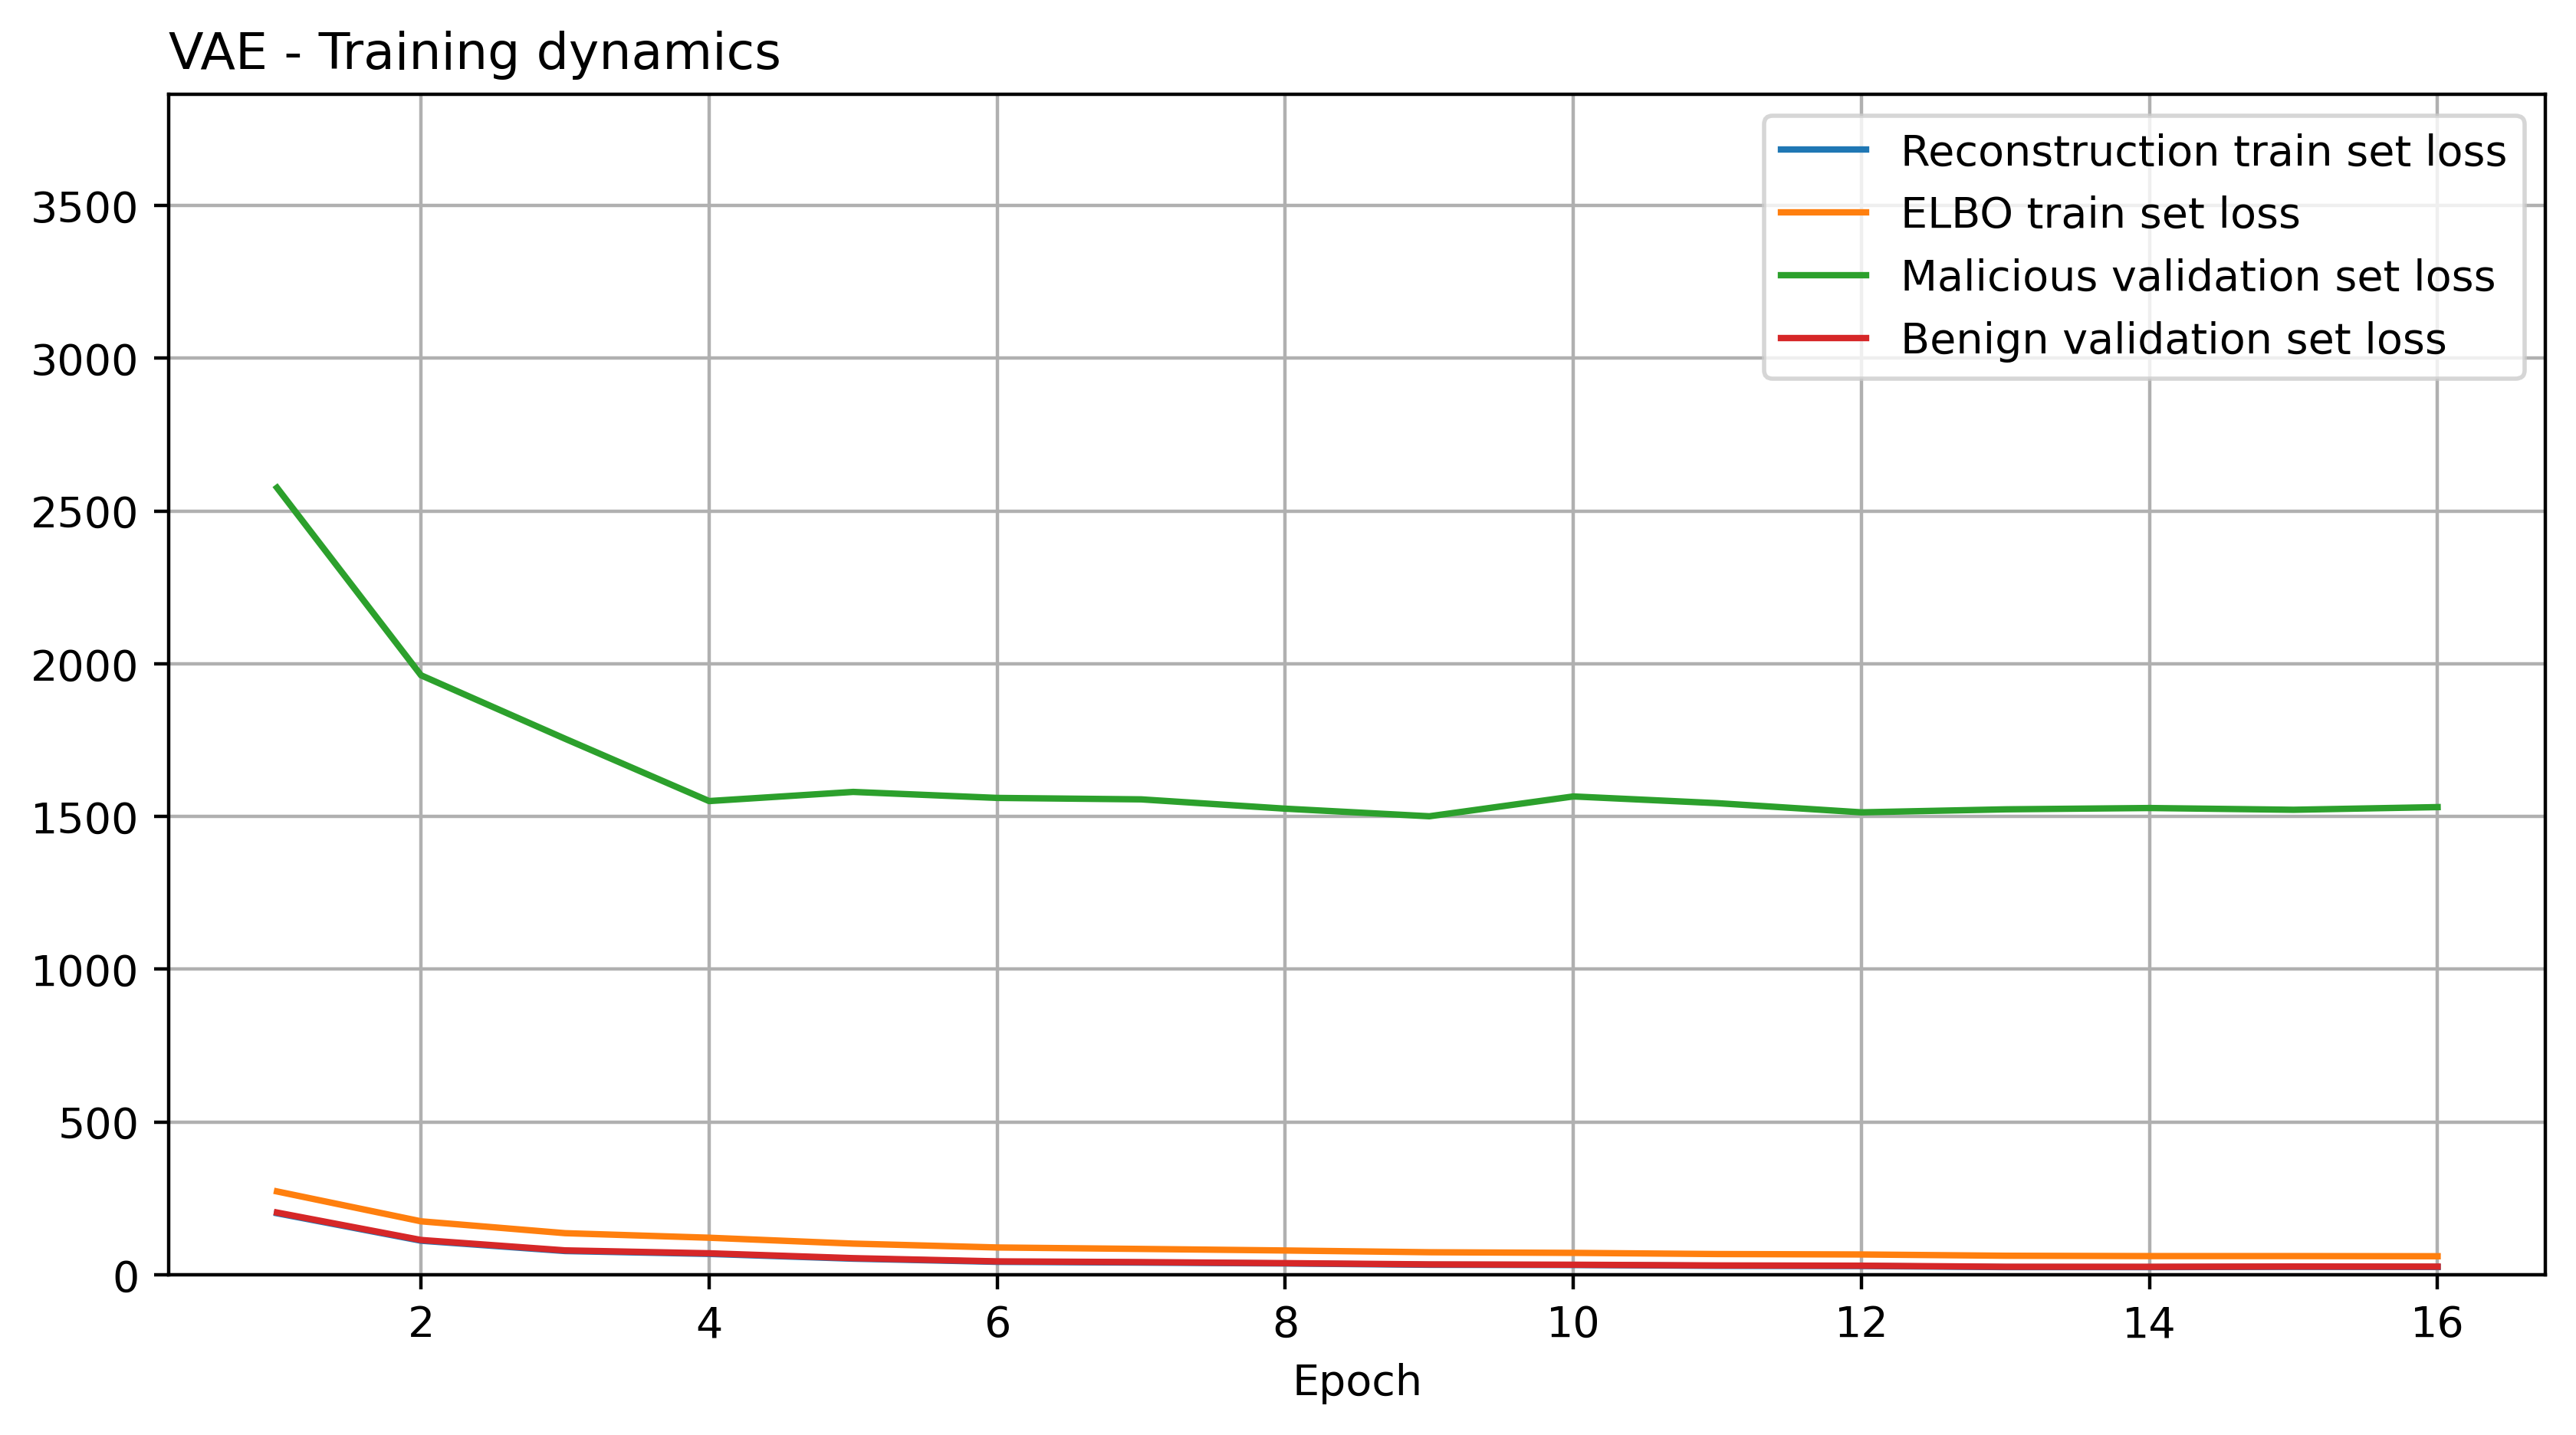

In [375]:
# Visualize training

fig = plt.figure(figsize = (10, 5), dpi = 400)

train_val, = plt.plot(val_epochs, training_val_losses, label = 'Reconstruction train set loss')
train_elbo, = plt.plot(val_epochs, training_elbo_losses, label = 'ELBO train set loss')
val_malicious, = plt.plot(val_epochs, malicious_population_reconstruction, label = 'Malicious validation set loss')
val_benign, = plt.plot(val_epochs, benign_population_reconstruction, label = 'Benign validation set loss')
plt.legend(handles = [train_val, train_elbo, val_malicious, val_benign])

plt.xlabel('Epoch')
plt.grid(True)
plt.title('VAE - Training dynamics', loc = 'left')
plt.ylim(0, max(max(malicious_population_reconstruction), max(benign_population_reconstruction)) * 1.5)

fig.savefig('vae_training.png', dpi = 400, bbox_inches = 'tight')

plt.show()

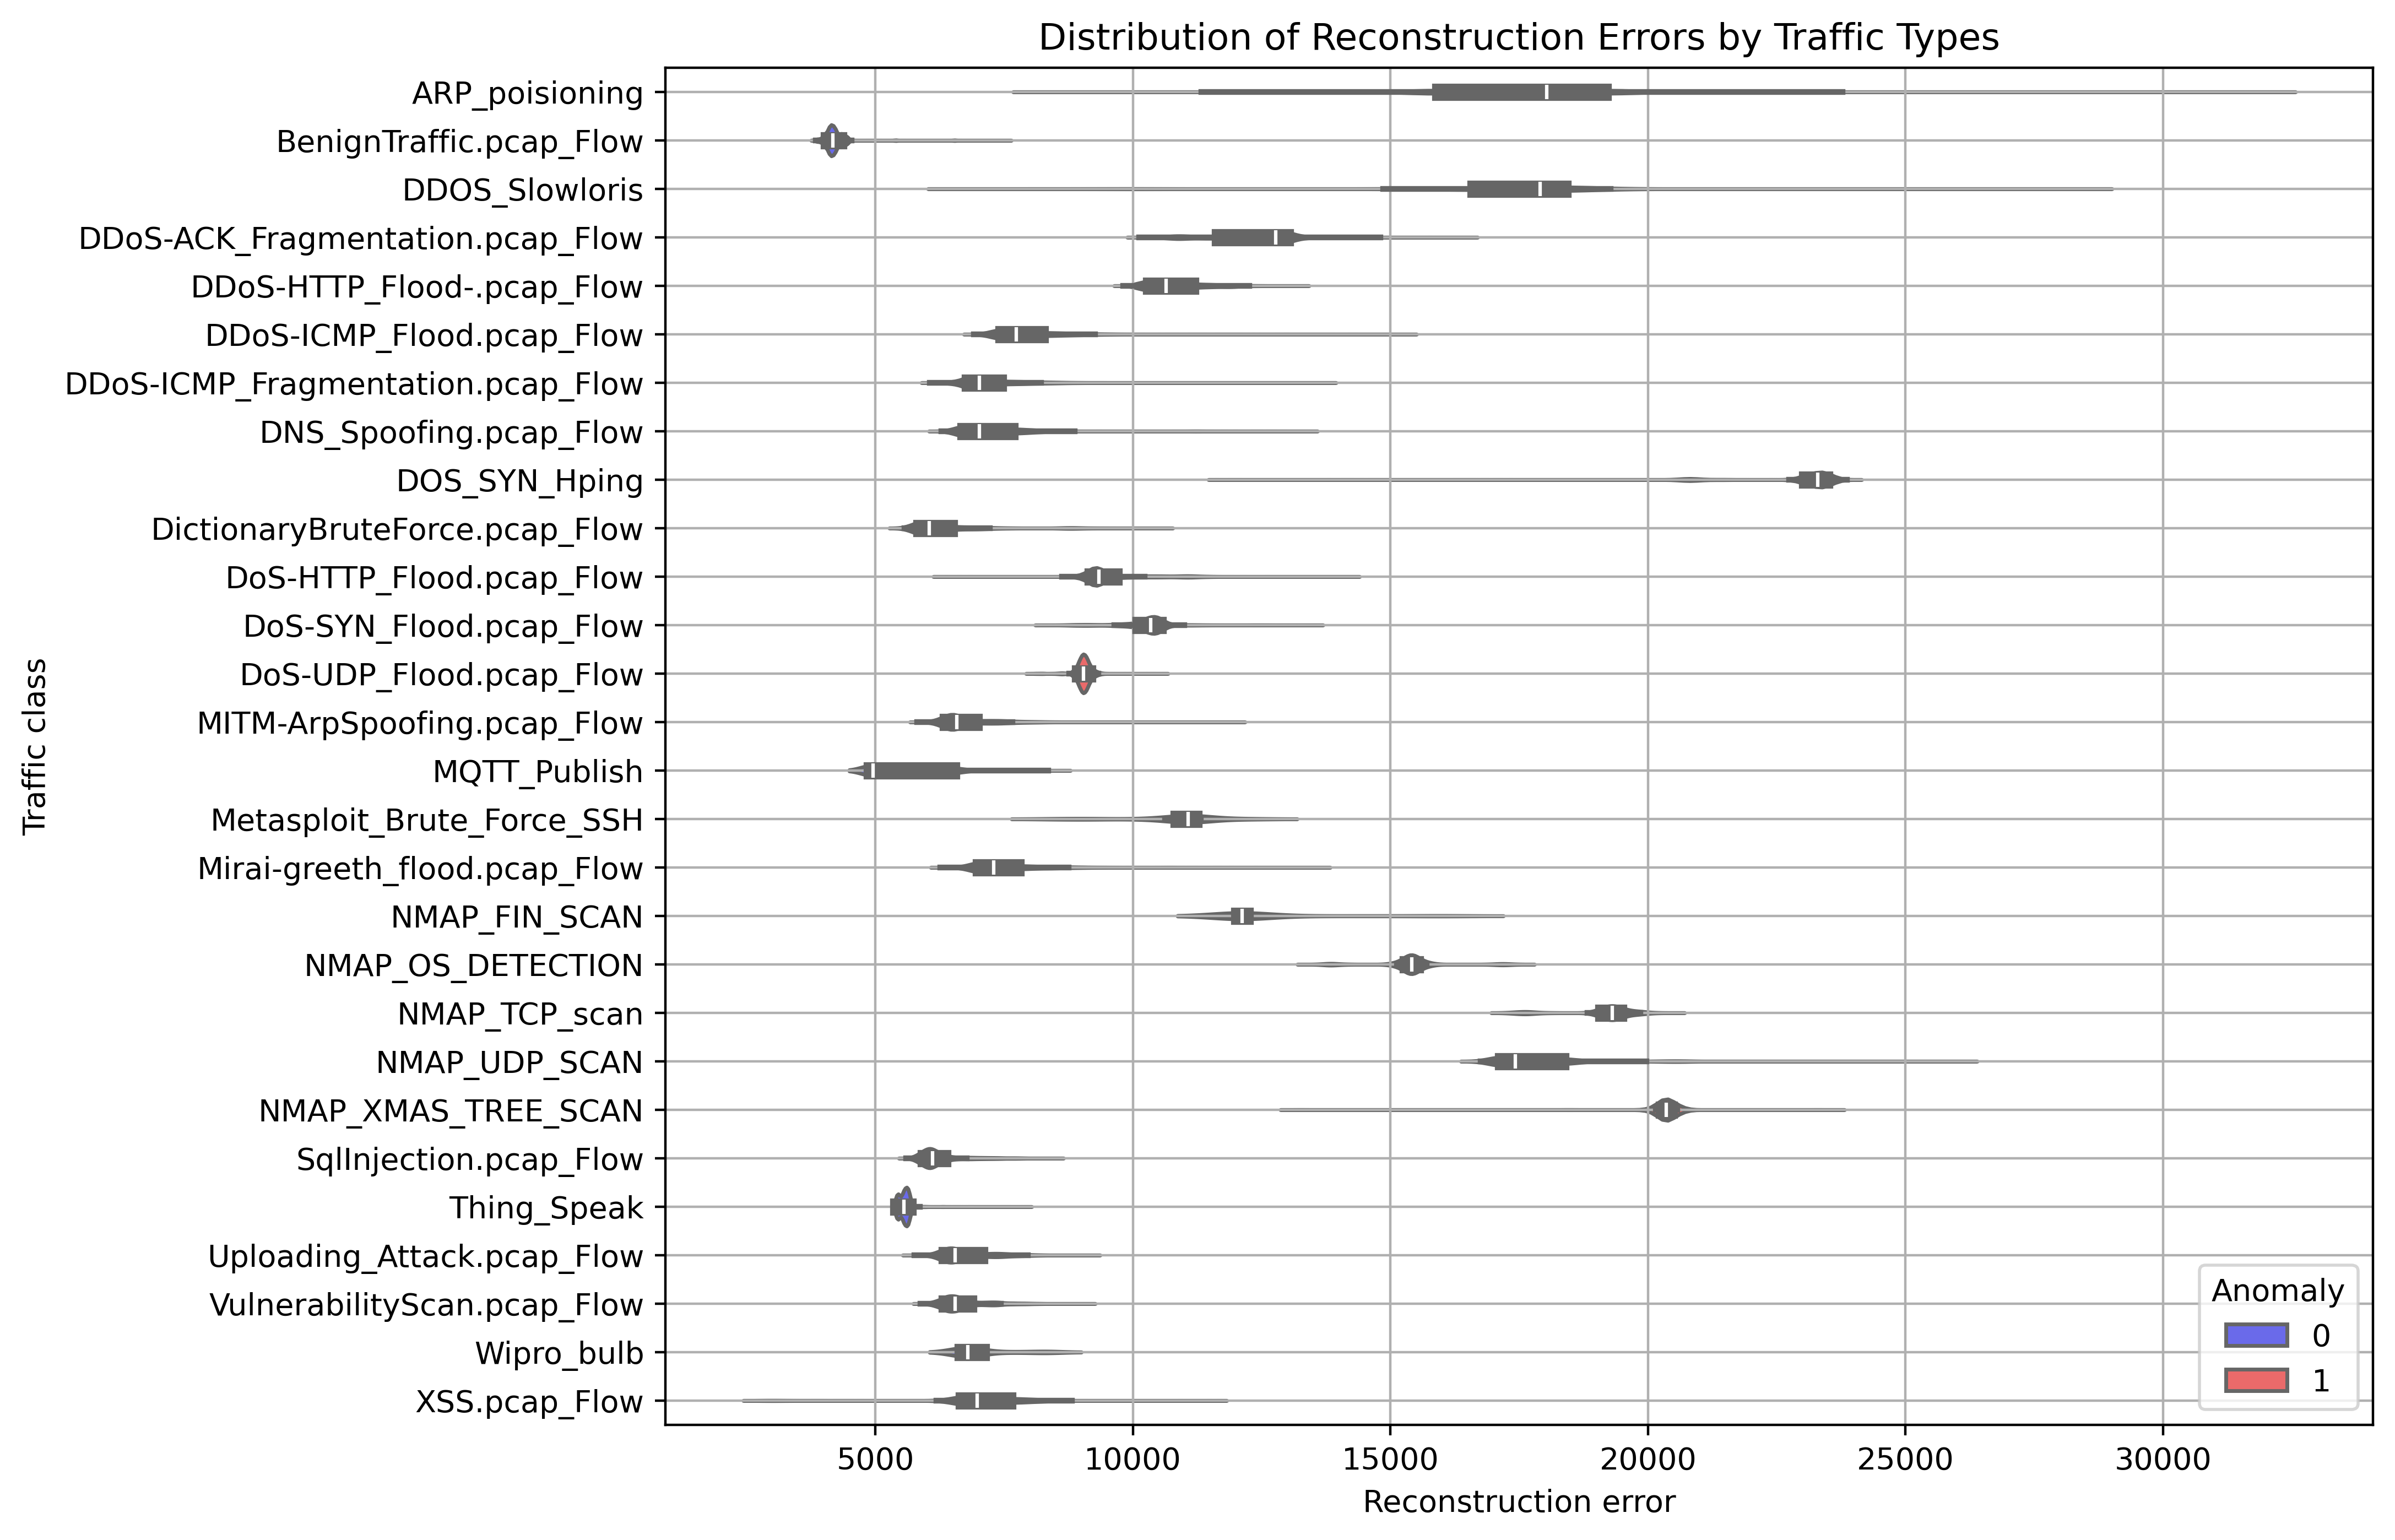

In [360]:
# Visualize validation reconstructon errors

use_pretrained = False
use_kld = True
kl_beta = 0.5

if use_pretrained:
    
    state_dict = torch.load(vae_file, weights_only = True, map_location = device).items()
    vae_model.load_state_dict(state_dict, strict = True)

vae_model.eval()

val_reconstruction_errors = []
val_labels = []

val_dataset = TrafficDataset(data = iot_df_val.loc[:, train_column_names], condition = iot_df_val.loc[:, condition_column_names],
                                 training = False, labels = iot_df_val['Attack_type'])
val_loader = DataLoader(dataset = val_dataset,  batch_size = test_batch_size, shuffle = False)

with torch.no_grad():
    
    for val_batch_number, batch in enumerate(val_loader):
    
        train_tensor = batch['training_data'].to(DEVICE)
        condition_tensor = batch['condition'].to(DEVICE)
        class_labels = batch['labels'].to(DEVICE)
    
        reconstruction, mean, log_var = vae_model(train_tensor, condition_tensor)

        if not use_kld:
        
            reconstruction_errors = huber(reconstruction, train_tensor, reduction = None)

        else:

            reconstruction_errors = ELBO_loss_function(train_tensor, reconstruction, mean, log_var, beta = kl_beta,
                                                           r_func = huber, reduction = None)

        val_reconstruction_errors.extend(reconstruction_errors.tolist())
        val_labels.extend(list(map(lambda x: val_dataset.index_label_mapping[x], class_labels.tolist())))

error_df = pd.DataFrame({
    'Reconstruction error' : val_reconstruction_errors,
    'Traffic class' : val_labels})

error_df['Anomaly'] = (error_df['Traffic class'].isin([key for key, val in \
                            traffic_type_mapping.items() if val == 'Benign']) == False).astype('int8')

# Visualize 

fig = plt.figure(figsize = (10, 8), dpi = 400)

sns.violinplot(x = 'Reconstruction error', y = 'Traffic class', data = error_df,
                   palette = 'seismic', hue = 'Anomaly', orient = 'h')
plt.xlabel('Reconstruction error')
plt.ylabel('Traffic class')
plt.title('Distribution of Reconstruction Errors by Traffic Types')
plt.grid(True)

fig.savefig('vae_inference.png', dpi = 400, bbox_inches = 'tight')

plt.show()


Best Threshold: 5675.787916
Best Balanced Accuracy: 0.9947
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     41082
           1       1.00      1.00      1.00    210247

    accuracy                           1.00    251329
   macro avg       1.00      0.99      1.00    251329
weighted avg       1.00      1.00      1.00    251329



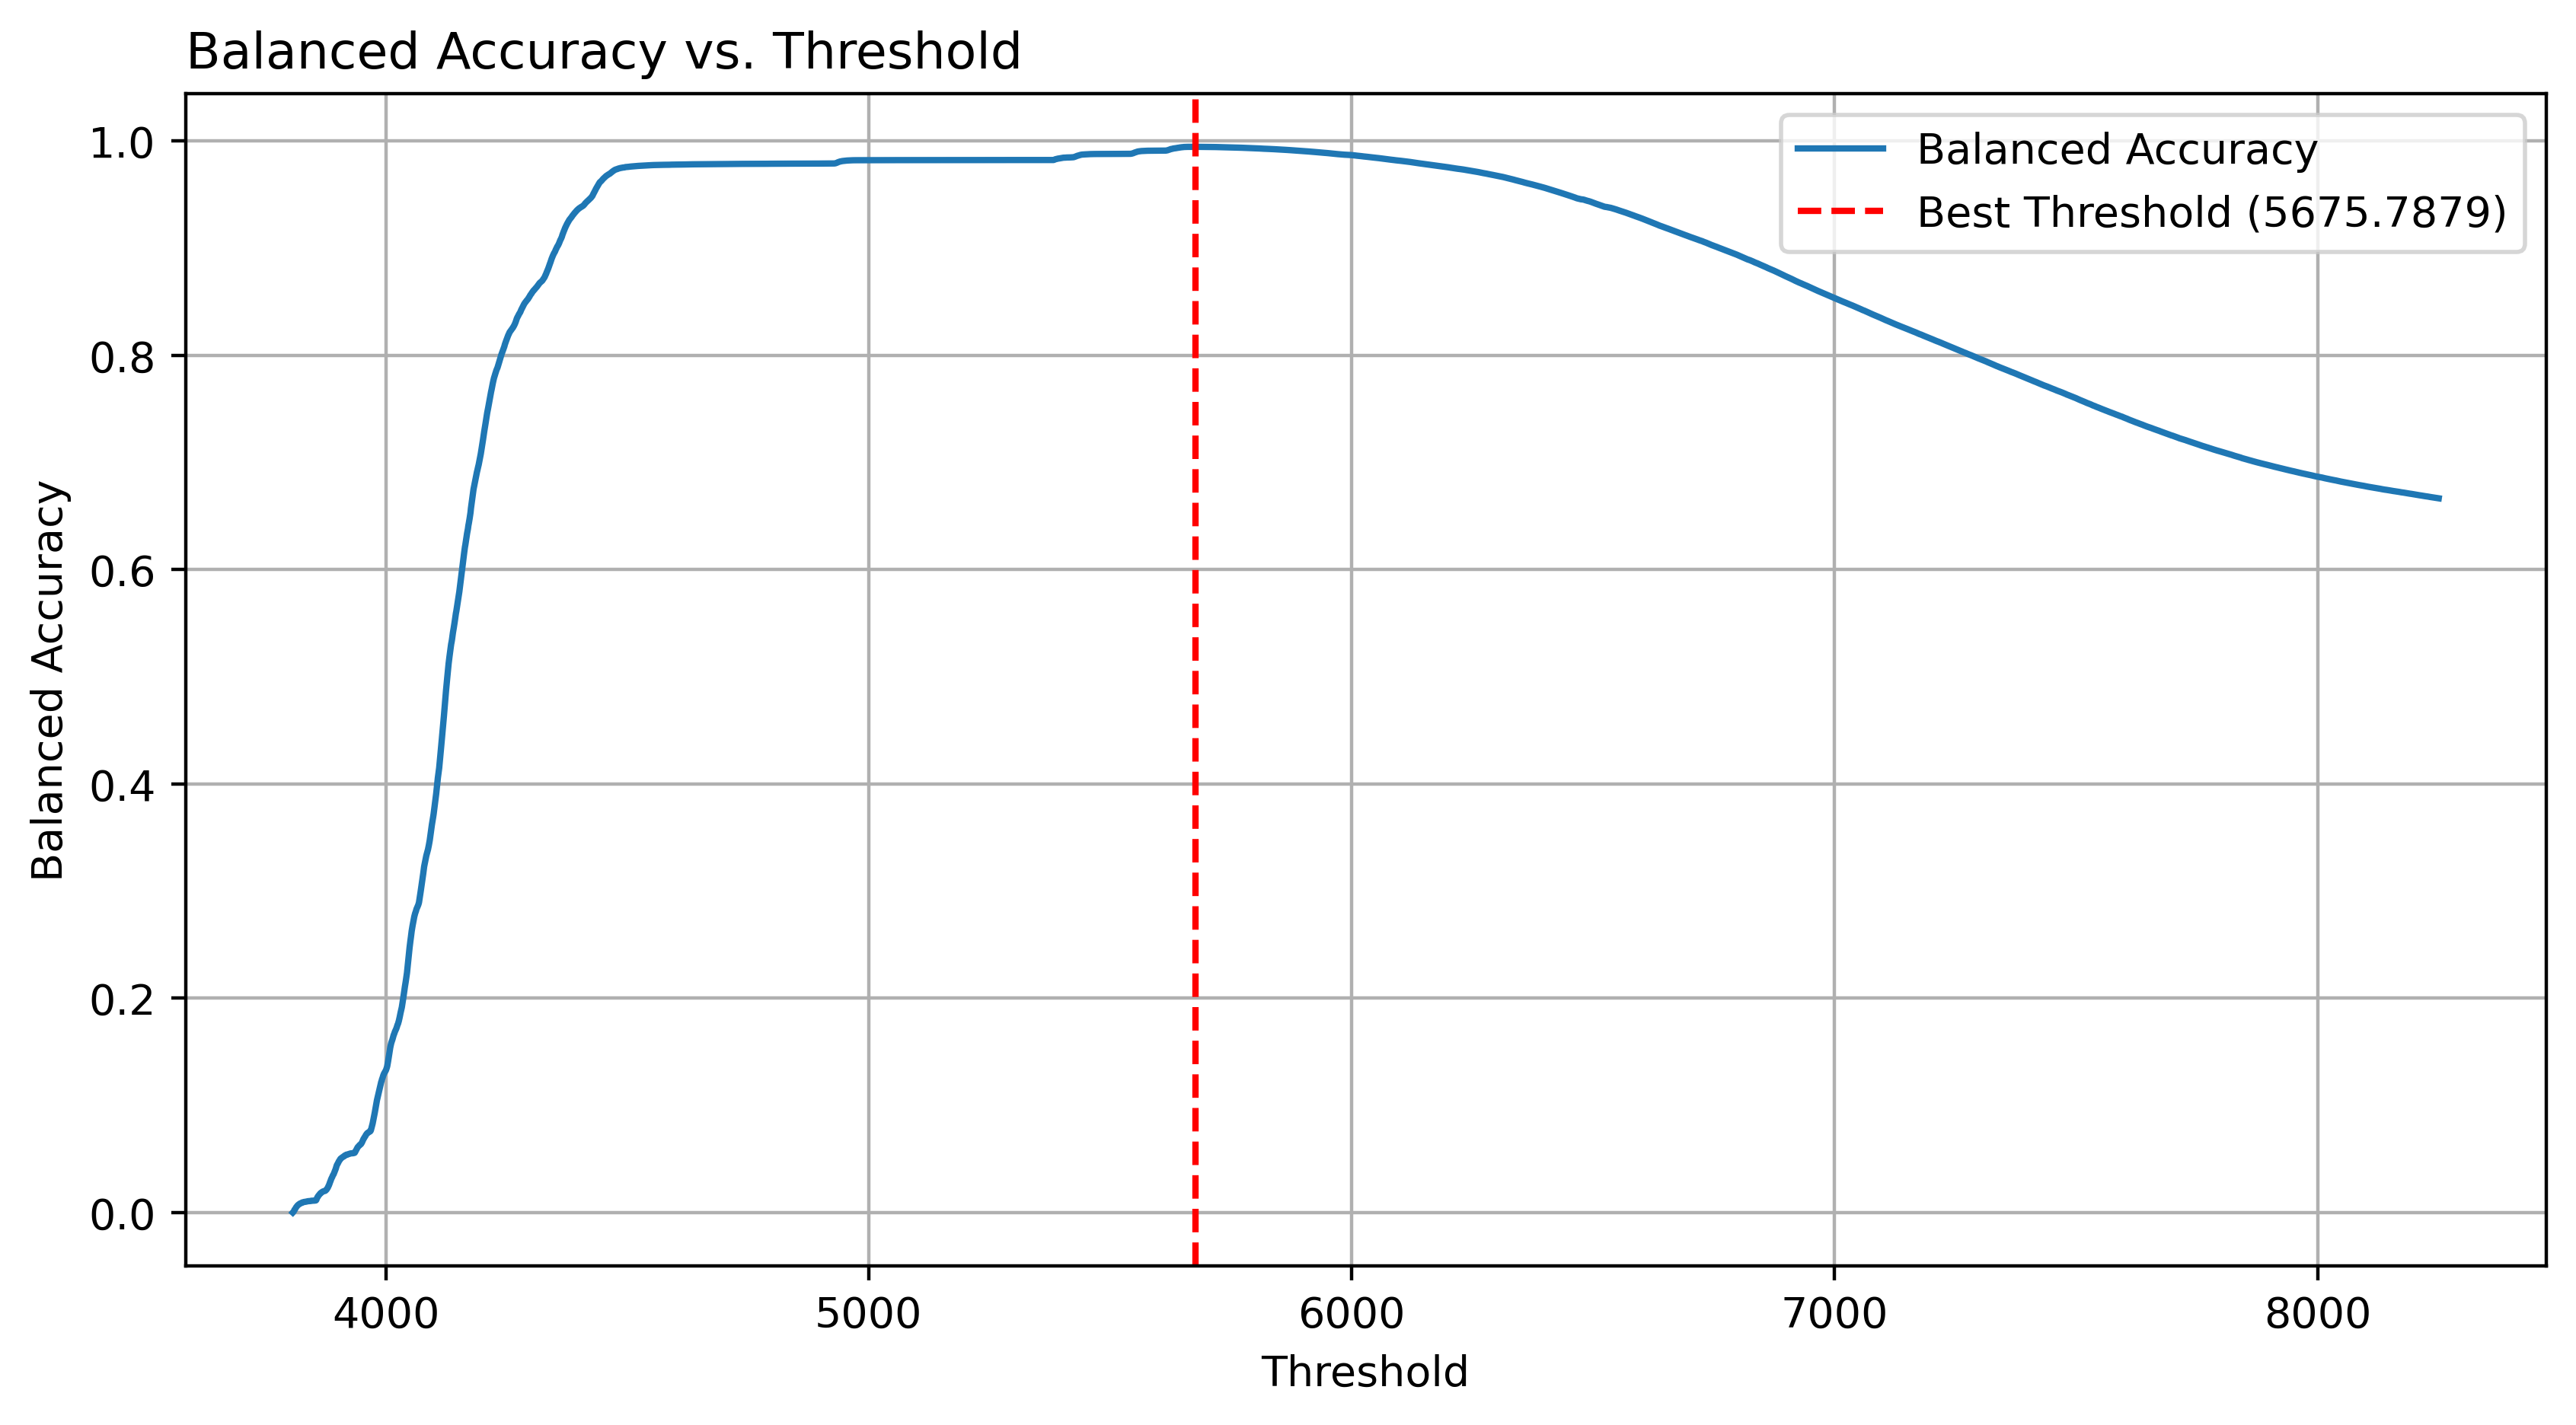

In [363]:
# Tune reconstruction thresholds

search_quantiles = (0, 0.5)

thresholds = np.linspace(
    error_df.loc[error_df['Anomaly'] == 0, 'Reconstruction error'].quantile(search_quantiles[0]),
    error_df.loc[error_df['Anomaly'] == 1, 'Reconstruction error'].quantile(search_quantiles[1]), 5000)

best_threshold = None
best_balanced_accuracy = -np.inf
benign_anomaly_tradeoff = 1

balanced_accuracies = []

for threshold in thresholds:
    
    y_pred = (error_df['Reconstruction error'] > threshold).astype(int)
    
    benign_mask = (error_df['Anomaly'] == 0)
    malicious_mask = (error_df['Anomaly'] == 1)
    
    benign_accuracy = (y_pred.loc[benign_mask] == error_df.loc[benign_mask, 'Anomaly']).mean()
    malicious_accuracy = (y_pred.loc[malicious_mask] == error_df.loc[malicious_mask, 'Anomaly']).mean()
    
    if benign_accuracy > 0 and malicious_accuracy > 0:
        balanced_acc = (1 + benign_anomaly_tradeoff) * (benign_accuracy * malicious_accuracy) / \
                       (benign_anomaly_tradeoff * malicious_accuracy + benign_accuracy)
    else:
        balanced_acc = 0
    
    balanced_accuracies.append(balanced_acc)
    
    if balanced_acc > best_balanced_accuracy:
        best_balanced_accuracy = balanced_acc
        best_threshold = threshold

print(f'Best Threshold: {best_threshold:.6f}')
print(f'Best Balanced Accuracy: {best_balanced_accuracy:.4f}')

error_df['Predicted anomaly'] = (error_df['Reconstruction error'] > best_threshold).astype(int)

print(classification_report(error_df['Anomaly'], error_df['Predicted anomaly']))

# Visualize performance
fig = plt.figure(figsize = (10, 5), dpi = 400)
plt.plot(thresholds, balanced_accuracies, label = 'Balanced Accuracy')
plt.axvline(x = best_threshold, color='red', linestyle = '--', label = f'Best Threshold ({best_threshold:.4f})')
plt.xlabel('Threshold')
plt.ylabel('Balanced Accuracy')
plt.title('Balanced Accuracy vs. Threshold', loc = 'left')
plt.legend()
plt.grid(True)

fig.savefig('vae_threshold.png', dpi = 400)

plt.show()


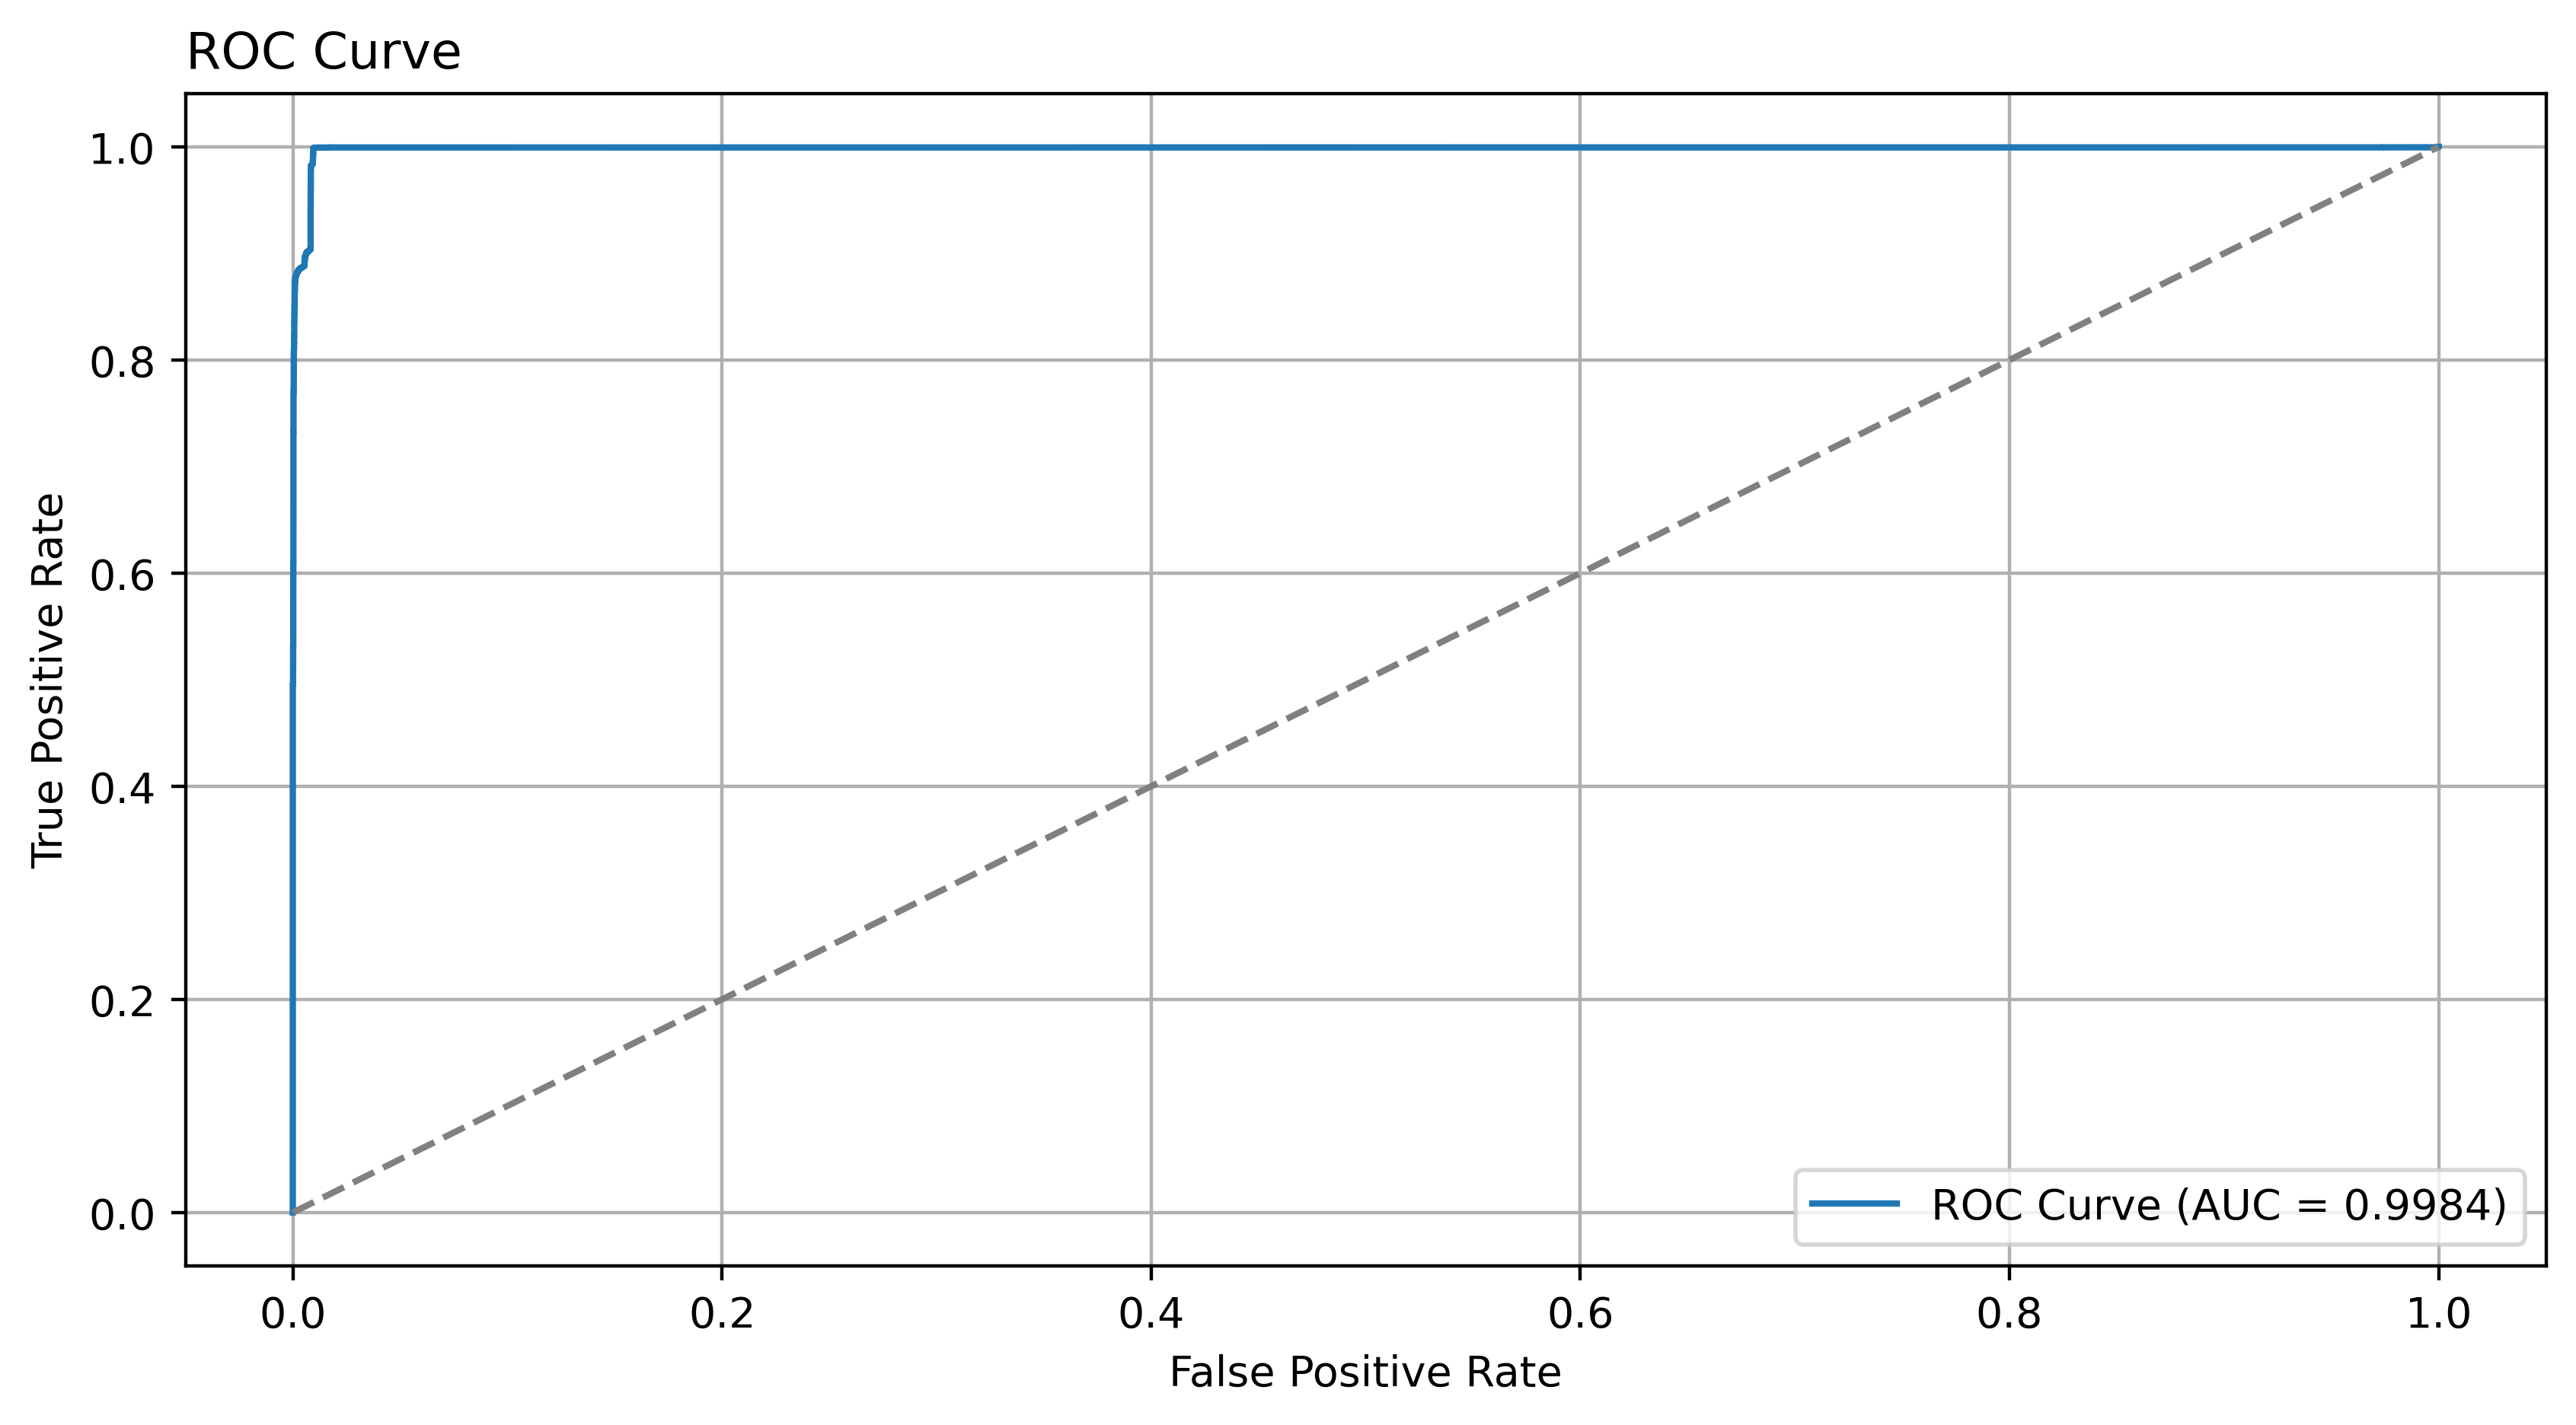

In [364]:
# ROC Curve

balanced_error_df = error_df.sample(n = 200000, replace = True,
        weights = 1 / error_df.groupby('Anomaly')['Predicted anomaly'].transform('count'))

fpr, tpr, _ = roc_curve(balanced_error_df['Anomaly'], balanced_error_df['Reconstruction error'])
roc_auc = auc(fpr, tpr)

fig = plt.figure(figsize = (10, 5), dpi = 400)
plt.plot(fpr, tpr, label = f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0,1], [0,1], linestyle = '--', color = 'gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve', loc = 'left')
plt.legend()
plt.grid(True)

fig.savefig('vae_roc.png', dpi = 400)

plt.show()

In [63]:
# Save the model

torch.save(vae_model.state_dict(), vae_file)

## Generative Modeling - GAN

In [300]:
# Model parameters

use_gpu = True
use_pretrained = False

gan_file = 'gan_traffic_model.pth'

DEVICE = torch.device('mps' if torch.mps.is_available() and use_gpu else ('cuda' if torch.cuda.is_available() and use_gpu else 'cpu'))

train_column_names = [col for col in iot_df.select_dtypes(include = [np.number]).columns \
                          if not col.startswith(('proto_', 'service_')) and col not in ['Attack_type_l']]
condition_column_names = [col for col in iot_df.columns if col.startswith('proto_') or col.startswith('is_')]

x_dim = len(train_column_names)
cond_dim = len(condition_column_names)
data_range_factor = 1.5

encoder_data_hidden_dim = 512
encoder_latent_hidden_dim = 256
decoder_hidden_dim = 256
discriminator_hidden_dim = 356
latent_dim = 10

batch_size = 124
test_batch_size = batch_size * 2


In [377]:
# Data loading preparation

normal_val_share = 0.1
mal_train_sample = 0.05

class TrafficDataset(Dataset):

    def __init__(self, data, condition, unsupervised = True, labels = None):

        self.train_data = data.values
        self.condition = condition.values

        self.train_data_features = list(data.columns)
        self.condition_features = list(condition.columns)

        self.unsupervised = unsupervised

        if not self.unsupervised:
            
            self.label_index_mapping = {label : i for i, label in enumerate(labels.unique())}
            self.index_label_mapping = {i : label for label, i in self.label_index_mapping.items()}
            self.traffic_labels = labels.map(self.label_index_mapping).values

    def __len__(self):
        return self.train_data.shape[0]

    def __getitem__(self, idx):

        training_example = self.train_data[idx]
        conditioning = self.condition[idx]
        class_labels = None if self.unsupervised else self.traffic_labels[idx]

        item = {'training_data': torch.tensor(training_example, dtype = torch.float32),
                'condition' : torch.tensor(conditioning, dtype = torch.float32),
                'labels' : torch.tensor(class_labels, dtype = torch.long) if class_labels is not None else \
                            torch.zeros(1, dtype = torch.long)}

        return item

# Sample training and validation data

traffic_count_dict = iot_df.groupby('Traffic_type', observed = False)['ID'].count().to_dict()
benign_samples = int(traffic_count_dict['Benign'] * (1 - normal_val_share))
malicious_samples = int(traffic_count_dict['Malicious'])

malicious_samples_train_count = int((mal_train_sample * benign_samples) / (1 - mal_train_sample))
malicious_samples_train_share = malicious_samples_train_count / malicious_samples

iot_df_val = \
    iot_df.groupby('Attack_type', group_keys = False, observed = True) \
        .apply(lambda x: x.assign(Attack_type = x.name).sample(int(x.shape[0] * (1 - malicious_samples_train_share)) \
            if x.name not in [key for key, value in traffic_type_mapping.items() if value == 'Benign'] \
                else int(x.shape[0] * normal_val_share), replace = False), include_groups = False)

train_dataset = TrafficDataset(data = iot_df.loc[~iot_df['ID'].isin(iot_df_val['ID'].to_list()), train_column_names],
                                condition = iot_df.loc[~iot_df['ID'].isin(iot_df_val['ID'].to_list()), condition_column_names],
                                    unsupervised = False, labels = iot_df.loc[~iot_df['ID'].isin(iot_df_val['ID'].to_list()), 'Traffic_type'])
val_dataset = TrafficDataset(data = iot_df_val.loc[:, train_column_names], condition = iot_df_val.loc[:, condition_column_names],
                                 unsupervised = False, labels = iot_df_val['Traffic_type'])

train_loader = DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle = True)
val_loader = DataLoader(dataset = val_dataset,  batch_size = test_batch_size, shuffle = False)


In [302]:
# Specify GAN architecture

class EncoderGenerator(nn.Module):
    
    def __init__(self, input_dim, cond_dim, hidden_dim, latent_dim, gain_latent = 0.3):
        
        super().__init__()
        
        self.model = nn.Sequential(
            nn.Linear(input_dim + cond_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, latent_dim))

        self.model[-1].gain = gain_latent

    def forward(self, sample, condition):
        
        x = torch.cat([sample, condition], dim = 1)
        x = self.model(x)
        
        return x

class DecoderGenerator(nn.Module):
    
    def __init__(self, latent_dim, cond_dim, hidden_dim, output_dim, data_range_factor = 1, gain_output = 0.3):
        
        super().__init__()
        
        self.model = nn.Sequential(
            nn.Linear(latent_dim + cond_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, output_dim),
            nn.Sigmoid())

        self.data_range_factor = data_range_factor
        self.model[-2].gain = gain_output

    def forward(self, noise, condition):
        
        x = torch.cat([noise, condition], dim = 1)
        x = self.model(x) * self.data_range_factor
        
        return x

class EncoderLatent(nn.Module):
    
    def __init__(self, input_dim, cond_dim, hidden_dim, latent_dim, gain_latent = 0.3):
        
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim + cond_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, latent_dim))

        self.model[-1].gain = gain_latent

    def forward(self, sample, condition):
        
        x = torch.cat([sample, condition], dim = 1)
        x = self.model(x)
        
        return x

class Discriminator(nn.Module):
    
    def __init__(self, input_dim, cond_dim, hidden_dim, gain_output = 0.3):
        
        super().__init__()
        
        self.feature_extraction = nn.Sequential(
            nn.Linear(input_dim + cond_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(0.2))
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid())

        self.classifier[-2].gain = gain_output

    def forward(self, sample, condition):
        
        x = torch.cat([sample, condition], dim = 1)
        x_hidden = self.feature_extraction(x)
        score = self.classifier(x_hidden)
        
        return score, x_hidden

# Combined model architechture

class GANomaly(nn.Module):
    
    def __init__(self, GenerativeEncoder, GenerativeDecoder, GenerativeLatentEncoder, Discriminator, cond_dim, gain = 1):
        
        super(GANomaly, self).__init__()

        self.gen_encoder = GenerativeEncoder
        self.gen_decoder = GenerativeDecoder
        self.gen_latent_encoder = GenerativeLatentEncoder
        self.discriminator = Discriminator
        
        self.cond_dim = cond_dim
        self.gain = gain

        # Initialize parameters

        self.gen_encoder.apply(lambda m: GANomaly.init_weights(m, gain = self.gain))
        self.gen_decoder.apply(lambda m: GANomaly.init_weights(m, gain = self.gain))
        self.gen_latent_encoder.apply(lambda m: GANomaly.init_weights(m, gain = self.gain))
        self.discriminator.apply(lambda m: GANomaly.init_weights(m, gain = self.gain))
        
    def forward(self, x, cond = None):

        if cond is None:
            cond = torch.zeros(x.shape[0], self.cond_dim, dtype = torch.float32, device = x.device)
        
        z = self.gen_encoder(x, condition = cond)
        x_hat = self.gen_decoder(z, condition = cond)
        z_hat = self.gen_latent_encoder(x_hat, condition = cond)

        return x_hat, z, z_hat

    def discriminate(self, x, cond = None):

        if cond is None:
            cond = torch.zeros(x.shape[0], self.cond_dim, dtype = torch.float32, device = x.device)

        d_score, x_hidden = self.discriminator(x, cond)
        
        return d_score, x_hidden

    @staticmethod
    def init_weights(module, gain = 1):
        
        if isinstance(module, nn.Linear):

            if hasattr(module, 'gain'):
                gain = module.gain
            
            nn.init.xavier_uniform_(module.weight, gain = gain)
            
            if module.bias is not None:
                nn.init.zeros_(module.bias)

gen_encoder = EncoderGenerator(input_dim = x_dim, cond_dim = cond_dim, hidden_dim = encoder_data_hidden_dim, latent_dim = latent_dim)
gen_decoder = DecoderGenerator(latent_dim = latent_dim, cond_dim = cond_dim, hidden_dim = decoder_hidden_dim,
                                   output_dim = x_dim, data_range_factor = data_range_factor)
latent_encoder = EncoderLatent(input_dim = x_dim, cond_dim = cond_dim, hidden_dim = encoder_latent_hidden_dim, latent_dim = latent_dim)
discriminator = Discriminator(input_dim = x_dim, cond_dim = cond_dim, hidden_dim = discriminator_hidden_dim)


gan_model = GANomaly(GenerativeEncoder = gen_encoder, GenerativeDecoder = gen_decoder,
                         GenerativeLatentEncoder = latent_encoder, Discriminator = discriminator, cond_dim = cond_dim)

print(summary(gan_model, [(1, x_dim), (1, cond_dim)]))
total_params = sum(p.numel() for p in gan_model.parameters())
print('Total number of parameters:', total_params)
gan_model = gan_model.to(DEVICE)


Layer (type:depth-idx)                   Output Shape              Param #
GANomaly                                 [1, 75]                   156,641
├─EncoderGenerator: 1-1                  [1, 10]                   --
│    └─Sequential: 2-1                   [1, 10]                   --
│    │    └─Linear: 3-1                  [1, 512]                  41,984
│    │    └─LeakyReLU: 3-2               [1, 512]                  --
│    │    └─Linear: 3-3                  [1, 512]                  262,656
│    │    └─LeakyReLU: 3-4               [1, 512]                  --
│    │    └─Linear: 3-5                  [1, 10]                   5,130
├─DecoderGenerator: 1-2                  [1, 75]                   --
│    └─Sequential: 2-2                   [1, 75]                   --
│    │    └─Linear: 3-6                  [1, 256]                  4,352
│    │    └─LeakyReLU: 3-7               [1, 256]                  --
│    │    └─Linear: 3-8                  [1, 256]                

In [303]:
# Loss function

lr_g = 1e-3
lr_d = 1e-3
delta = 0.1
variance_correction = 0.05
norm_factor = 40
weight_decay = 0.001
max_epochs = 20

lambda_recon = 1.0
lambda_latent = 0.1
lambda_adv = 0.1

malicious_penalty_min = 0.5
malicious_penalty_max = np.inf
malicious_penalty_step = 0.1

class FeatureWiseHuberLoss(nn.Module):
    
    def __init__(self, feature_weights = None, delta = 1.0, norm_factor = 1):

        super().__init__()
        self.feature_weights = feature_weights
        self.delta = delta
        self.norm_factor = norm_factor

    def forward(self, pred, target, reduction = 'sum'):
        
        error = (pred * self.norm_factor) - (target * self.norm_factor)
        abs_error = torch.abs(error)

        # Huber loss calculation
        quadratic = torch.minimum(abs_error, torch.tensor(self.delta * self.norm_factor).to(error.device))
        linear = abs_error - quadratic
        huber_loss = 0.5 * quadratic ** 2 + self.delta * self.norm_factor * linear

        # Apply feature-wise weights if given
        if self.feature_weights is not None:
            huber_loss = (huber_loss * self.feature_weights)

        huber_loss = huber_loss.sum(dim = 1) 

        # Reduction over batch
        if reduction == 'mean':
            return huber_loss.mean()
        elif reduction == 'sum':
            return huber_loss.sum()
        else:
            return huber_loss

def GANomaly_loss(x = None, x_hat = None, z = None, z_hat = None, d_score = None, x_hidden = None, d_hat_score_G = None,
                      d_hat_score_D = None, x_hat_hidden = None, d_mal_score = None, rec_fn = torch.nn.functional.mse_loss,
                          lambda_recon = 1.0, lambda_latent = 0.1, lambda_adv = 0.1, mal_penalty = 0.5, reduction = 'none'):
    
    # Initiate losses
    L_recon, L_latent, L_adv, G_adv_loss = 0, 0, 0, 0
    D_real, D_gen, D_mal = 0, 0, 0
    
    # Reconstruction loss
    if x is not None and x_hat is not None:
        L_recon = rec_fn(x_hat, x, reduction = reduction)
        if reduction == 'none' and L_recon.ndim > 1:
            L_recon = L_recon.sum(dim = tuple(range(1, L_recon.ndim)))

    # Latent consistency loss
    if z is not None and z_hat is not None:
        L_latent = torch.nn.functional.mse_loss(z_hat, z, reduction = reduction)
        if reduction == 'none' and L_latent.ndim > 1:
            L_latent = L_latent.sum(dim = tuple(range(1, L_latent.ndim)))

    # Adversarial loss
    if x_hidden is not None and x_hat_hidden is not None:
        L_adv = torch.nn.functional.mse_loss(x_hat_hidden, x_hidden, reduction = reduction)
        if reduction == 'none' and L_adv.ndim > 1:
            L_adv = L_adv.sum(dim = tuple(range(1, L_adv.ndim)))
    if d_hat_score_G is not None:
        G_adv_loss = torch.nn.functional.binary_cross_entropy(d_hat_score_G, torch.ones_like(d_hat_score_G), reduction = reduction)
        if reduction == 'none' and G_adv_loss.ndim > 1:
            G_adv_loss = G_adv_loss.sum(dim = tuple(range(1, G_adv_loss.ndim)))

    # Total generator loss
    G_loss = lambda_recon * L_recon + lambda_latent * L_latent + lambda_adv * (L_adv + G_adv_loss)

    # Discriminator loss
    if d_score is not None:
        D_real = torch.nn.functional.binary_cross_entropy(d_score, torch.ones_like(d_score), reduction = reduction)
        if reduction == 'none' and D_real.ndim > 1:
            D_real = D_real.sum(dim = tuple(range(1, D_real.ndim)))
    if d_hat_score_D is not None:
        D_gen = torch.nn.functional.binary_cross_entropy(d_hat_score_D, torch.zeros_like(d_hat_score_D), reduction = reduction)
        if reduction == 'none' and D_gen.ndim > 1:
            D_gen = D_gen.sum(dim = tuple(range(1, D_gen.ndim)))
    
    # Malicious traffic injection
    if d_mal_score is not None:
        D_mal = mal_penalty * torch.nn.functional.binary_cross_entropy(d_mal_score, torch.zeros_like(d_mal_score), reduction = reduction)
        if reduction == 'none' and D_mal.ndim > 1:
            D_mal = D_mal.sum(dim = tuple(range(1, D_mal.ndim)))

    # Total discriminator loss

    D_loss = D_real + D_gen + D_mal

    loss_dict = {
        'G_loss': G_loss,
        'D_loss': D_loss,
        'L_recon': L_recon,
        'L_latent': L_latent,
        'L_adv': L_adv,
        'G_adv_loss': G_adv_loss,
        'D_real' : D_real,
        'D_gen' : D_gen,
        'D_mal' : D_mal}

    return loss_dict

# Feature reconstruction sensitivity

feature_variance = torch.tensor(train_dataset.train_data, dtype = torch.float32).var(dim = 0)

feature_weights = 1.0 / (feature_variance + variance_correction)
feature_weights = feature_weights.to(DEVICE)

# Initialize the loss

huber = FeatureWiseHuberLoss(feature_weights = feature_weights, delta = delta, norm_factor = norm_factor)

# Initialize optimizers

optimizerG = optim.Adam(itertools.chain(gan_model.gen_encoder.parameters(), gan_model.gen_decoder.parameters(),
                             gan_model.gen_latent_encoder.parameters()), lr = lr_g, weight_decay = weight_decay)
optimizerD = optim.Adam(gan_model.discriminator.parameters(), lr = lr_d, weight_decay = weight_decay)

schedulerG = optim.lr_scheduler.StepLR(optimizerG, step_size = 1, gamma = 0.95)
schedulerD = optim.lr_scheduler.StepLR(optimizerD, step_size = 1, gamma = 0.95)


In [304]:
# Training pipeline

val_cycle = 1
kl_beta = 1
min_improvement = 0
non_improvement_tolerance = 1

non_improvement_count = 0
best_rec_score = np.inf
best_div_score = -np.inf

training_val_Dlosses = []
training_val_Glosses = []

malicious_population_loss = []
benign_population_loss = []

epochs = []
val_epochs = []
early_stopping = True

for epoch in range(max_epochs):
        
    # Training

    if epoch == 0:
        mal_penalty = malicious_penalty_min
    else:
        mal_penalty = min(mal_penalty + malicious_penalty_step, malicious_penalty_max)

    gan_model.train()
    torch.autograd.set_detect_anomaly(True)

    for batch_number, batch in enumerate(train_loader):

        # Model forward pass
        
        train_tensor = batch['training_data'].to(DEVICE)
        condition_tensor = batch['condition'].to(DEVICE)
        class_labels = batch['labels'].to(DEVICE)
    
        malicious_mask = (class_labels == train_dataset.label_index_mapping['Malicious'])
        benign_mask = (class_labels == train_dataset.label_index_mapping['Benign'])

        # Discriminator optimization

        benign_rec, benign_z_latent, benign_z_reconstr = None, None, None
        benign_real_d_score, benign_real_hidden = None, None
        benign_rec_d_score_G, benign_rec_hidden_G = None, None
        benign_rec_d_score_D, benign_rec_hidden_D = None, None
        malicious_real_d_score, malicious_real_hidden = None, None

        if benign_mask.sum() > 0:
            
            benign_rec, benign_z_latent, benign_z_reconstr = gan_model(train_tensor[benign_mask], condition_tensor[benign_mask])
            benign_rec_D = benign_rec.clone().detach().requires_grad_(True)
            benign_real_d_score, benign_real_hidden = gan_model.discriminate(train_tensor[benign_mask], condition_tensor[benign_mask]) 
            benign_rec_d_score_D, benign_rec_hidden_D = gan_model.discriminate(benign_rec_D, condition_tensor[benign_mask])

        if malicious_mask.sum() > 0:
            
            malicious_real_d_score, malicious_real_hidden =  \
                gan_model.discriminate(train_tensor[malicious_mask], condition_tensor[malicious_mask])

        # Loss computation
        
        loss_dict = GANomaly_loss(
            d_score = benign_real_d_score,
            d_hat_score_D = benign_rec_d_score_D,
            rec_fn = huber,
            d_mal_score = malicious_real_d_score,
            lambda_recon = lambda_recon, lambda_latent = lambda_latent,
            lambda_adv = lambda_adv, mal_penalty = mal_penalty, reduction = 'sum')

        if benign_mask.sum() > 0 or malicious_mask.sum() > 0:
            optimizerD.zero_grad()
            loss_dict['D_loss'].backward(retain_graph = True)
            optimizerD.step()

        # Generator optimization

        benign_rec, benign_z_latent, benign_z_reconstr = None, None, None
        benign_real_d_score, benign_real_hidden = None, None
        benign_rec_d_score_G, benign_rec_hidden_G = None, None
        benign_rec_d_score_D, benign_rec_hidden_D = None, None
        malicious_real_d_score, malicious_real_hidden = None, None

        if benign_mask.sum() > 0:
            
            benign_rec, benign_z_latent, benign_z_reconstr = gan_model(train_tensor[benign_mask], condition_tensor[benign_mask])
            benign_rec_G = benign_rec
            benign_real_d_score, benign_real_hidden = gan_model.discriminate(train_tensor[benign_mask], condition_tensor[benign_mask]) 
            benign_rec_d_score_G, benign_rec_hidden_G = gan_model.discriminate(benign_rec_G, condition_tensor[benign_mask])
            benign_real_hidden_G = benign_real_hidden.clone().detach()

        loss_dict = GANomaly_loss(
            x = train_tensor[benign_mask],
            x_hat = benign_rec,
            z = benign_z_latent,
            z_hat = benign_z_reconstr,
            d_score = benign_real_d_score,
            x_hidden = benign_real_hidden_G,
            d_hat_score_G = benign_rec_d_score_G,
            x_hat_hidden = benign_rec_hidden_G,
            rec_fn = huber,
            lambda_recon = lambda_recon, lambda_latent = lambda_latent,
            lambda_adv = lambda_adv, mal_penalty = mal_penalty, reduction = 'sum')
            
        if benign_mask.sum() > 0:
            optimizerG.zero_grad()
            loss_dict['G_loss'].backward()
            optimizerG.step()

    schedulerG.step()
    schedulerD.step()

    # Model validation

    training_val_Gloss = 0
    training_val_Dloss = 0
    
    malicious_val_loss = 0
    benign_val_loss = 0

    malicious_train_count = 0
    benign_train_count = 0

    malicious_val_count = 0
    benign_val_count = 0

    if  epoch % val_cycle == 0:
        
        gan_model.eval()

        with torch.no_grad():

            # Train set validation
        
            for batch_number, batch in enumerate(train_loader):
                
                # Model forward pass
            
                train_tensor = batch['training_data'].to(DEVICE)
                condition_tensor = batch['condition'].to(DEVICE)
                class_labels = batch['labels'].to(DEVICE)
            
                malicious_mask = (class_labels == train_dataset.label_index_mapping['Malicious'])
                benign_mask = (class_labels == train_dataset.label_index_mapping['Benign'])
    
                benign_rec, benign_z_latent, benign_z_reconstr = None, None, None
                benign_real_d_score, benign_real_hidden = None, None
                benign_rec_d_score, benign_rec_hidden = None, None
    
                malicious_rec, malicious_z_latent, malicious_z_reconstr = None, None, None
                malicious_real_d_score, malicious_real_hidden = None, None
                malicious_rec_d_score, malicious_rec_hidden = None, None
    
                if benign_mask.sum() > 0:
                    benign_rec, benign_z_latent, benign_z_reconstr = gan_model(train_tensor[benign_mask], condition_tensor[benign_mask])
                    benign_real_d_score, benign_real_hidden = gan_model.discriminate(train_tensor[benign_mask], condition_tensor[benign_mask])
                    benign_rec_d_score, benign_rec_hidden = gan_model.discriminate(benign_rec, condition_tensor[benign_mask])
                    benign_train_count += benign_mask.sum().item()
    
                if malicious_mask.sum() > 0:
                    malicious_real_d_score, malicious_real_hidden = \
                        gan_model.discriminate(train_tensor[malicious_mask], condition_tensor[malicious_mask])
                    malicious_train_count += malicious_mask.sum().item()

                # Loss computation
                
                loss_dict = GANomaly_loss(
                    x = train_tensor[benign_mask],
                    x_hat = benign_rec,
                    z = benign_z_latent,
                    z_hat = benign_z_reconstr,
                    d_score = benign_real_d_score,
                    x_hidden = benign_real_hidden,
                    d_hat_score_G = benign_rec_d_score,
                    d_hat_score_D = benign_rec_d_score,
                    x_hat_hidden = benign_rec_hidden,
                    rec_fn = huber,
                    d_mal_score = malicious_real_d_score,
                    lambda_recon = lambda_recon, lambda_latent = lambda_latent,
                    lambda_adv = lambda_adv, mal_penalty = mal_penalty, reduction = 'sum')
                
                training_val_Gloss += loss_dict['G_loss'].item()
                training_val_Dloss += loss_dict['D_loss'].item()
            
            training_val_Glosses.append(training_val_Gloss / max(benign_train_count, 1))
            training_val_Dlosses.append(training_val_Dloss / max((benign_train_count + malicious_train_count), 1))
    
            # Test set validation
            
            for batch_number, batch in enumerate(val_loader):
                
                # Model forward pass
            
                train_tensor = batch['training_data'].to(DEVICE)
                condition_tensor = batch['condition'].to(DEVICE)
                class_labels = batch['labels'].to(DEVICE)
            
                malicious_mask = (class_labels == train_dataset.label_index_mapping['Malicious'])
                benign_mask = (class_labels == train_dataset.label_index_mapping['Benign'])
    
                benign_rec, benign_z_latent, benign_z_reconstr = None, None, None
                benign_real_d_score, benign_real_hidden = None, None
                benign_rec_d_score, benign_rec_hidden = None, None
    
                malicious_rec, malicious_z_latent, malicious_z_reconstr = None, None, None
                malicious_real_d_score, malicious_real_hidden = None, None
                malicious_rec_d_score, malicious_rec_hidden = None, None
    
                if benign_mask.sum() > 0:
                    benign_rec, benign_z_latent, benign_z_reconstr = gan_model(train_tensor[benign_mask], condition_tensor[benign_mask])
                    benign_real_d_score, benign_real_hidden = gan_model.discriminate(train_tensor[benign_mask], condition_tensor[benign_mask])
                    benign_rec_d_score, benign_rec_hidden = gan_model.discriminate(benign_rec, condition_tensor[benign_mask])

                    loss_dict_b = GANomaly_loss(
                        x = train_tensor[benign_mask],
                        x_hat = benign_rec,
                        z = benign_z_latent,
                        z_hat = benign_z_reconstr,
                        d_score = benign_real_d_score,
                        x_hidden = benign_real_hidden,
                        d_hat_score_G = benign_rec_d_score,
                        d_hat_score_D = benign_rec_d_score,
                        x_hat_hidden = benign_rec_hidden,
                        rec_fn = huber,
                        d_mal_score = None,
                        lambda_recon = lambda_recon, lambda_latent = lambda_latent,
                        lambda_adv = lambda_adv, mal_penalty = mal_penalty, reduction = 'sum')
   
                    benign_val_loss += loss_dict_b['G_loss'].item()
                    benign_val_count += benign_mask.sum().item()
    
                if malicious_mask.sum() > 0:
                    malicious_rec, malicious_z_latent, malicious_z_reconstr = \
                        gan_model(train_tensor[malicious_mask], condition_tensor[malicious_mask])
                    malicious_real_d_score, malicious_real_hidden = \
                        gan_model.discriminate(train_tensor[malicious_mask], condition_tensor[malicious_mask])
                    malicious_rec_d_score, malicious_rec_hidden = gan_model.discriminate(malicious_rec, condition_tensor[malicious_mask])

                    loss_dict_m = GANomaly_loss(
                        x = train_tensor[malicious_mask],
                        x_hat = malicious_rec,
                        z = malicious_z_latent,
                        z_hat = malicious_z_reconstr,
                        d_score = malicious_real_d_score,
                        x_hidden = malicious_real_hidden,
                        d_hat_score_G = malicious_rec_d_score,
                        d_hat_score_D = malicious_rec_d_score,
                        x_hat_hidden = malicious_real_hidden,
                        rec_fn = huber,
                        d_mal_score = None,
                        lambda_recon = lambda_recon, lambda_latent = lambda_latent,
                        lambda_adv = lambda_adv, mal_penalty = mal_penalty, reduction = 'sum')
   
                    malicious_val_loss += loss_dict_m['G_loss'].item()
                    malicious_val_count += malicious_mask.sum().item()
            
            benign_population_loss.append(benign_val_loss / max(benign_val_count, 1))
            malicious_population_loss.append(malicious_val_loss / max(malicious_val_count, 1))
            val_epochs.append(epoch + 1)

    print('Epoch', epoch + 1, 'is completed!')

    epochs.append(epoch + 1)

    # Early stopping criteria

    epsilon = 1e-8

    if early_stopping and (epoch % val_cycle == 0):
    
        if ((benign_population_loss[-1] / (best_rec_score + epsilon) - 1) < min_improvement) \
            or ((np.abs(malicious_population_loss[-1] - benign_population_loss[-1]) / (best_div_score + epsilon) - 1) > min_improvement):
    
            non_improvement_count = 0
    
            if (benign_population_loss[-1] - best_rec_score) < 0:
                best_rec_score = benign_population_loss[-1]
    
            if ((malicious_population_loss[-1] - benign_population_loss[-1]) - best_div_score) > 0:
                best_div_score = np.abs(malicious_population_loss[-1] - benign_population_loss[-1])
            
        else:
            
            non_improvement_count += 1 * val_cycle
            print(f'No significant improvement in validation loss for {non_improvement_count}/{non_improvement_tolerance} epochs.')
    
            if non_improvement_count >= non_improvement_tolerance:
                print('Early stopping triggered. Training has been finished.')
                break



Epoch 1 is completed!
Epoch 2 is completed!
Epoch 3 is completed!
Epoch 4 is completed!
Epoch 5 is completed!
Epoch 6 is completed!
Epoch 7 is completed!
Epoch 8 is completed!
Epoch 9 is completed!
Epoch 10 is completed!
Epoch 11 is completed!
Epoch 12 is completed!
No significant improvement in validation loss for 1/2 epochs.
Epoch 13 is completed!
No significant improvement in validation loss for 2/2 epochs.
Early stopping triggered. Training has been finished.


/var/folders/nh/r1qrz85j57341l_b5m7ch98h0000gn/T/ipykernel_40181/861820591.py:18: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


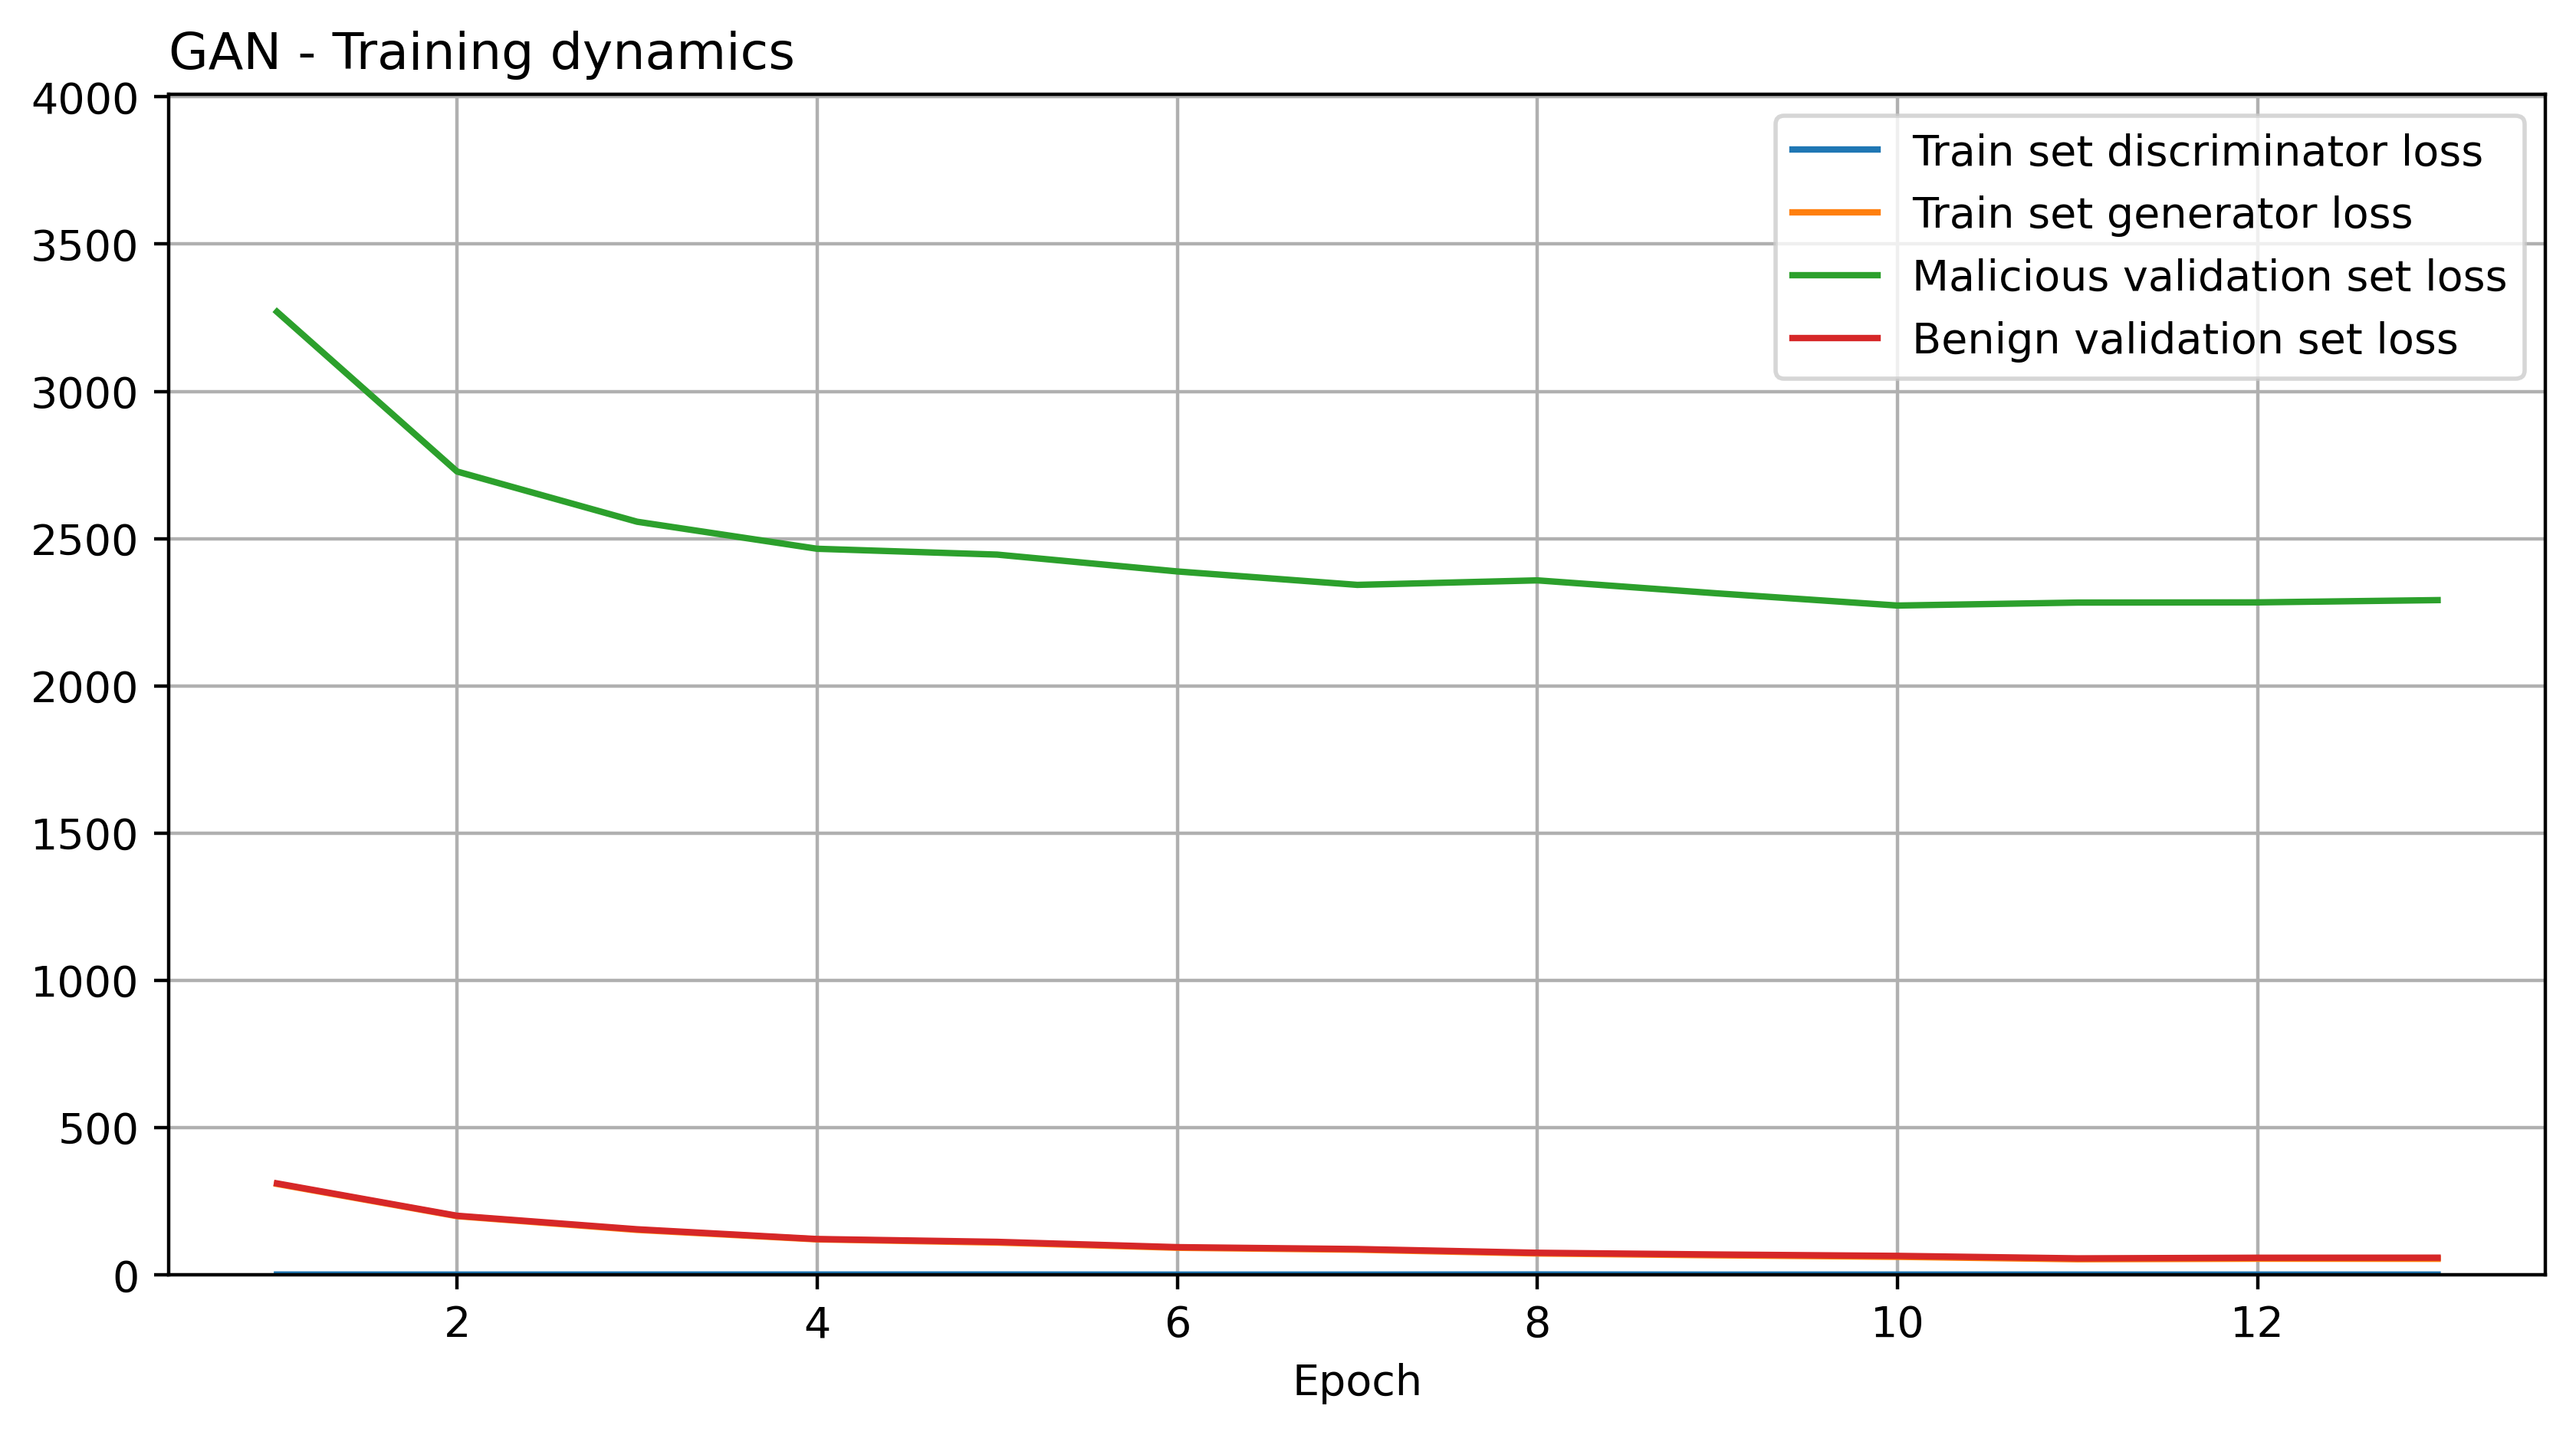

In [365]:
# Visualize training

fig = plt.figure(figsize = (10, 5), dpi = 400)

train_val, = plt.plot(val_epochs, training_val_Dlosses, label = 'Train set discriminator loss')
train_elbo, = plt.plot(val_epochs, training_val_Glosses, label = 'Train set generator loss')
val_malicious, = plt.plot(val_epochs, malicious_population_loss, label = 'Malicious validation set loss')
val_benign, = plt.plot(val_epochs, benign_population_loss, label = 'Benign validation set loss')
plt.legend(handles = [train_val, train_elbo, val_malicious, val_benign])

plt.xlabel('Epoch')
plt.grid(True)
plt.title('GAN - Training dynamics', loc = 'left')
plt.ylim(0, max(max(malicious_population_reconstruction), max(benign_population_reconstruction)) * 1.5)

fig.savefig('gan_training.png', dpi = 400)

fig.show()


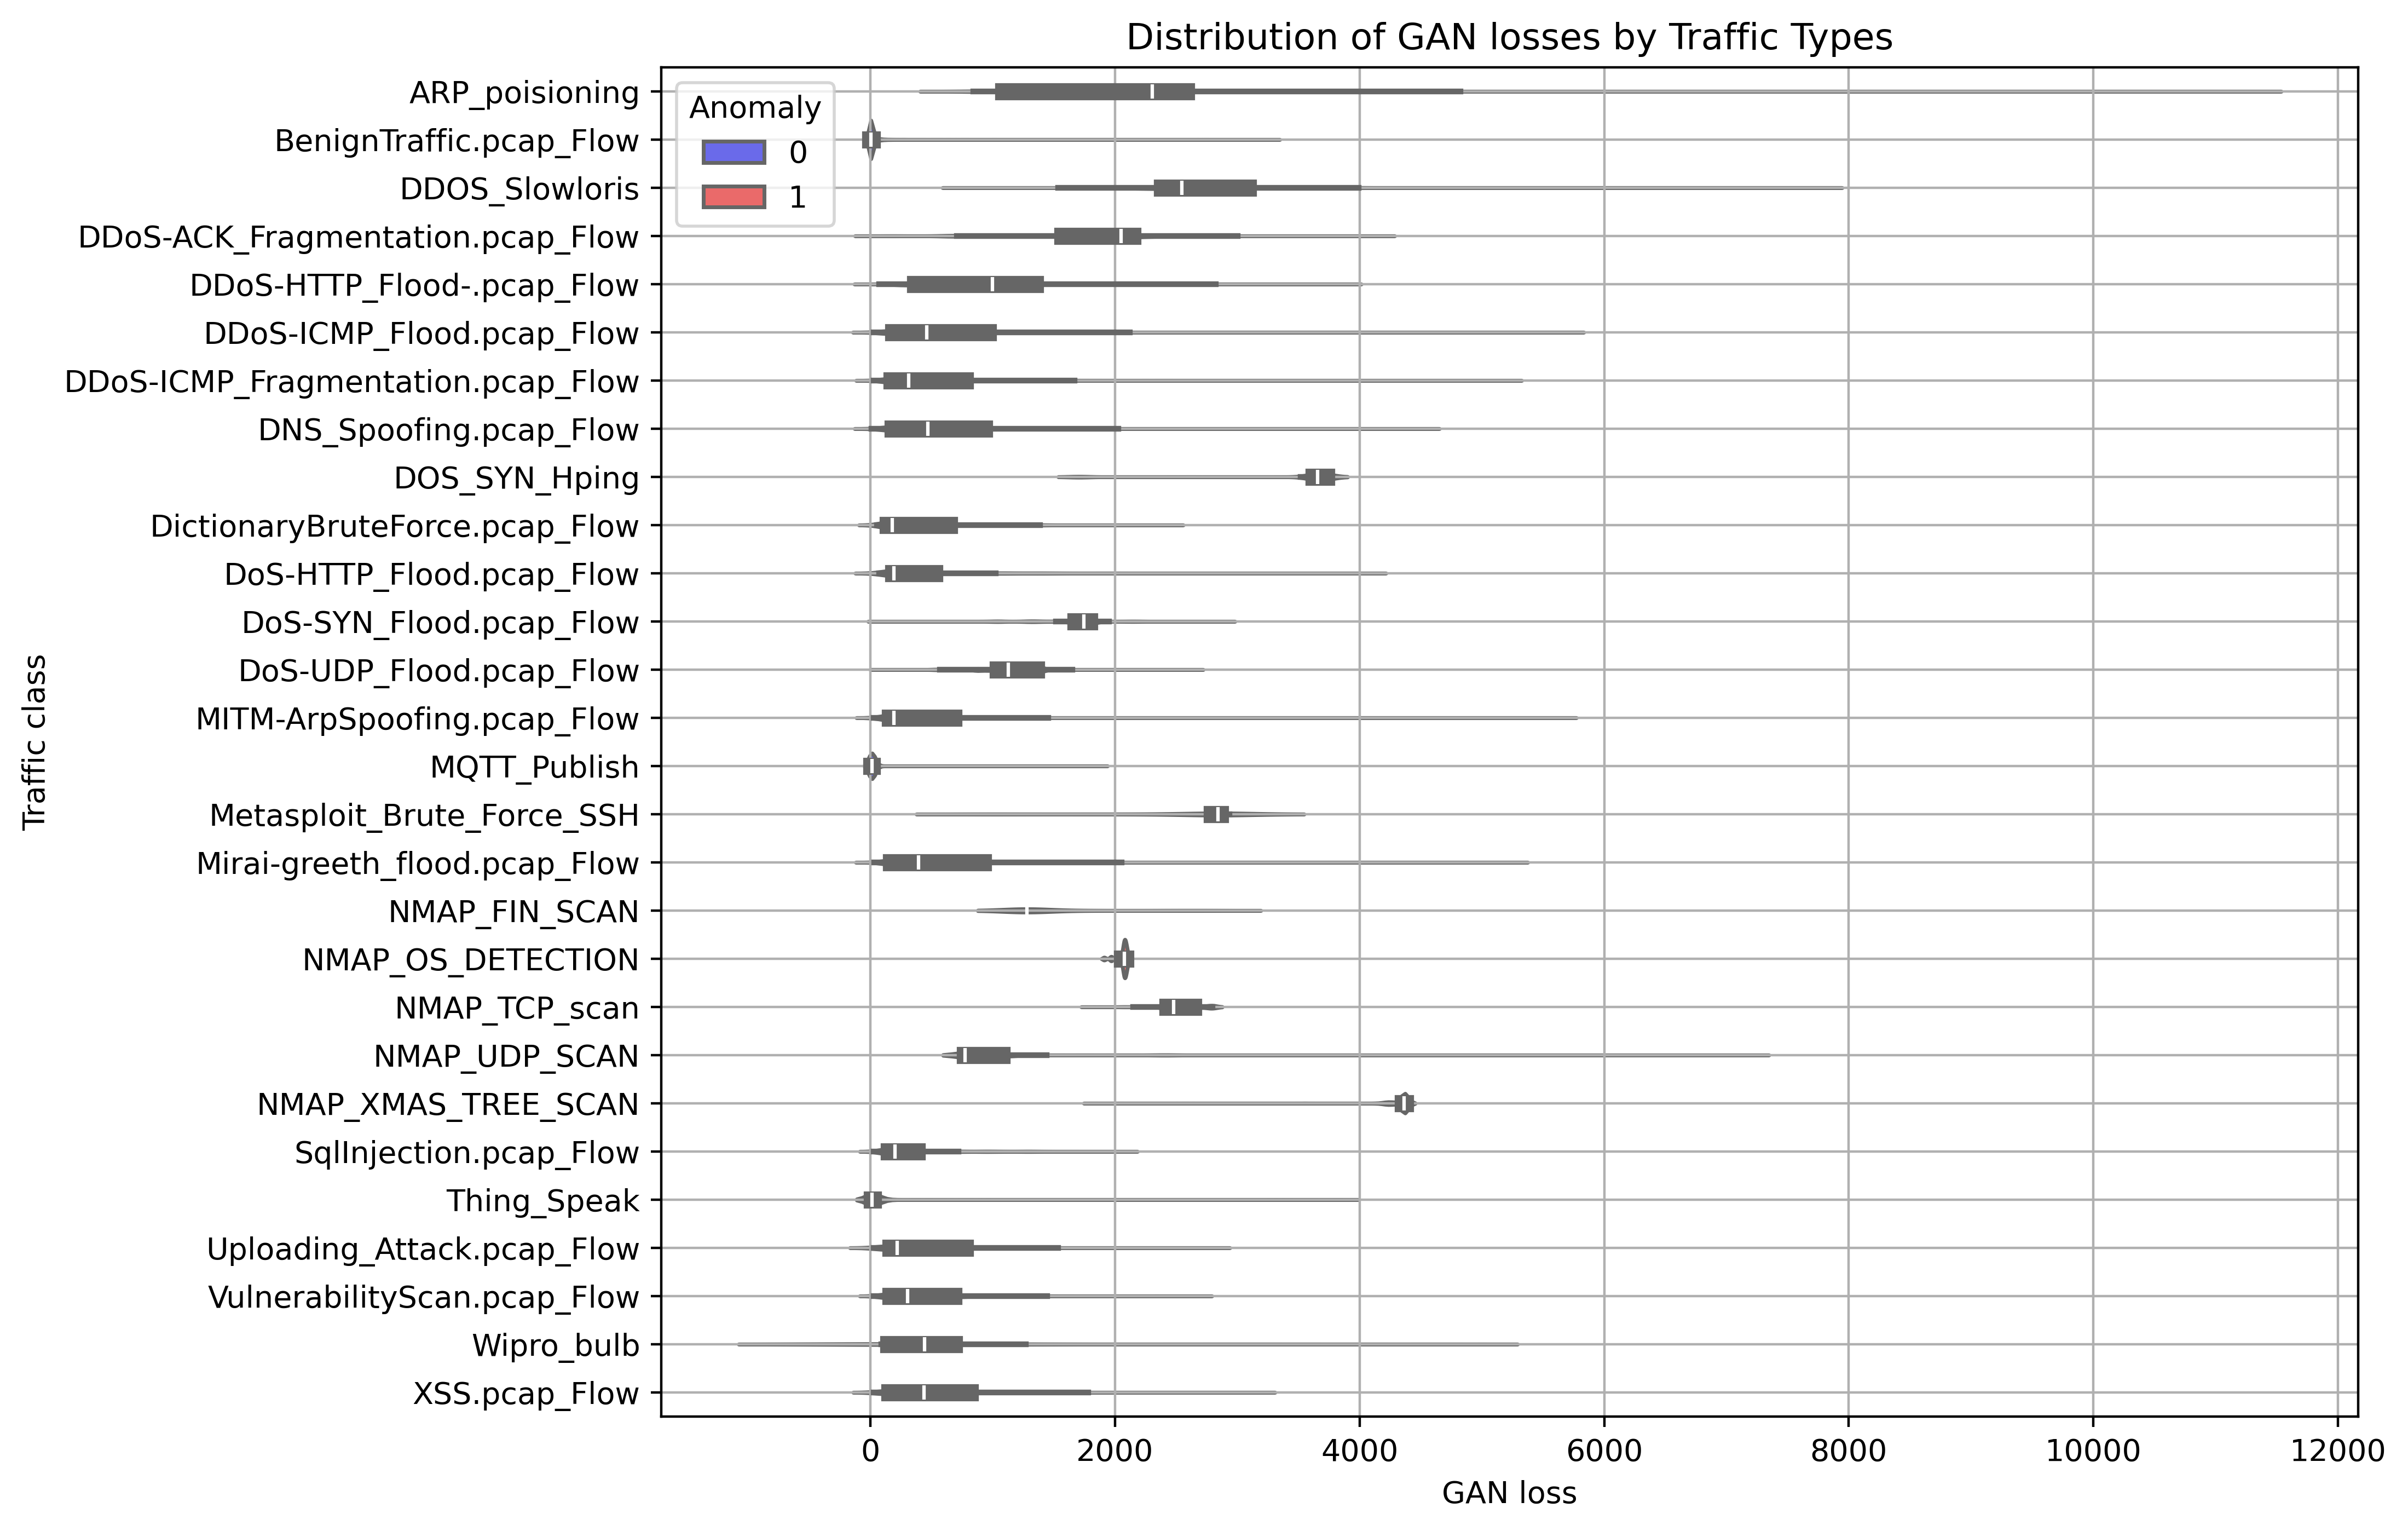

In [378]:
# Visualize validation reconstructon errors

lambda_recon = 0.5
lambda_latent = 1
lambda_adv = 0
lambda_dis = 1

use_pretrained = False

if use_pretrained:
    
    state_dict = torch.load(gan_file, weights_only = True, map_location = device).items()
    gan_model.load_state_dict(state_dict, strict = True)

gan_model.eval()

val_gan_losses = []
val_labels = []

val_dataset = TrafficDataset(data = iot_df_val.loc[:, train_column_names], condition = iot_df_val.loc[:, condition_column_names],
                                 unsupervised = False, labels = iot_df_val['Attack_type'])
val_loader = DataLoader(dataset = val_dataset,  batch_size = test_batch_size, shuffle = False)

with torch.no_grad():
    
    for val_batch_number, batch in enumerate(val_loader):
                
        # Model forward pass
    
        train_tensor = batch['training_data'].to(DEVICE)
        condition_tensor = batch['condition'].to(DEVICE)
        class_labels = batch['labels'].to(DEVICE)
    
        rec, z_latent, z_reconstr = gan_model(train_tensor, condition_tensor)
        real_d_score, real_hidden = gan_model.discriminate(train_tensor, condition_tensor)
        rec_d_score, rec_hidden = gan_model.discriminate(rec, condition_tensor)
    
        loss_dict = GANomaly_loss(
            x = train_tensor,
            x_hat = rec,
            z = z_latent,
            z_hat = z_reconstr,
            d_score = real_d_score,
            x_hidden = real_hidden,
            d_hat_score_G = rec_d_score,
            d_hat_score_D = rec_d_score,
            x_hat_hidden = rec_hidden,
            rec_fn = huber,
            d_mal_score = None,
            lambda_recon = lambda_recon, lambda_latent = lambda_latent,
            lambda_adv = lambda_adv, mal_penalty = mal_penalty, reduction = 'none')

        gan_losses = loss_dict['G_loss'] + loss_dict['D_real'] * lambda_dis

        val_gan_losses.extend(gan_losses.tolist())
        val_labels.extend(list(map(lambda x: val_dataset.index_label_mapping[x], class_labels.tolist())))

error_df = pd.DataFrame({
    'GAN loss' : val_gan_losses,
    'Traffic class' : val_labels})

error_df['Anomaly'] = (error_df['Traffic class'].isin([key for key, val in \
                            traffic_type_mapping.items() if val == 'Benign']) == False).astype('int8')

# Visualize 

fig = plt.figure(figsize = (10, 8), dpi = 400)

sns.violinplot(x = 'GAN loss', y = 'Traffic class', data = error_df,
                   palette = 'seismic', hue = 'Anomaly', orient = 'h')
plt.xlabel('GAN loss')
plt.ylabel('Traffic class')
plt.title('Distribution of GAN losses by Traffic Types')
plt.grid(True)

fig.savefig('gan_inference.png', dpi = 400, bbox_inches = 'tight')

plt.show()


Best Threshold: 107.228035
Best Balanced Accuracy: 0.9695
              precision    recall  f1-score   support

           0       0.90      0.96      0.93     41082
           1       0.99      0.98      0.98    190774

    accuracy                           0.97    231856
   macro avg       0.95      0.97      0.96    231856
weighted avg       0.98      0.97      0.98    231856



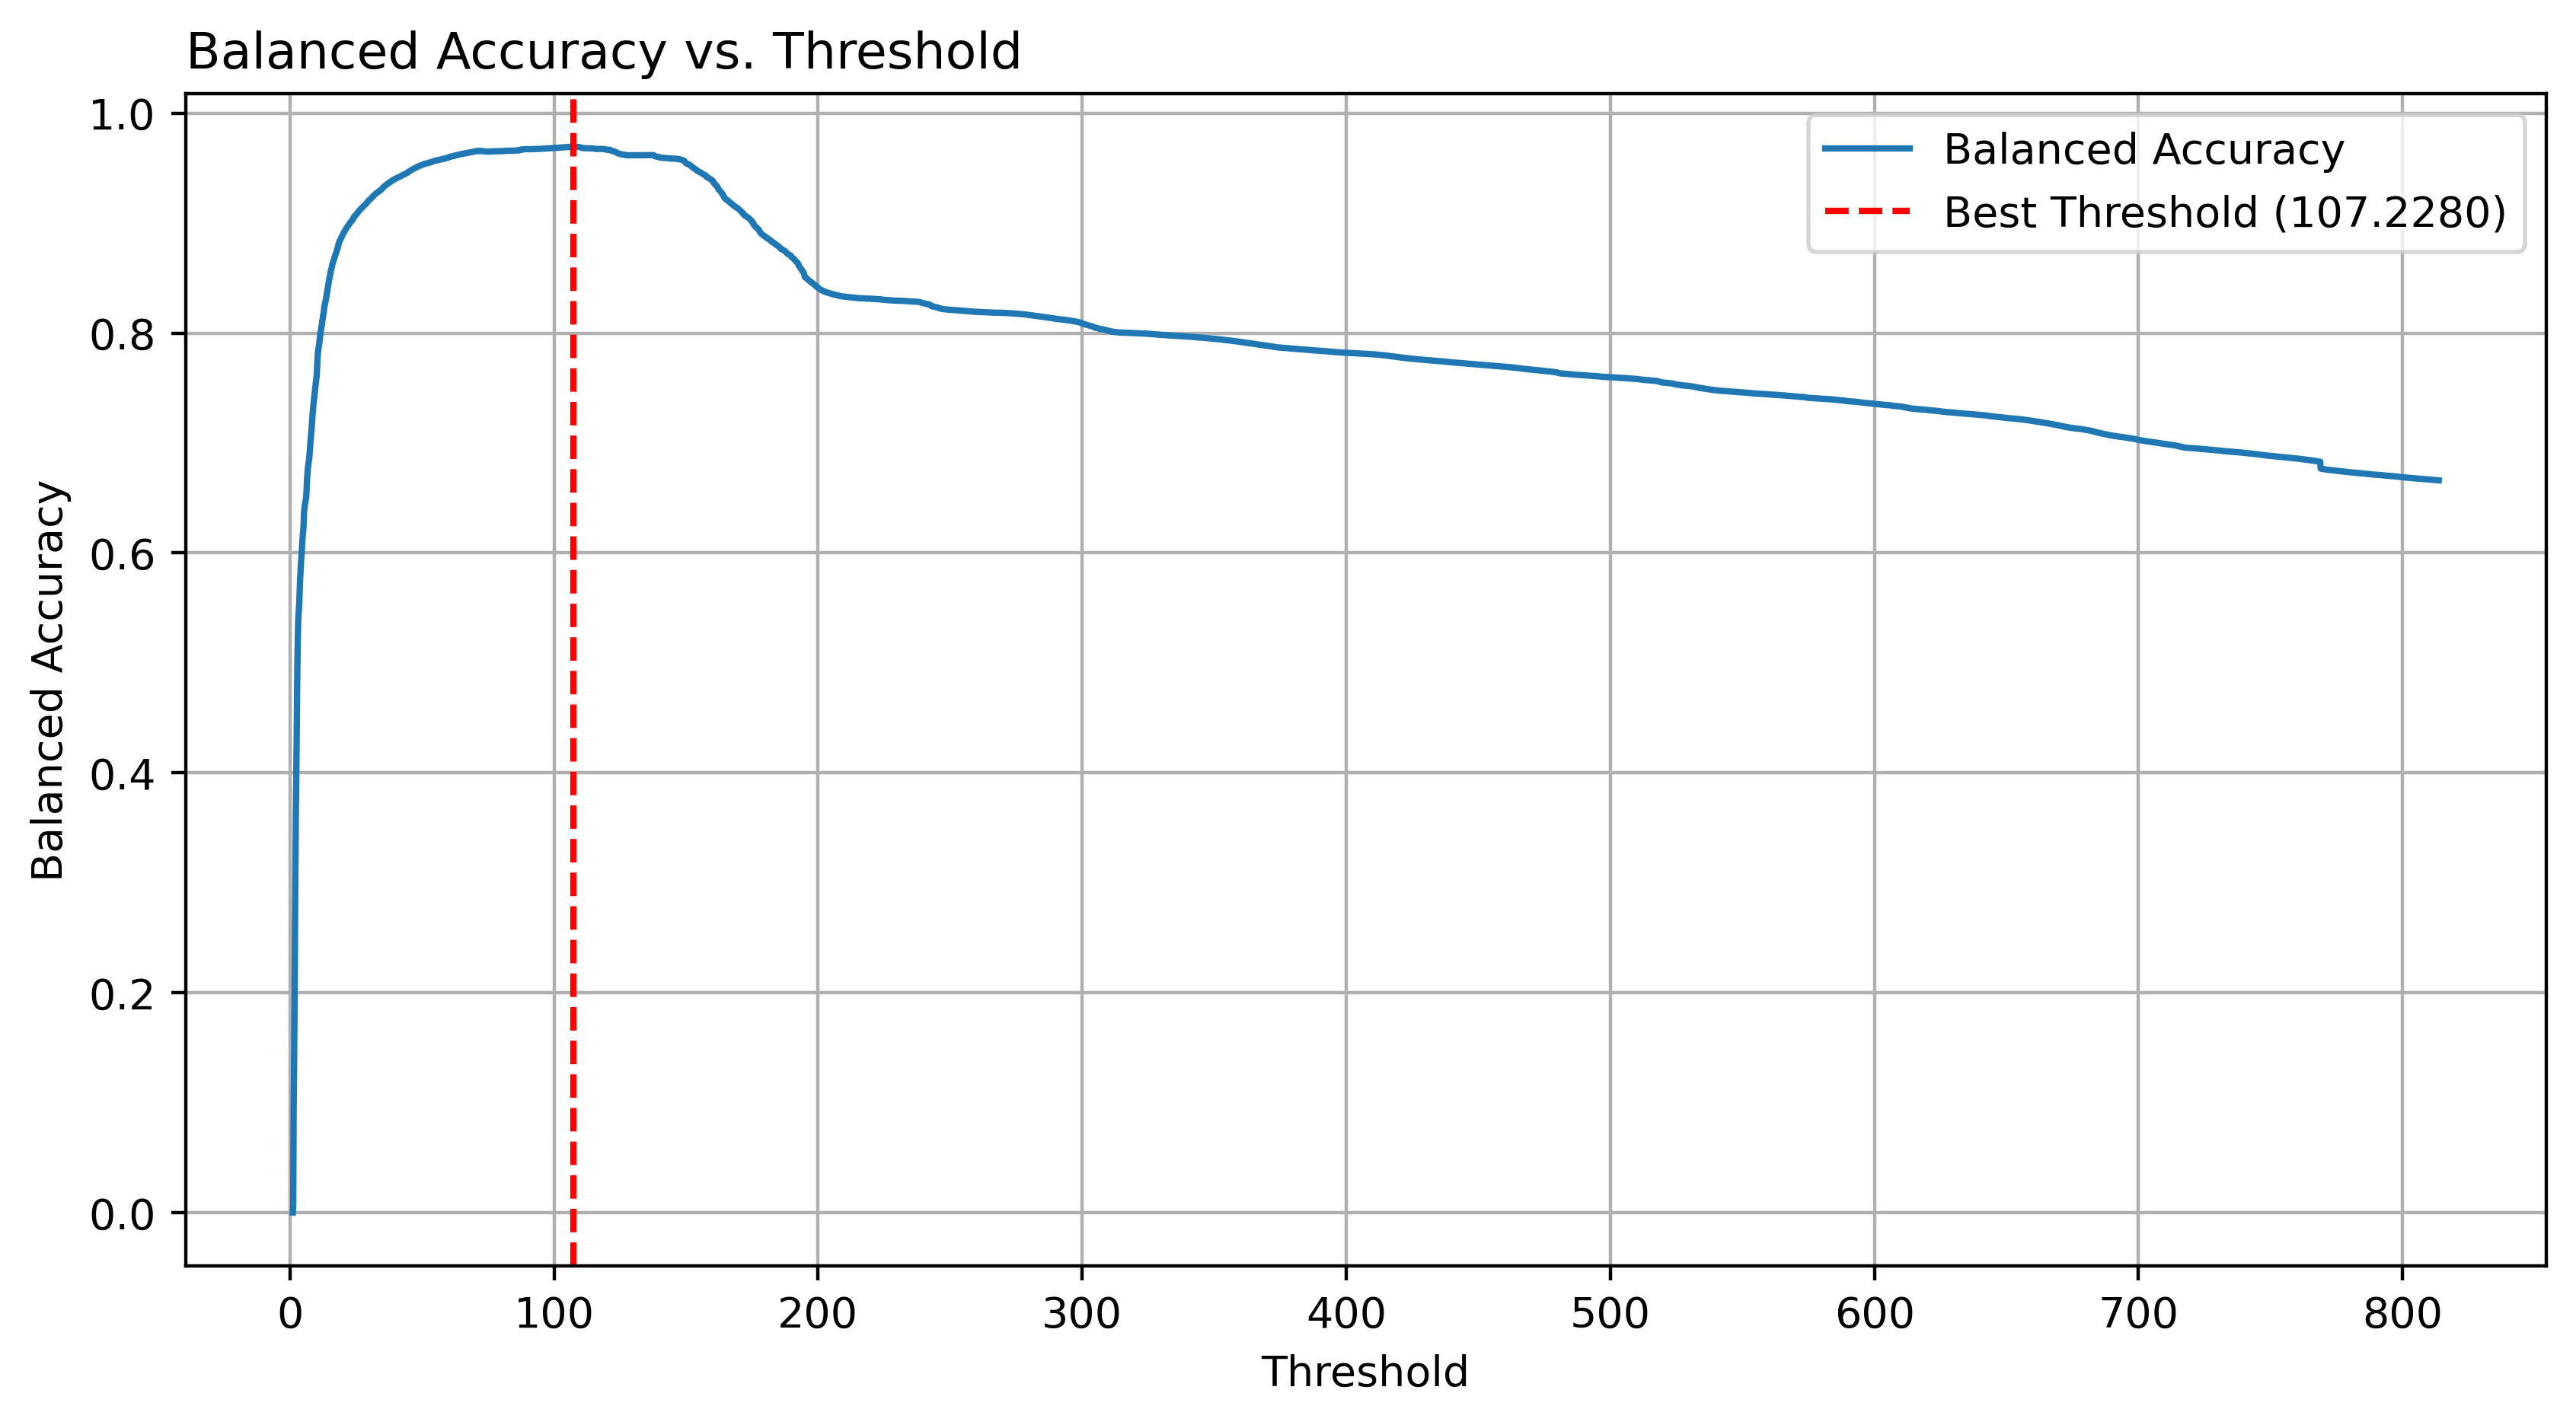

In [368]:
# Tune reconstruction thresholds

search_quantiles = (0, 0.5)

thresholds = np.linspace(
    error_df.loc[error_df['Anomaly'] == 0, 'GAN loss'].quantile(search_quantiles[0]),
    error_df.loc[error_df['Anomaly'] == 1, 'GAN loss'].quantile(search_quantiles[1]), 5000)

best_threshold = None
best_balanced_accuracy = -np.inf
benign_anomaly_tradeoff = 1

balanced_accuracies = []

for threshold in thresholds:
    
    y_pred = (error_df['GAN loss'] > threshold).astype(int)
    
    benign_mask = (error_df['Anomaly'] == 0)
    malicious_mask = (error_df['Anomaly'] == 1)
    
    benign_accuracy = (y_pred.loc[benign_mask] == error_df.loc[benign_mask, 'Anomaly']).mean()
    malicious_accuracy = (y_pred.loc[malicious_mask] == error_df.loc[malicious_mask, 'Anomaly']).mean()
    
    if benign_accuracy > 0 and malicious_accuracy > 0:
        balanced_acc = (1 + benign_anomaly_tradeoff) * (benign_accuracy * malicious_accuracy) / \
                       (benign_anomaly_tradeoff * malicious_accuracy + benign_accuracy)
    else:
        balanced_acc = 0
    
    balanced_accuracies.append(balanced_acc)
    
    if balanced_acc > best_balanced_accuracy:
        best_balanced_accuracy = balanced_acc
        best_threshold = threshold

print(f'Best Threshold: {best_threshold:.6f}')
print(f'Best Balanced Accuracy: {best_balanced_accuracy:.4f}')

error_df['Predicted anomaly'] = (error_df['GAN loss'] > best_threshold).astype(int)

print(classification_report(error_df['Anomaly'], error_df['Predicted anomaly']))

# Visualize performance
fig = plt.figure(figsize = (10, 5), dpi = 400)
plt.plot(thresholds, balanced_accuracies, label = 'Balanced Accuracy')
plt.axvline(x = best_threshold, color='red', linestyle = '--', label = f'Best Threshold ({best_threshold:.4f})')
plt.xlabel('Threshold')
plt.ylabel('Balanced Accuracy')
plt.title('Balanced Accuracy vs. Threshold', loc = 'left')
plt.legend()
plt.grid(True)

fig.savefig('gan_threshold.png', dpi = 400)

plt.show()


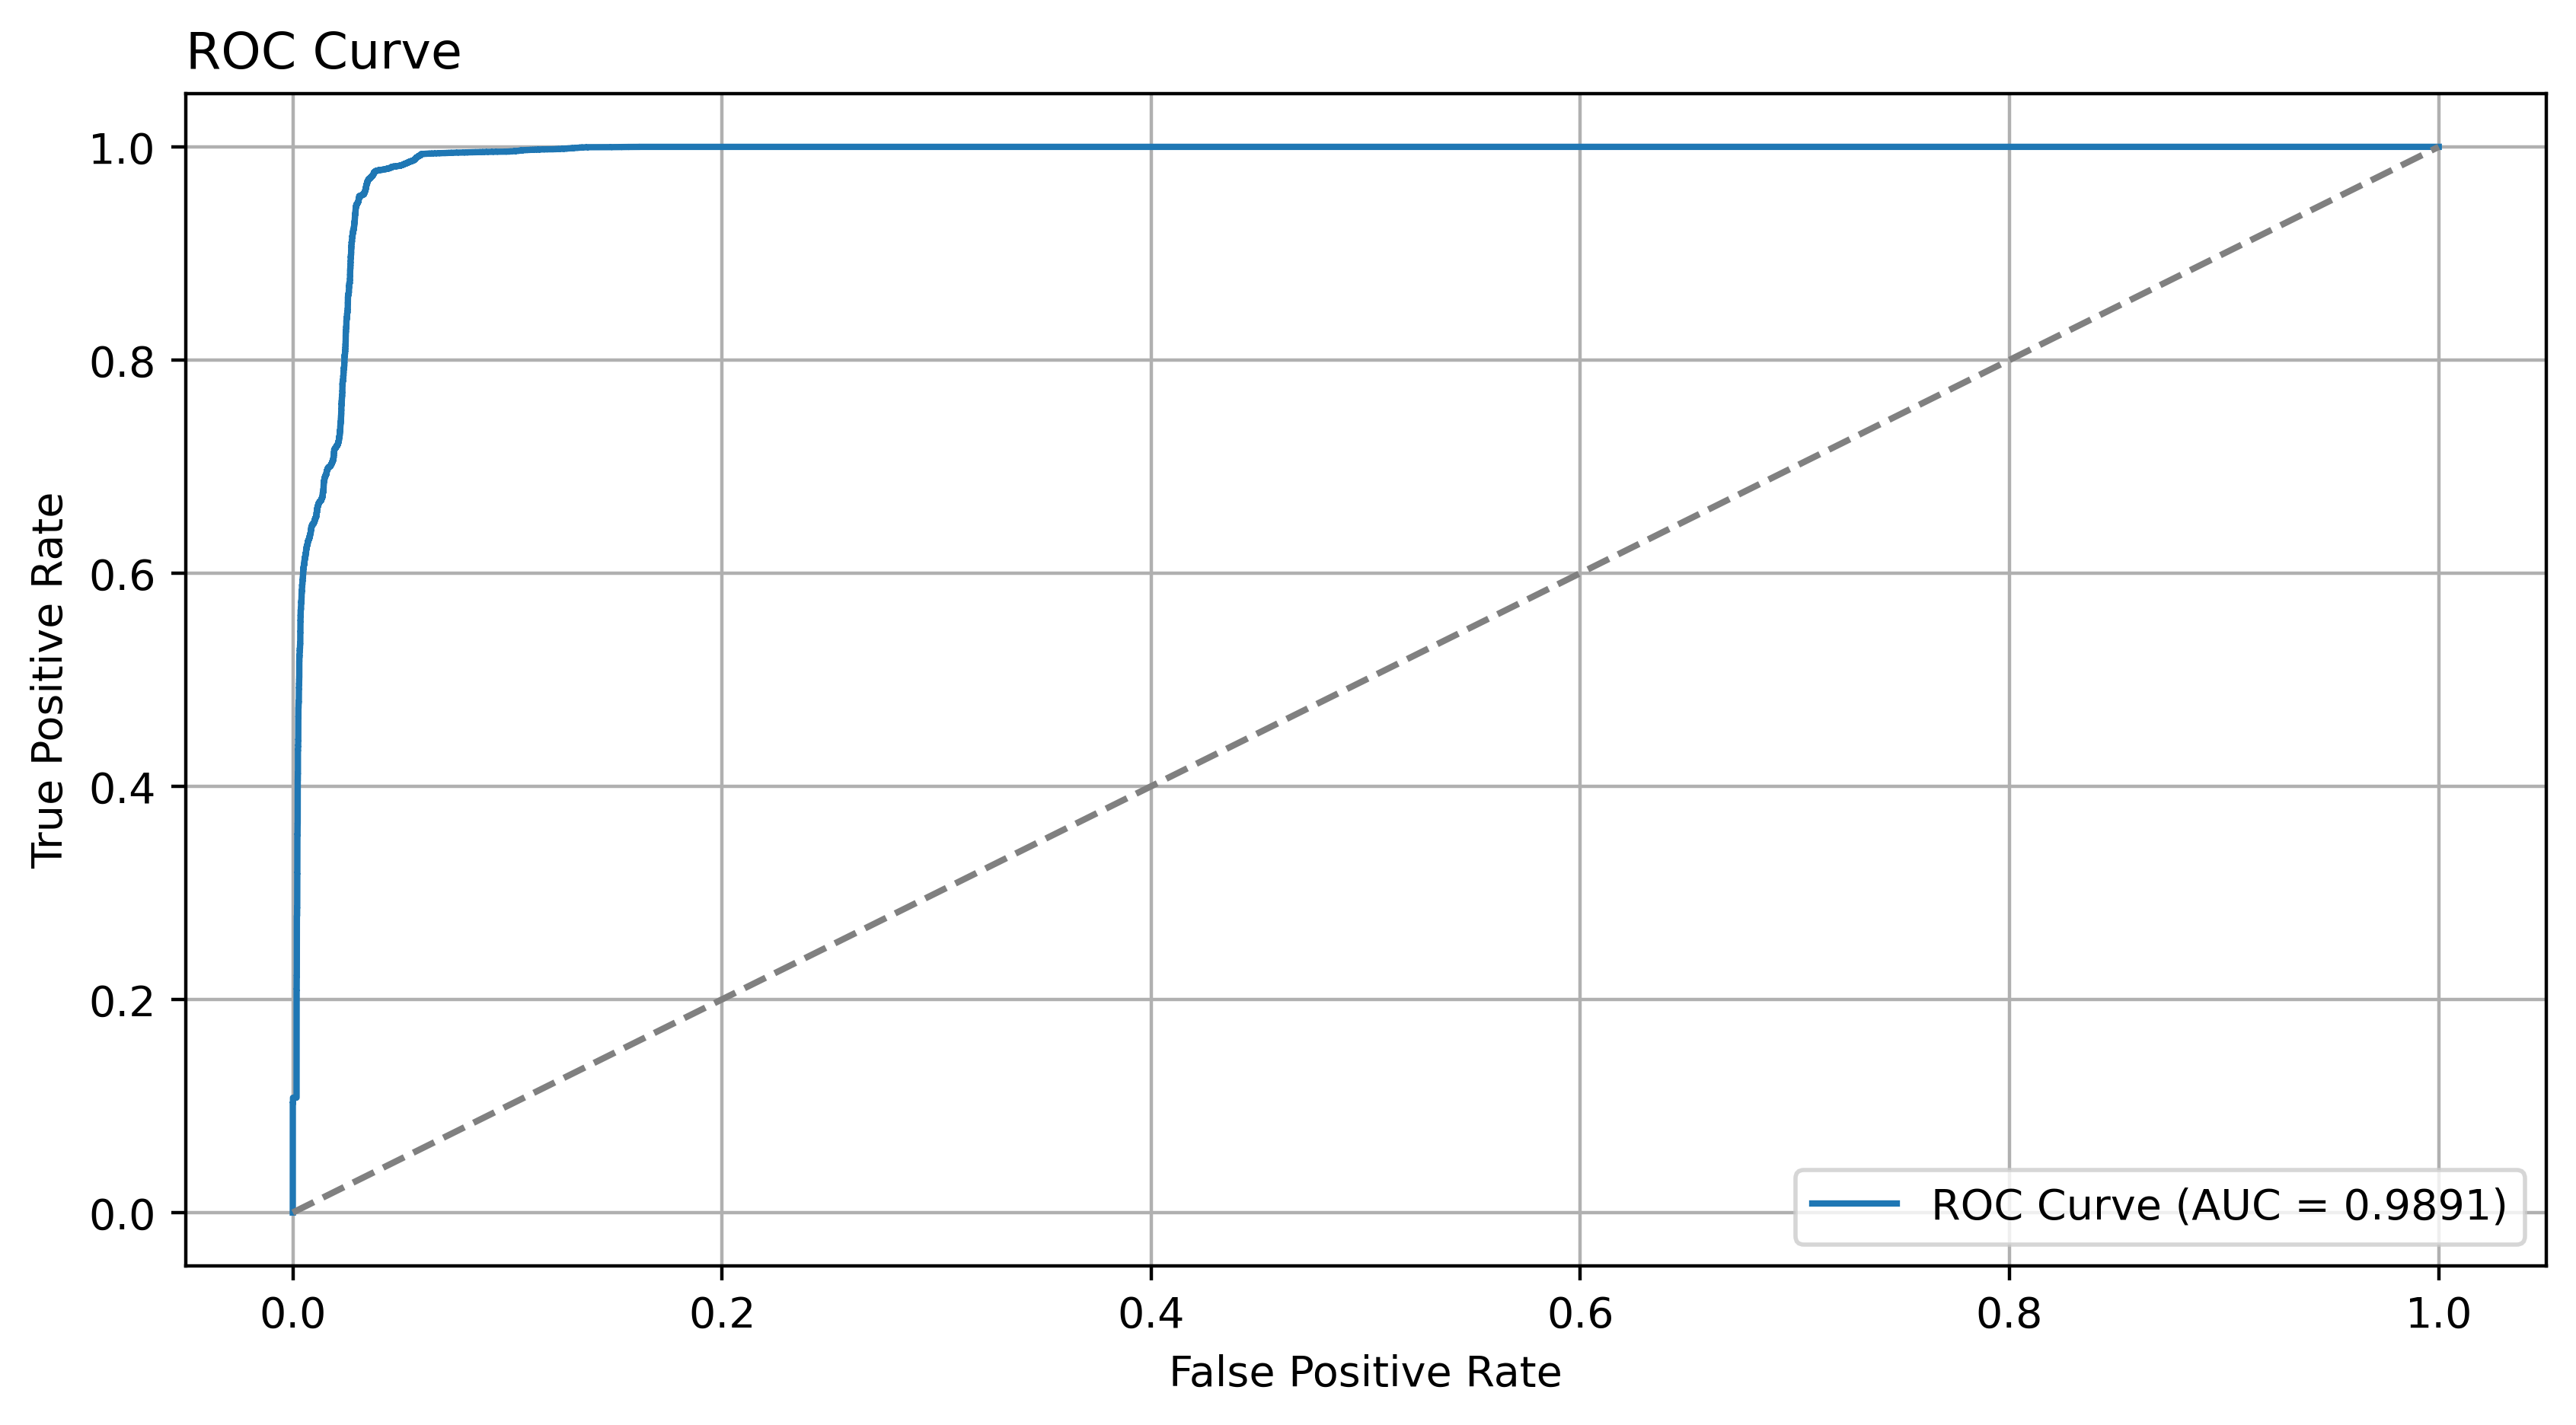

In [369]:
# ROC Curve

balanced_error_df = error_df.sample(n = 200000, replace = True,
        weights = 1 / error_df.groupby('Anomaly')['Predicted anomaly'].transform('count'))

fpr, tpr, _ = roc_curve(balanced_error_df['Anomaly'], balanced_error_df['GAN loss'])
roc_auc = auc(fpr, tpr)

fig = plt.figure(figsize = (10, 5), dpi = 400)
plt.plot(fpr, tpr, label = f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0,1], [0,1], linestyle = '--', color = 'gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve', loc = 'left')
plt.legend()
plt.grid(True)

fig.savefig('gan_roc.png', dpi = 400)

plt.show()

In [339]:
# Save the model

torch.save(gan_model.state_dict(), vae_file)

## Generative Modelling - Diffusion

In [380]:
# Model parameters

use_gpu = True
use_pretrained = False

vae_file = 'diffusion_traffic_model.pth'

DEVICE = torch.device('mps' if torch.mps.is_available() and use_gpu else ('cuda' if torch.cuda.is_available() and use_gpu else 'cpu'))

train_column_names = [col for col in iot_df.select_dtypes(include = [np.number]).columns \
                          if not col.startswith(('proto_', 'service_')) and col not in ['Attack_type_l']]
condition_column_names = [col for col in iot_df.columns if col.startswith('proto_') or col.startswith('is_')]

x_dim = len(train_column_names)
cond_dim = len(condition_column_names)
data_range_factor = 1.5

decoder_hidden_dim = 256
time_embed_dim = 24

batch_size = 124
test_batch_size = batch_size * 2

In [ ]:
normal_val_share = 0.1

# Data loading preparation

class TrafficDataset(Dataset):

    def __init__(self, data, condition, training = True, labels = None):

        self.train_data = data.values
        self.condition = condition.values

        self.train_data_features = list(data.columns)
        self.condition_features = list(condition.columns)

        self.training = training

        if not self.training:
            
            self.label_index_mapping = {label : i for i, label in enumerate(labels.unique())}
            self.index_label_mapping = {i : label for label, i in self.label_index_mapping.items()}
            self.traffic_labels = labels.map(self.label_index_mapping).values

    def __len__(self):
        return self.train_data.shape[0]

    def __getitem__(self, idx):

        training_example = self.train_data[idx]
        conditioning = self.condition[idx]
        class_labels = None if self.training else self.traffic_labels[idx]

        item = {'training_data': torch.tensor(training_example, dtype = torch.float32),
                'condition' : torch.tensor(conditioning, dtype = torch.float32),
                'labels' : torch.tensor(class_labels, dtype = torch.long) if class_labels is not None else \
                            torch.zeros(1, dtype = torch.long)}

        return item


# Validation set

iot_df_val = \
    iot_df.groupby('Attack_type', group_keys = False, observed = True) \
        .apply(lambda x: x.assign(Attack_type = x.name).sample(x.shape[0] if x.name not in \
            [key for key, value in traffic_type_mapping.items() if value == 'Benign'] \
                else int(x.shape[0] * normal_val_share), replace = False), include_groups = False)

# Data loader definition

train_dataset = TrafficDataset(data = iot_df.loc[~iot_df['ID'].isin(iot_df_val['ID'].to_list()), train_column_names],
                                condition = iot_df.loc[~iot_df['ID'].isin(iot_df_val['ID'].to_list()), condition_column_names],
                                    training = True)
val_dataset = TrafficDataset(data = iot_df_val.loc[:, train_column_names], condition = iot_df_val.loc[:, condition_column_names],
                                 training = False, labels = iot_df_val['Traffic_type'])

train_loader = DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle = True)
val_loader = DataLoader(dataset = val_dataset,  batch_size = test_batch_size, shuffle = False)

In [ ]:
# Model definition

class SinusoidalTimeEmbedding(nn.Module):
    
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, t):
        
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device = t.device) * -emb)
        emb = t[:, None].float() * emb[None, :]
        emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim = -1)
        
        return emb

class ConditionalDiffusionModel(nn.Module):
    
    def __init__(self, input_dim, cond_dim, hidden_dim, time_emb_dim):
        super(ConditionalDiffusionModel, self).__init__()

        self.input_dim = input_dim
        self.cond_dim = cond_dim
        self.timesteps = timesteps

        self.time_embed = SinusoidalTimeEmbedding(time_emb_dim)

        self.denoise_network = nn.Sequential(
            nn.Linear(input_dim + cond_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim))
    
    def forward(self, x, cond, t):
        
        # Embed time
        t_emb = self.time_embed(t)
        
        # Conditioned noise prediction
        x_cond = torch.cat([x, cond, t_emb], dim = -1)

        # Denoising function
        epsilon_pred = self.denoise_network(x_cond)

        return epsilon_pred

class GaussianDiffusion:
    
    def __init__(self, model, timesteps = 1000, beta_start = 1e-4, beta_end = 0.02):
        
        self.model = model
        self.timesteps = timesteps
        self.device = next(model.parameters()).device

        self.betas = torch.linspace(beta_start, beta_end, timesteps).to(self.device)
        self.alphas = 1.0 - self.betas
        self.alpha_cumprod = torch.cumprod(self.alphas, dim = 0)

    def q_sample(self, x_start, t, noise = None):
        
        if noise is None:
            noise = torch.randn_like(x_start)

        sqrt_alpha_cumprod = self.alpha_cumprod[t].sqrt().unsqueeze(1)
        sqrt_one_minus_alpha_cumprod = (1 - self.alpha_cumprod[t]).sqrt().unsqueeze(1)
        
        return sqrt_alpha_cumprod * x_start + sqrt_one_minus_alpha_cumprod * noise

    def p_losses(self, x_start, t):
        
        noise = torch.randn_like(x_start)
        x_noisy = self.q_sample(x_start, t, noise)
        predicted_noise = self.model(x_noisy, t)
        
        return nn.functional.mse_loss(predicted_noise, noise)
        

In [ ]:
# Training loop

denoizer = ConditionalDiffusionModel(x_dim, cond_dim, decoder_hidden_dim, time_emb_dim)
diffusion_model = GaussianDiffusion(denoizer, timesteps = 1000)

optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)
epochs = 20

model.train()
mse = nn.MSELoss()

for epoch in range(epochs):
    
    train_loss = 0.0
    model.train()
        
    for x, _ in train_loader:
        x = x.to(diffusion.device)
        t = torch.randint(0, diffusion.timesteps, (x.size(0),), device=diffusion.device)
        
        loss = diffusion.p_losses(x, t)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * x.size(0)

    avg_train_loss = train_loss / len(train_loader.dataset)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for x_val, _ in val_loader:
            
            x_val = x_val.to(diffusion.device)
            t_val = torch.randint(0, diffusion.timesteps, (x_val.size(0),), device=diffusion.device)
            loss_val = diffusion.p_losses(x_val, t_val)
            val_loss += loss_val.item() * x_val.size(0)

    avg_val_loss = val_loss / len(val_loader.dataset)

    print(f"Epoch {epoch + 1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")


In [ ]:
# Validation inference

model.eval()
reconstruction_errors = []
labels = []

with torch.no_grad():
    for x, class_labels in data_loader:
        
        x = x.to(diffusion.device)
        B = x.size(0)
        t = torch.full((B,), diffusion.timesteps - 1, device = diffusion.model.device)

        noise = torch.randn_like(x)
        x_noisy = diffusion.q_sample(x, t, noise = noise)

        predicted_noise = diffusion.model(x_noisy, t)

        sqrt_alpha_cumprod = diffusion.alpha_cumprod[t].sqrt().unsqueeze(1)
        sqrt_one_minus_alpha_cumprod = (1 - diffusion.alpha_cumprod[t]).sqrt().unsqueeze(1)

        # Reconstruct x from noise
        x_reconstructed = (x_noisy - sqrt_one_minus_alpha_cumprod * predicted_noise) / sqrt_alpha_cumprod

        # MSE per sample
        errors = ((x - x_reconstructed) ** 2).mean(dim = 1)

        reconstruction_errors.extend(errors.cpu().tolist())
        labels.extend([dataset.index_label_mapping[int(lbl)] for lbl in class_labels])

# Create DataFrame

error_df = pd.DataFrame({
    'Reconstruction error': reconstruction_errors,
    'Traffic class': labels})

error_df['Anomaly'] = (~error_df['Traffic class'].isin(
    [key for key, val in traffic_type_mapping.items() if val == 'Benign'])).astype('int8')

# Visualize 

fig = plt.figure(figsize = (10, 8), dpi = 400)

sns.violinplot(x = 'Reconstruction error', y = 'Traffic class', data = error_df,
                   palette = 'seismic', hue = 'Anomaly', orient = 'h')
plt.xlabel('Reconstruction error')
plt.ylabel('Traffic class')
plt.title('Distribution of Reconstruction Errors by Traffic Types')
plt.grid(True)

fig.savefig('vae_inference.png', dpi = 400, bbox_inches = 'tight')

plt.show()


In [ ]:
# Tune reconstruction thresholds

search_quantiles = (0, 0.5)

thresholds = np.linspace(
    error_df.loc[error_df['Anomaly'] == 0, 'Reconstruction error'].quantile(search_quantiles[0]),
    error_df.loc[error_df['Anomaly'] == 1, 'Reconstruction error'].quantile(search_quantiles[1]), 5000)

best_threshold = None
best_balanced_accuracy = -np.inf
benign_anomaly_tradeoff = 1

balanced_accuracies = []

for threshold in thresholds:
    
    y_pred = (error_df['Reconstruction error'] > threshold).astype(int)
    
    benign_mask = (error_df['Anomaly'] == 0)
    malicious_mask = (error_df['Anomaly'] == 1)
    
    benign_accuracy = (y_pred.loc[benign_mask] == error_df.loc[benign_mask, 'Anomaly']).mean()
    malicious_accuracy = (y_pred.loc[malicious_mask] == error_df.loc[malicious_mask, 'Anomaly']).mean()
    
    if benign_accuracy > 0 and malicious_accuracy > 0:
        balanced_acc = (1 + benign_anomaly_tradeoff) * (benign_accuracy * malicious_accuracy) / \
                       (benign_anomaly_tradeoff * malicious_accuracy + benign_accuracy)
    else:
        balanced_acc = 0
    
    balanced_accuracies.append(balanced_acc)
    
    if balanced_acc > best_balanced_accuracy:
        best_balanced_accuracy = balanced_acc
        best_threshold = threshold

print(f'Best Threshold: {best_threshold:.6f}')
print(f'Best Balanced Accuracy: {best_balanced_accuracy:.4f}')

error_df['Predicted anomaly'] = (error_df['Reconstruction error'] > best_threshold).astype(int)

print(classification_report(error_df['Anomaly'], error_df['Predicted anomaly']))

# Visualize performance
fig = plt.figure(figsize = (10, 5), dpi = 400)
plt.plot(thresholds, balanced_accuracies, label = 'Balanced Accuracy')
plt.axvline(x = best_threshold, color='red', linestyle = '--', label = f'Best Threshold ({best_threshold:.4f})')
plt.xlabel('Threshold')
plt.ylabel('Balanced Accuracy')
plt.title('Balanced Accuracy vs. Threshold', loc = 'left')
plt.legend()
plt.grid(True)

fig.savefig('diffusion_threshold.png', dpi = 400)

plt.show()


## Generative Modelling - Normalizing flows

In [457]:
# Model parameters

use_gpu = True
use_pretrained = False

vae_file = 'normalizing_flows_traffic_model.pth'

DEVICE = torch.device('mps' if torch.mps.is_available() and use_gpu else ('cuda' if torch.cuda.is_available() and use_gpu else 'cpu'))

train_column_names = [col for col in iot_df.select_dtypes(include = [np.number]).columns \
                          if not col.startswith(('proto_', 'service_')) and col not in ['Attack_type_l']]
condition_column_names = [col for col in iot_df.columns if col.startswith('proto_') or col.startswith('is_')]

x_dim = len(train_column_names)
cond_dim = len(condition_column_names)
data_range_factor = 1.5

coupling_hidden_dim = 256
n_coupling_layers = 5

batch_size = 124
test_batch_size = batch_size * 2

In [487]:
normal_val_share = 0.1

# Data loading preparation

class TrafficDataset(Dataset):

    def __init__(self, data, condition, training = True, labels = None):

        self.train_data = data.values
        self.condition = condition.values

        self.train_data_features = list(data.columns)
        self.condition_features = list(condition.columns)

        self.training = training

        if not self.training:
            
            self.label_index_mapping = {label : i for i, label in enumerate(labels.unique())}
            self.index_label_mapping = {i : label for label, i in self.label_index_mapping.items()}
            self.traffic_labels = labels.map(self.label_index_mapping).values

    def __len__(self):
        return self.train_data.shape[0]

    def __getitem__(self, idx):

        training_example = self.train_data[idx]
        conditioning = self.condition[idx]
        class_labels = None if self.training else self.traffic_labels[idx]

        item = {'training_data': torch.tensor(training_example, dtype = torch.float32),
                'condition' : torch.tensor(conditioning, dtype = torch.float32),
                'labels' : torch.tensor(class_labels, dtype = torch.long) if class_labels is not None else \
                            torch.zeros(1, dtype = torch.long)}

        return item


# Validation set

iot_df_val = \
    iot_df.groupby('Attack_type', group_keys = False, observed = True) \
        .apply(lambda x: x.assign(Attack_type = x.name).sample(x.shape[0] if x.name not in \
            [key for key, value in traffic_type_mapping.items() if value == 'Benign'] \
                else int(x.shape[0] * normal_val_share), replace = False), include_groups = False)

# Data loader definition

train_dataset = TrafficDataset(data = iot_df.loc[~iot_df['ID'].isin(iot_df_val['ID'].to_list()), train_column_names],
                                condition = iot_df.loc[~iot_df['ID'].isin(iot_df_val['ID'].to_list()), condition_column_names],
                                    training = True)
val_dataset = TrafficDataset(data = iot_df_val.loc[:, train_column_names], condition = iot_df_val.loc[:, condition_column_names],
                                 training = False, labels = iot_df_val['Attack_type'])

train_loader = DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle = True)
val_loader = DataLoader(dataset = val_dataset,  batch_size = test_batch_size, shuffle = False)


In [462]:
# Model Definition

class ConditionalAffineCouplingLayer(nn.Module):
    
    def __init__(self, input_dim, cond_dim, hidden_dim):
        
        super().__init__()
        
        self.input_dim = input_dim
        self.cond_dim = cond_dim

        self.net = nn.Sequential(
            nn.Linear((self.input_dim // 2) + cond_dim if (self.input_dim // 2) == 0 \
                         else (self.input_dim // 2) + cond_dim + 1, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, self.input_dim if (self.input_dim // 2) == 0 \
                         else self.input_dim - 1))

    def forward(self, x, cond):
        
        x_a, x_b = x.chunk(2, dim=-1)
        x_input = torch.cat([x_a, cond], dim=-1)

        st = self.net(x_input)
        s, t = st.chunk(2, dim=-1)
        
        x_b_trans = x_b * torch.exp(s) + t
        
        return torch.cat([x_a, x_b_trans], dim=-1), s, t

    def inverse(self, y, cond):
        
        y_a, y_b = y.chunk(2, dim=-1)
        y_input = torch.cat([y_a, cond], dim=-1)

        st = self.net(y_input)
        s, t = st.chunk(2, dim=-1)

        x_b = (y_b - t) * torch.exp(-s)
        
        return torch.cat([y_a, x_b], dim=-1)


class ConditionalNormalizingFlow(nn.Module):
    
    def __init__(self, input_dim, cond_dim, hidden_dim, num_layers):
        
        super().__init__()
        
        self.layers = nn.ModuleList([
            ConditionalAffineCouplingLayer(input_dim, cond_dim, hidden_dim)
            for _ in range(num_layers)])

    def forward(self, x, cond):
        
        log_det = 0
        for layer in self.layers:
            x, s, t = layer(x, cond)
            log_det += s.sum(dim=-1)
            
        return x, log_det

    def inverse(self, z, cond):
        
        for layer in reversed(self.layers):
            z = layer.inverse(z, cond)
            
        return z


norm_flows_model = ConditionalNormalizingFlow(x_dim, cond_dim, coupling_hidden_dim, n_coupling_layers).to(DEVICE)

In [463]:
# Define loss function

class GaussianPrior(torch.distributions.Normal):
    
    def __init__(self, dim, mean = 0., std = 1.):
        super(GaussianPrior, self).__init__(loc = torch.full((dim,), mean, device = DEVICE),
                                              scale = torch.full((dim,), std, device  = DEVICE))

def nll_loss(model, x, cond, prior_distribution):

    z, log_det = model(x, cond)
    
    # Log likelihood is the sum of log p(z) and log |det(J)|
    log_p_z = prior_distribution.log_prob(z).sum(dim = -1)
    
    return -torch.mean(log_p_z + log_det)

optimizer = optim.Adam(norm_flows_model.parameters(), lr = 1e-4, weight_decay = weight_decay)
prior_distribution = GaussianPrior(x_dim)


In [471]:
train_losses = []
val_losses = []
val_error_dfs = []

num_epochs = 10

for epoch in range(num_epochs):
    
    norm_flows_model.train()
    epoch_loss = 0

    # Training

    for batch in train_loader:

        x_batch, cond_batch, _ = batch.values()
        x_batch = x_batch.to(DEVICE)
        cond_batch = cond_batch.to(DEVICE)

        # Forward pass and NLL loss
        
        loss = nll_loss(model = norm_flows_model, x = x_batch, cond = cond_batch, prior_distribution = prior_distribution)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_train_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f"[Epoch {epoch + 1}] Train NLL Loss = {avg_train_loss:.4f}")

    # Validation
    norm_flows_model.eval()
    val_ll = []
    val_cls = []

    with torch.no_grad():
        
        for batch in val_loader:

            x_batch, cond_batch, class_labels = batch.values()
            
            x_batch = x_batch.to(DEVICE)
            cond_batch = cond_batch.to(DEVICE)

            z, log_det = norm_flows_model(x_batch, cond_batch)
            log_p_z = prior_distribution.log_prob(z).sum(dim=-1)
            total_ll = log_p_z + log_det
            val_ll.extend((-total_ll).cpu().tolist())  # Negative log-likelihood
            val_cls.extend([val_dataset.index_label_mapping[c.item()] for c in class_labels])

    error_df = pd.DataFrame({
        'Reconstruction error': val_ll,
        'Traffic class': val_cls
    })

    error_df['Anomaly'] = (~error_df['Traffic class'].isin([
        key for key, val in traffic_type_mapping.items() if val == 'Benign'
    ])).astype('int8')

    val_error_dfs.append(error_df)
    val_loss = error_df['Reconstruction error'].mean()
    val_losses.append(val_loss)
    print(f"[Epoch {epoch + 1}] Validation NLL Loss = {val_loss:.4f}")
    

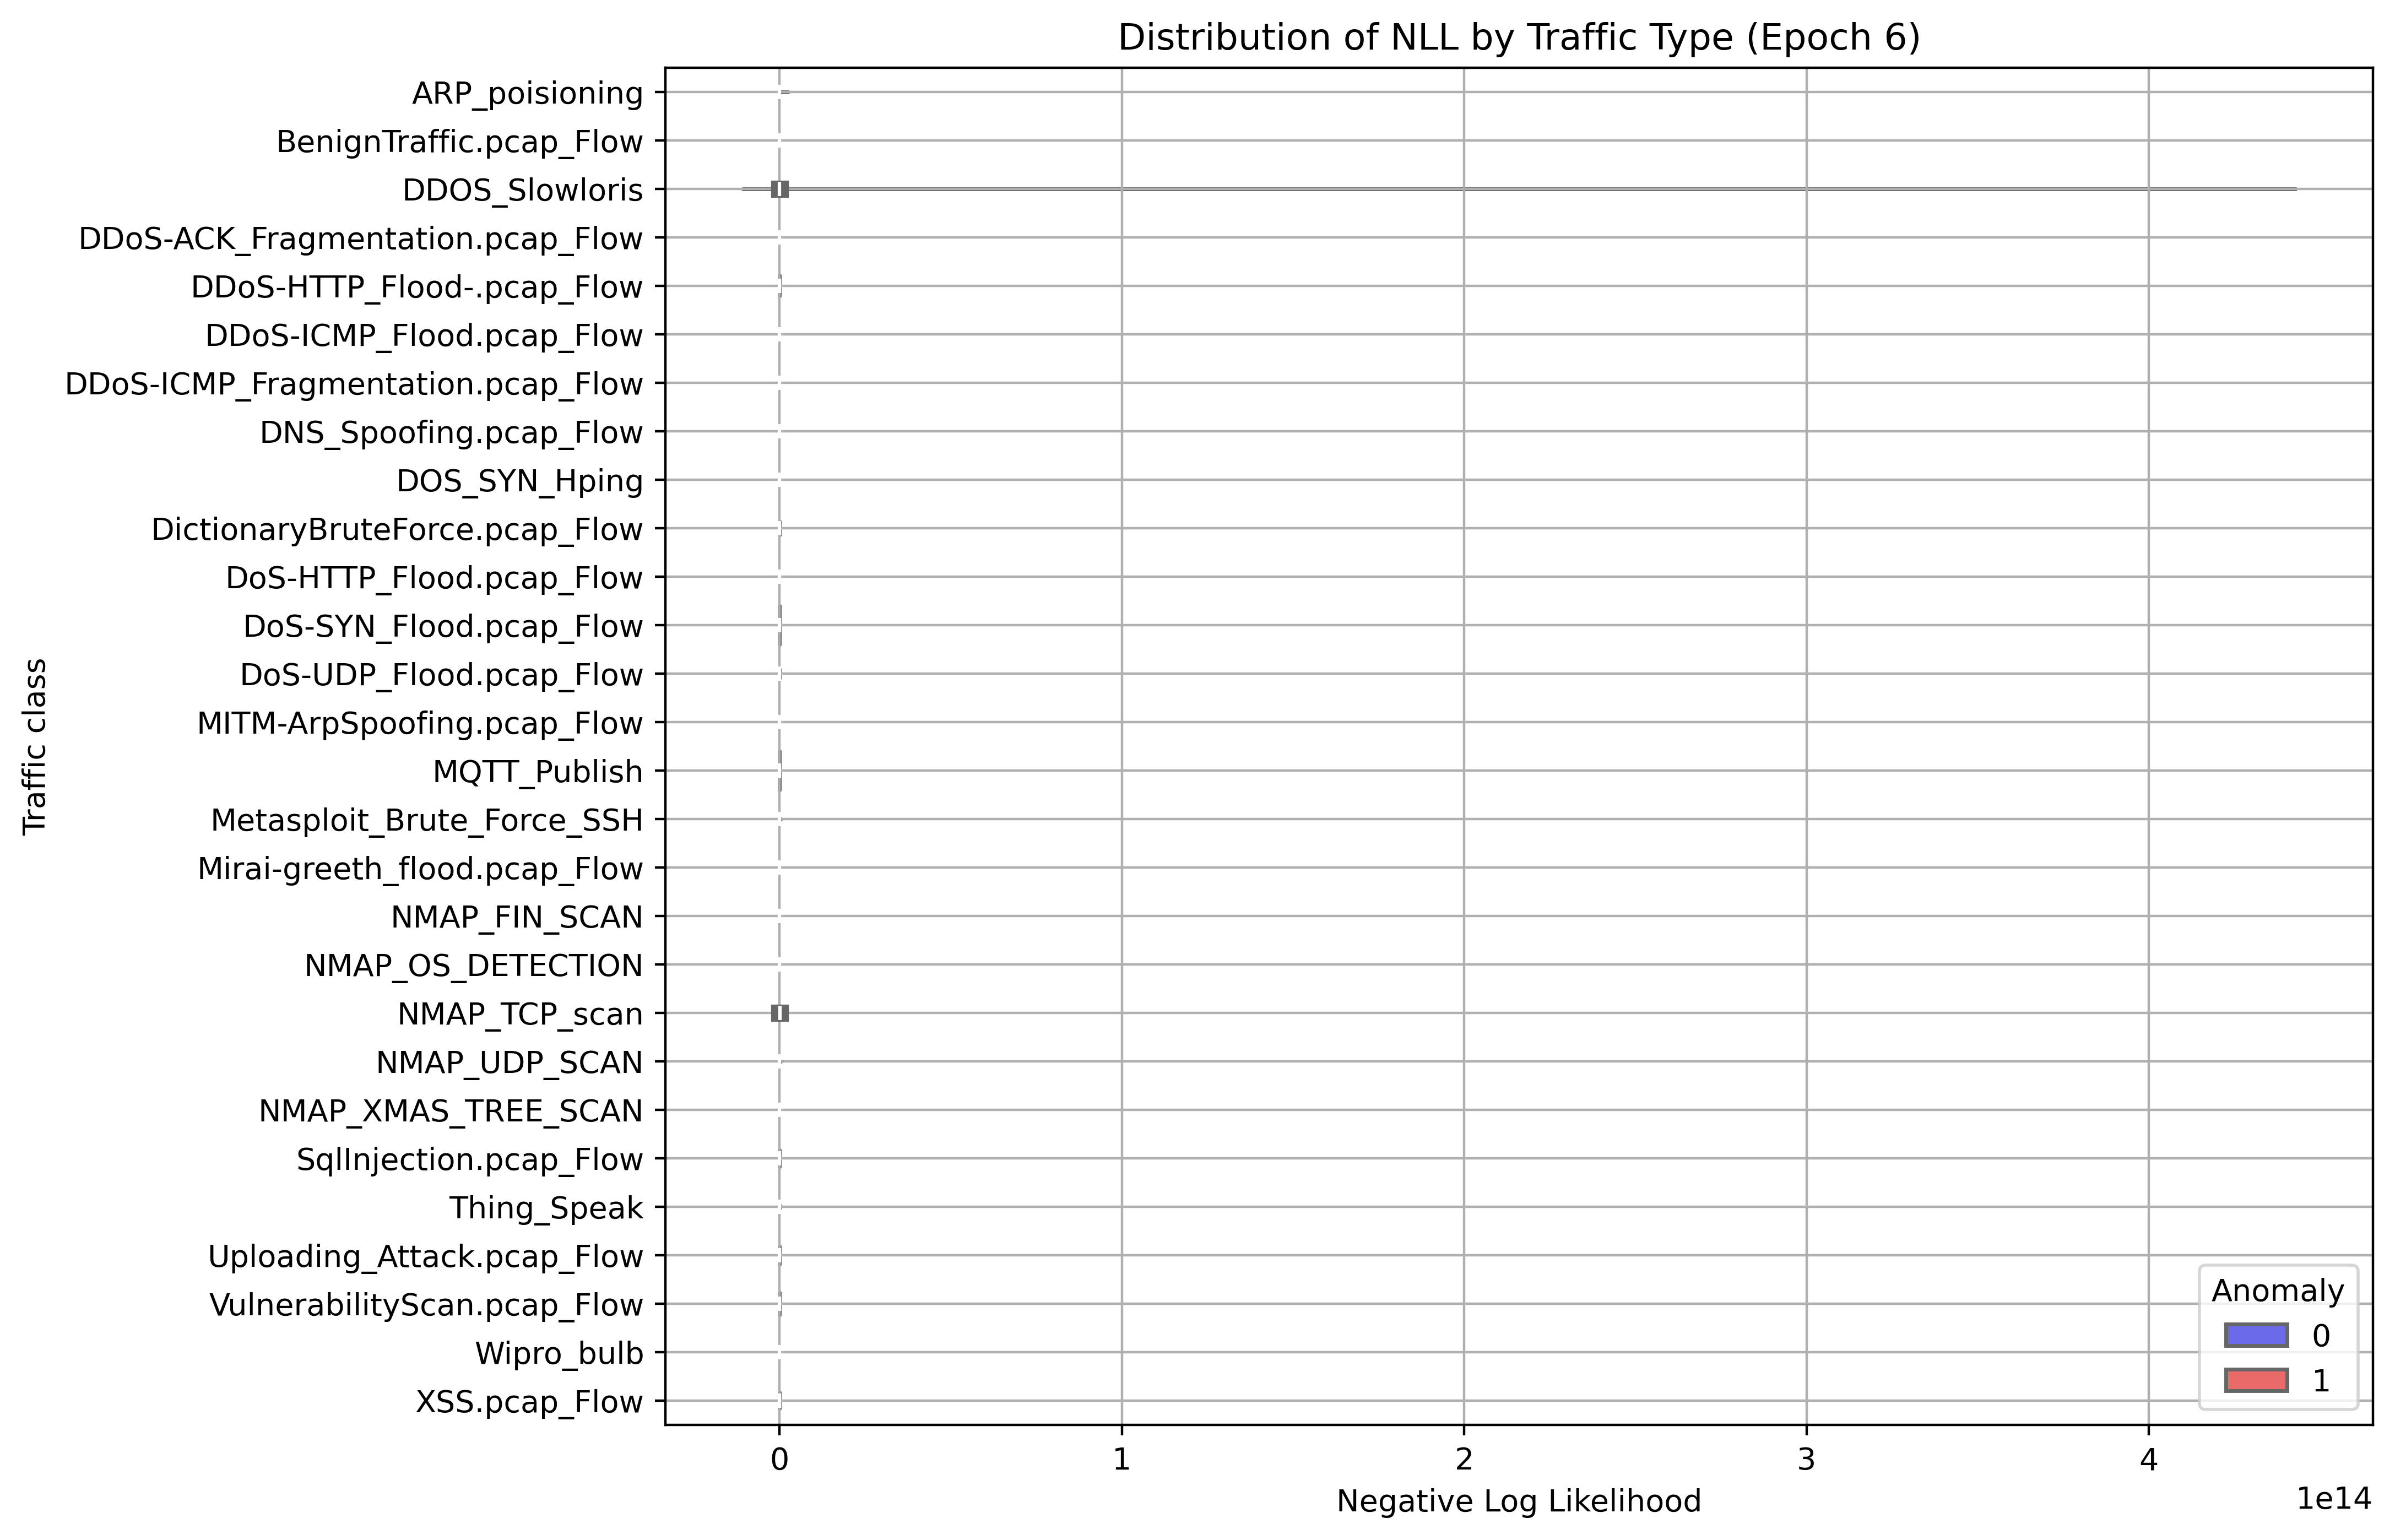

In [488]:
# Model inference

final_ll = []
final_cls = []

norm_flows_model.eval()

with torch.no_grad():
    
    for batch in val_loader:

        x_val, cond_val, class_labels = batch.values()
        
        x_val = x_val.to(DEVICE)
        cond_val = cond_val.to(DEVICE)

        z, log_det = norm_flows_model(x_val, cond_val)
        log_p_z = prior_distribution.log_prob(z).sum(dim = -1)
        total_ll = log_p_z + log_det
        final_ll.extend((-total_ll).cpu().tolist())  # Negative log-likelihood
        final_cls.extend([val_dataset.index_label_mapping[c.item()] for c in class_labels])

error_df = pd.DataFrame({
    'Reconstruction error': final_ll,
    'Traffic class': final_cls
})

error_df['Anomaly'] = (~error_df['Traffic class'].isin([
    key for key, val in traffic_type_mapping.items() if val == 'Benign'])).astype('int8')

fig = plt.figure(figsize=(10, 8), dpi=400)

sns.violinplot(x='Reconstruction error', y='Traffic class', data=error_df, palette='seismic', hue='Anomaly', orient='h')
plt.xlabel('Negative Log Likelihood')
plt.ylabel('Traffic class')
plt.title(f'Distribution of NLL by Traffic Type (Epoch {epoch + 1})')
plt.grid(True)
fig.savefig(f'nf_val_epoch_{epoch + 1}.png', dpi=400, bbox_inches='tight')
plt.show()


Best Threshold: -94.609891
Best Balanced Accuracy: 0.8756
              precision    recall  f1-score   support

           0       0.49      0.96      0.65     41082
           1       0.99      0.81      0.89    210247

    accuracy                           0.83    251329
   macro avg       0.74      0.88      0.77    251329
weighted avg       0.91      0.83      0.85    251329



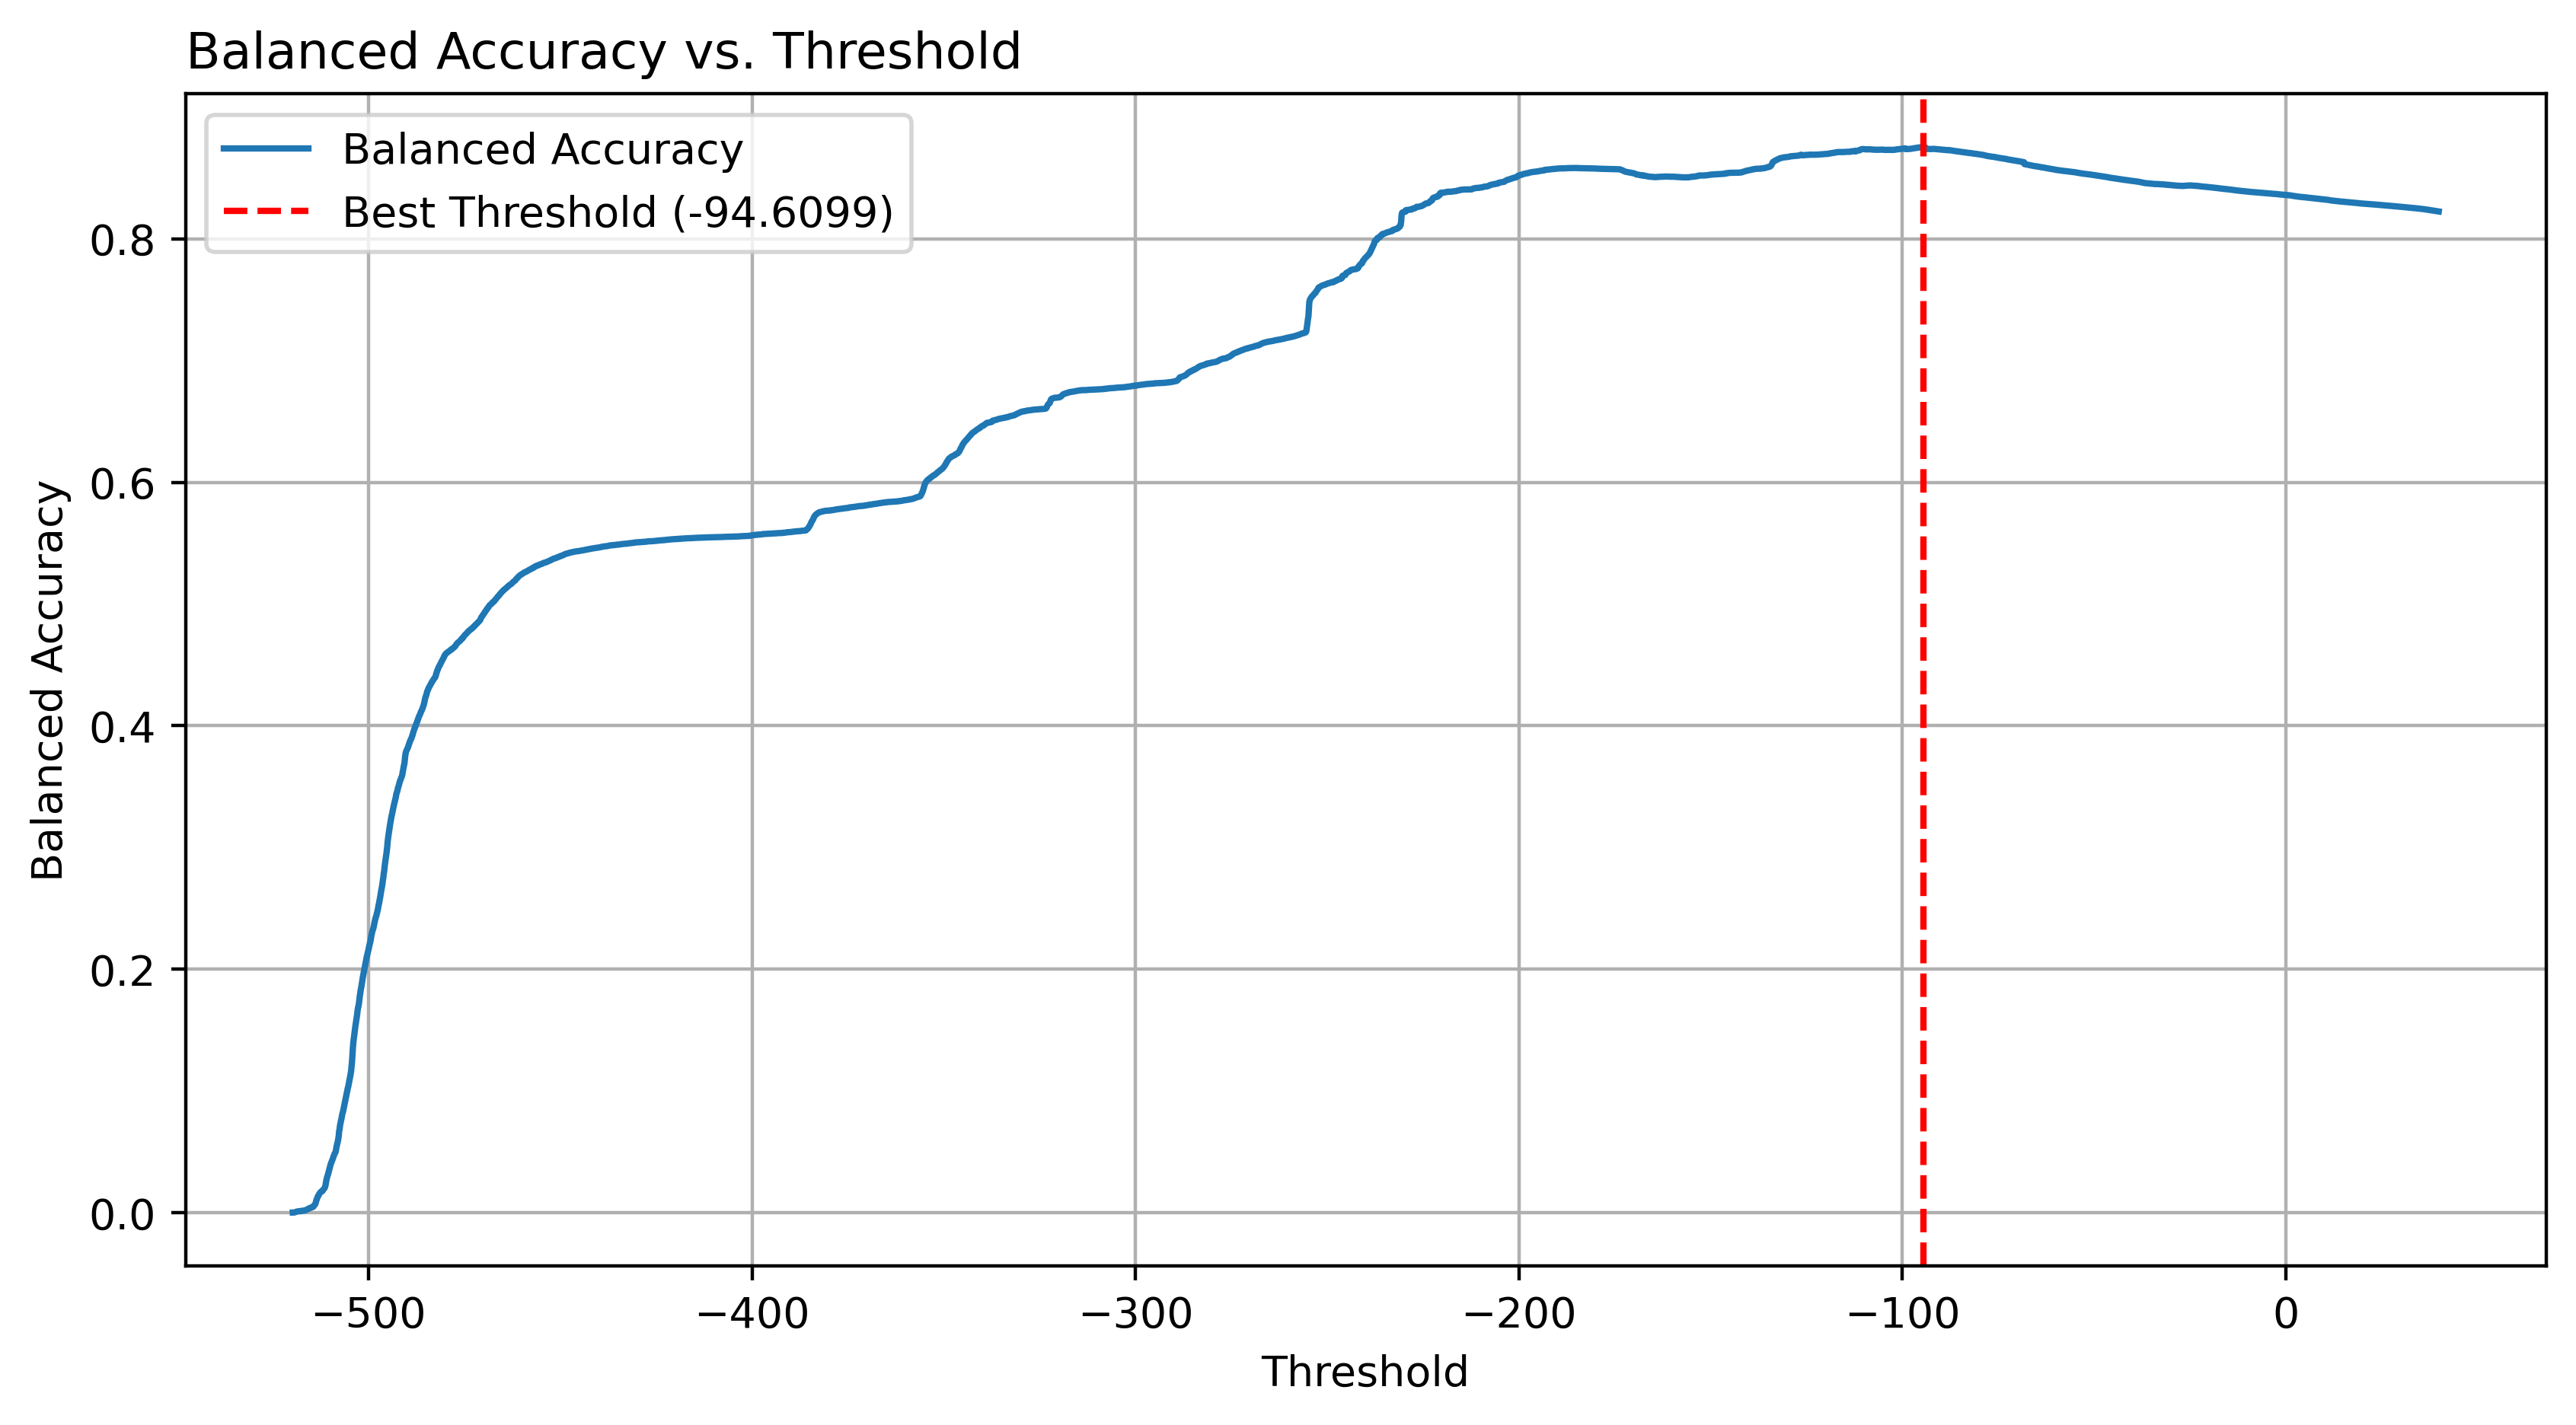

In [498]:
# Tune reconstruction thresholds

search_quantiles = (0, 0.3)

thresholds = np.linspace(
    error_df.loc[error_df['Anomaly'] == 0, 'Reconstruction error'].quantile(search_quantiles[0]),
    error_df.loc[error_df['Anomaly'] == 1, 'Reconstruction error'].quantile(search_quantiles[1]), 5000)

best_threshold = None
best_balanced_accuracy = -np.inf
benign_anomaly_tradeoff = 1

balanced_accuracies = []

for threshold in thresholds:
    
    y_pred = (error_df['Reconstruction error'] > threshold).astype(int)
    
    benign_mask = (error_df['Anomaly'] == 0)
    malicious_mask = (error_df['Anomaly'] == 1)
    
    benign_accuracy = (y_pred.loc[benign_mask] == error_df.loc[benign_mask, 'Anomaly']).mean()
    malicious_accuracy = (y_pred.loc[malicious_mask] == error_df.loc[malicious_mask, 'Anomaly']).mean()
    
    if benign_accuracy > 0 and malicious_accuracy > 0:
        balanced_acc = (1 + benign_anomaly_tradeoff) * (benign_accuracy * malicious_accuracy) / \
                       (benign_anomaly_tradeoff * malicious_accuracy + benign_accuracy)
    else:
        balanced_acc = 0
    
    balanced_accuracies.append(balanced_acc)
    
    if balanced_acc > best_balanced_accuracy:
        best_balanced_accuracy = balanced_acc
        best_threshold = threshold

print(f'Best Threshold: {best_threshold:.6f}')
print(f'Best Balanced Accuracy: {best_balanced_accuracy:.4f}')

error_df['Predicted anomaly'] = (error_df['Reconstruction error'] > best_threshold).astype(int)

print(classification_report(error_df['Anomaly'], error_df['Predicted anomaly']))

# Visualize performance

fig = plt.figure(figsize = (10, 5), dpi = 400)
plt.plot(thresholds, balanced_accuracies, label = 'Balanced Accuracy')
plt.axvline(x = best_threshold, color='red', linestyle = '--', label = f'Best Threshold ({best_threshold:.4f})')
plt.xlabel('Threshold')
plt.ylabel('Balanced Accuracy')
plt.title('Balanced Accuracy vs. Threshold', loc = 'left')
plt.legend()
plt.grid(True)

fig.savefig('diffusion_threshold.png', dpi = 400)

plt.show()
